# A Modular Approach to Simulation using Python Generators

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

### Summary

This notebook demonstrates shows how to use the Python generators for simulation. This technique implements simulation blocks as Python generators, and shows how to piece blocks together to simulate more complex systems. This is an advanced technique that may be useful in certain projects and a convenient alternative to block diagram simulators.

### Table of Contents

1. [Simulation using scipy.integrate.odeint()](#section1)
    1. [Typical Usage](#section1-1)
    2. [What's Wrong with That? ](#section1-2)<br><br>
2. [Python Generators](#section2)
    1. [Yield Statement](#section2-1)
    2. [Iterators](#section2-2)
    3. [Two-way communcation with Generators using Send](#section2-3)<br><br>
3. [Example Application: Modeling Gravity-Drained Tanks with Python Generators](#section3)
    1. [Generator for a Gravity-Drained Tank](#section3-1)
    2. [Simulation of a Single Tank with Constant Inflow](#section3-2)
    3. [Simulation of Two Tanks in Series](#section3-3)
    4. [Simulation of Two Tanks in Series with PI Level Control on the Second Tank](#section3-4)
    5. [Adding a PI Control Generator](#section3-5)
    6. [Implementing Cascade Control for Two Tanks in Series with Unmeasured Disturbance](#section3-6)<br><br>
4. [Enhancing Modularity with Class Definitions for Process Units](#section4)
    1. [Gravity-Drained Tank Class](#section4-1)
    2. [PI Controller Class](#section4-2)
    3. [Modular Simulation of Cascade Control for Two Tanks in Series](#section4-3)<br><br>

<a id='section1'></a>
## Simulation using scipy.integrate.odeint()

<a id='section1-1'></a>
### Typical Usage

The SciPy library provides a convenient and familiar means of simulating systems modeled by systems of ordinary differential equations.  As demonstrated in other notebooks, the straightforward approach consists of several common steps

1. Initialize graphics and import libraries
2. Fix parameter values
3. Write a function to evaluate RHS of the differential equations
4. Choose initial conditions and time grid
5. Perform the simulation by numerical solution of the differential equations
6. Prepare visualizations and post-processing

Here we demonstrate this approach for a two gravity-drained tanks connected in series with constant inflow.

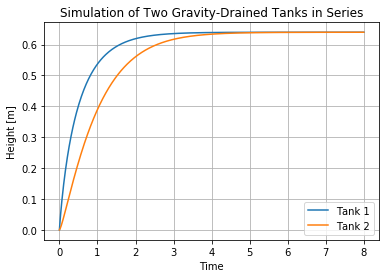

In [1]:
# 1. Initialize graphics and import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

# 2. Fix parameter values
A = 0.2
Cv = 0.5
qin = 0.4

# 3. Write a function to evaluate RHS of the differential equations
def deriv(X,t,qin=0):
    h1,h2 = X
    dh1 = (qin - Cv*np.sqrt(h1))/A
    dh2 =  (Cv*np.sqrt(h1) - Cv*np.sqrt(h2))/A 
    return [dh1,dh2]

# 4. Choose initial conditions and time grid
IC = [0,0]
t = np.linspace(0,8,500)

# 5. Perform the simulation by numerical solution of the differential equations
sol = odeint(deriv,IC,t,args=(qin,))

# 6. Prepare visualizations and post-processing
plt.plot(t,sol)
plt.legend(['Tank 1','Tank 2'])
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Simulation of Two Gravity-Drained Tanks in Series')
plt.grid()

<a id='section1-2'></a>
## What's Wrong with That?

If direct simulation as outlined above meets the needs of your project, then be satisfied and move on. This is how these tools are intended to be used.

However, as written above, simulation with scipy.integrate.odeint requires you to write a function that calculates the right hand side of a system of differential equations. This can be challenging for complex system. For example, you may have multiple PID controllers, each implementing logic for anti-reset windup. Or you may have components in the process that exhibit hysterisis, time-delay, or other difficult-to-model dynamics. These cases call for a more modular approach to modeling and simulation.

In these cases we'd like to combine the continous time dynamics modeled by differential equations with more complex logic executed at discrete points in the time.

<a id='section2'></a>
## Python Generators

<a id='section2-1'></a>
### Yield Statement

One of the more advanced and often overlooked features of Python is the use of [generators and iterators](http://nvie.com/posts/iterators-vs-generators/) for performing operations on sequences of information. In particular, a generator is a function that returns information to via the `yield` statement rather then the more commonly encountered return statement. When called again, the generator picks right up at the point of the yield statement.

Let's demonsrate this by writing a generator of Fibonacci numbers. This generator returns all Fibonacci numbers less or equal to a given number $n$.

In [2]:
def fib(n):
    i = 0
    j = 1
    while j <= n:
        yield j
        i,j = j,i+j

Here's a typical usage.  What are the Fibonacci numbers less than or equal to 100?

In [3]:
for k in fib(100):
    print(k)

1
1
2
3
5
8
13
21
34
55
89


The generator can also be used inside list comprehensions.

In [4]:
[k for k in fib(1000)]

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987]

<a id='section2-2'></a>
### Iterators

When called, a generator function creates an intermediate function called an iterator. Here we construct the iterator  and use it within a loop to find the first 10 Fibonacci numbers.

In [5]:
f = fib(500)
for k in range(0,10):
    print(next(f))

1
1
2
3
5
8
13
21
34
55


Using `next` on an iterator returns the next value. 

<a id='section2-3'></a>
### Two-way communcation with Generators using Send

So far we have demonstrated the use of `yield` as a way to communicate information from the generator to the calling program. Which is fine if all you need is one-way communication. But for the modular simulation of processes, we need to be able to send information both ways.  A feedback control module, for example, will need to obtain current values of the process variable in order to update its internal state to provide an update of the manipulated variable to calling programm.

Here's the definition of a generator for negative feedback proportional control where the control gain $K_p$ and setpoint $SP$ are specified constants.

In [22]:
def proportionalControl(Kp,SP):
    MV = None
    while True:
        PV = yield MV
        MV = Kp*(SP-PV)

The `yield` statement is now doing double duty.  When first called it sends the value of MV back to the calling program, then stops and waits. It is waiting for the calling program to send a value of PV using the `.send()` method. Execution resumes until the yield statement is encountered again and the new value of MV returned to the calling program.

With this behavior in mind, gettting the generator ready for use is a two step process. The first step is to create an instance (i.e., an iterator).  The second step is to initialize the instance by issuing `.send(None)` command.  This is will halt execution at the first `yield` statement. At that point the generator instance will be ready to go for subsequent simulation.

Here's the initialization of a new instance of proportional control with $K_p = 2.5$ and $SP = 2$.

In [25]:
pc = proportionalControl(2.5,2)
pc.send(None)

This shows it in use.

In [29]:
for PV in range(0,5):
    print(PV, pc.send(PV))

0 5.0
1 2.5
2 0.0
3 -2.5
4 -5.0


You can verify that these results satisfy the proportional control relationship.

<a id='section3'></a>
## Example Application: Modeling Gravity-Drained Tanks with Python Generators

The first step in using a Python generator for simulation is to write the generator. It will be used to create instances of the dynamical process being modeled by the generator. Parameters should include a sample time `dt` and any other model parameters you choose to specify a particular instance of the process. The yield statement should provide time plus any other relevant process data. The yield statement will produce new values of process inputs valid for the next time step.

<a id='section3-1'></a>
### Generator for a Gravity-Drained Tank

In [6]:
# generator for a gravity-drained tank model

def gravtank_generator(dt, A=1, Cv=1, IC=0):
    
    def qout(h):
        return Cv*np.sqrt(float(h))
    
    def deriv(h,t):
        dh = (qin - qout(h))/A
        return dh
    
    h = IC
    t = 0
    while True:
        qin = yield t,qout(h),float(h)
        h = odeint(deriv,h,[t,t+dt])[-1]
        t += dt

<a id='section3-2'></a>
### Simulation of a Single Tank with Constant Inflow

Next we show how to use the generator to create a simulation consisting of a single gravity drained tank with constant inflow.

1. Choose a sample time for the simulation.
2. Create instances of the processes to be used in your simulation.
3. The first call to an instance is f.send(None). This will return the initial condition.
4. Subsequent calls to the instance should be f.send(u) where u is variable, tuple, or other data time being passed to the process. The return value will be a tuple contaning the next value of time plus other process data.


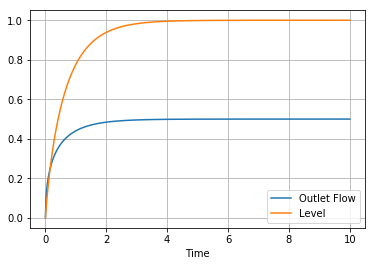

In [7]:
# 1. select sample time
dt = 0.02

# 2. create a process instance
tank = gravtank_generator(dt, A=0.2, Cv=.5)

# 3. get initial condition
y = [tank.send(None)]

# 4. append subsequent states 
y += [tank.send(0.5) for t in np.arange(0,10,dt)]

# 5. extract information into numpy arrays for plotting
t,q,h = np.asarray(y).transpose()
plt.plot(t,q,t,h)
plt.xlabel('Time')
plt.legend(['Outlet Flow','Level'])
plt.grid()

<a id='section3-3'></a>
### Simulation of Two Tanks in Series

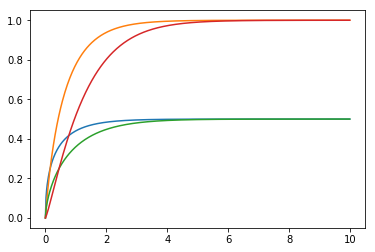

In [8]:
dt = 0.02

tank1 = gravtank_generator(dt, A=0.2, Cv=.5)
tank2 = gravtank_generator(dt, A=0.2, Cv=.5)

y1 = [tank1.send(None)]
y2 = [tank2.send(None)]

for t in np.arange(dt,10,dt):
    t1,q1,h1 = tank1.send(0.5)
    t2,q2,h2 = tank2.send(q1)
    
    y1.append([t1,q1,h1])
    y2.append([t2,q2,h2])
    
t1,q1,h1 = np.asarray(y1).transpose()
t2,q2,h2 = np.asarray(y2).transpose()
plt.plot(t1,q1,t1,h1)
plt.plot(t2,q2,t2,h2)

<a id='section3-4'></a>
### Simulation of Two Tanks in Series with PI Level Control on the Second Tank

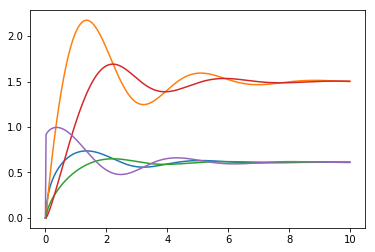

In [9]:
dt = 0.02

tank1 = gravtank_generator(dt, A=0.2, Cv=.5)
tank2 = gravtank_generator(dt, A=0.2, Cv=.5)

y1 = [tank1.send(None)]
y2 = [tank2.send(None)]

u = 0.0
r2 = 1.5
Kp = .6
Ki = .6
ecurr = 0
ulog = [u]

for t in np.arange(dt,10,dt):
    t1,q1,h1 = tank1.send(u)
    t2,q2,h2 = tank2.send(q1)
    
    eprev,ecurr = ecurr,r2-h2
    u += Kp*(ecurr-eprev) + Ki*ecurr*dt
    u = max(0,min(1,u))
    
    y1.append([t1,q1,h1])
    y2.append([t2,q2,h2])
    ulog.append(u)
    
t1,q1,h1 = np.asarray(y1).transpose()
t2,q2,h2 = np.asarray(y2).transpose()
plt.plot(t1,q1,t1,h1)
plt.plot(t2,q2,t2,h2)
plt.plot(t1,ulog)

<a id='section3-5'></a>
### Adding a PI Control Generator

In [10]:
def PI_generator(dt, Kp, Ki, MVmin = 0, MVmax = np.Inf):

    ecurr = 0
    eprev = 0
    t = 0
    u = MVmin
    
    while True:
        r,y,u = yield t,u
        eprev,ecurr = ecurr,r-y
        u += Kp*(ecurr - eprev) + Ki*ecurr*dt
        u = max(MVmin,min(MVmax,u))
        t += dt

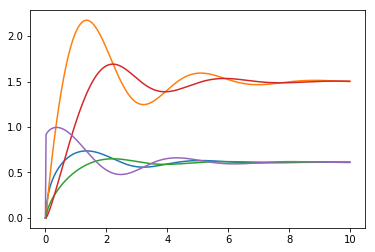

In [11]:
dt = 0.02

tank1 = gravtank_generator(dt, A=0.2, Cv=.5)
tank2 = gravtank_generator(dt, A=0.2, Cv=.5)
pi = PI_generator(dt, Kp = 0.6, Ki = 0.6, MVmin = 0, MVmax = 1)

y1 = [tank1.send(None)]
y2 = [tank2.send(None)]
ulog = [pi.send(None)[1]]

u = 0

for t in np.arange(dt,10,dt):
    t1,q1,h1 = tank1.send(u)
    t2,q2,h2 = tank2.send(q1)
    t3,u = pi.send((r2,h2,u))
    
    y1.append([t,q1,h1])
    y2.append([t,q2,h2])
    ulog.append(u)
    
t1,q1,h1 = np.asarray(y1).transpose()
t2,q2,h2 = np.asarray(y2).transpose()

plt.plot(t1,q1,t1,h1)
plt.plot(t2,q2,t2,h2)
plt.plot(t1,ulog)

<a id='section3-6'></a>

### Implementing Cascade Control for Two Tanks in Series with Unmeasured Disturbance

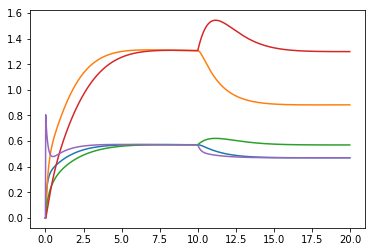

In [12]:
# disturbance function
def d(t):
    if t > 10:
        return 0.1
    else:
        return 0

# simulation
dt = 0.02

tank1 = gravtank_generator(dt, A=0.2, Cv=.5)
tank2 = gravtank_generator(dt, A=0.2, Cv=.5)

# level control for tank 1.  
pi1 = PI_generator(dt, Kp = 1, Ki = 0.6, MVmin = 0, MVmax = 1)

# cascade level control for tank 2. Manipulated variable is the setpoint to pi1
pi2 = PI_generator(dt, Kp = 0.6, Ki = 0.6, MVmin = 0, MVmax = 2)

y1 = [tank1.send(None)]
y2 = [tank2.send(None)]
ulog = [pi1.send(None)[1]]
pi2.send(None)

u = 0
r1 = 0
r2 = 1.3

for t in np.arange(dt,20,dt):
    t1,q1,h1 = tank1.send(u)
    t2,q2,h2 = tank2.send(q1 + d(t))
    t3,r1 = pi2.send((r2,h2,r1))
    t4,u = pi1.send((r1,h1,u))
    
    y1.append([t,q1,h1])
    y2.append([t,q2,h2])
    ulog.append(u)
    
t1,q1,h1 = np.asarray(y1).transpose()
t2,q2,h2 = np.asarray(y2).transpose()
plt.plot(t1,q1,t1,h1)
plt.plot(t2,q2,t2,h2)
plt.plot(t1,ulog)

<a id='section4'></a>
## Enhancing Modularity with Class Definitions for Process Units

One of the key goals of a modular approach to simulation is to implement process specific behavior within the definitions of the process, and separate from the organization of information flow among units that takes place in the main simulation loop.

Below we define two examples of class definitions demonstrating how this can be done. The class definitions add features for defining names and parameters for instances of each class, and functions to log and plot data gathered in the course of simulations.

<a id='section4-1'></a>
### Gravity-Drained Tank Class

In [13]:
class gravtank():
    
    def __init__(self, name='', A=1, Cv=1):
        self.name = name
        self.A = A
        self.Cv = Cv
        self._log = []
        self.qin = 0
    
    def qout(self,h):
        return self.Cv*np.sqrt(float(h))
    
    def deriv(self,h,t):
        dh = (self.qin - self.qout(h))/self.A
        return dh
    
    def plot(self):
        t,qout,h = np.asarray(self._log).transpose()
        plt.plot(t,qout,label=self.name + ' qout')
        plt.plot(t,h,label=self.name + ' h')
        plt.legend()
    
    def generator(self,dt,IC = 0):
        h = IC
        while True:
            t,self.qin = yield self.qout(h),float(h)
            h = odeint(self.deriv,h,[t,t+dt])[-1]
            self._log.append([t,self.qout(h),float(h)])
            t += dt

<a id='section4-2'></a>
### PI Controller Class

In [14]:
class PI():
    
    def __init__(self, name='', Kp = 0, Ki = 0, MVmin = 0, MVmax = np.Inf):
        self.name = name
        self.Kp = Kp
        self.Ki = Ki
        self.MVmin = MVmin
        self.MVmax = MVmax
        self._log = []
        
    def plot(self):
        t,r,y,u = np.asarray(self._log).transpose()
        plt.subplot(1,2,1)
        p = plt.plot(t,y,label=self.name + ' PV')
        plt.plot(t,r,'--',color=p[-1].get_color(),label=self.name + ' SP')
        plt.legend()
        plt.title('Process Variable and Setpoint')
        plt.subplot(1,2,2)
        plt.plot(t,u,label=self.name + ' MV')
        plt.title('Manipulated Variable')
        plt.legend()
        plt.tight_layout()
        
    def generator(self,dt):
        ecurr = 0
        eprev = 0
        u = self.MVmin
        while True:
            t,r,y,u = yield u
            self._log.append([t,r,y,u]) 
            eprev,ecurr = ecurr,r-y
            u += Kp*(ecurr - eprev) + Ki*ecurr*dt
            u = max(self.MVmin,min(self.MVmax,u))
            t += dt

<a id='section4-3'></a>
### Modular Simulation of Cascade Control for Two Tanks in Series

The following simulation shows how to use the class definitions in a simulation.  Each process instance used in the simulation requires three actions:

1. Create an instance of the process. This is the step at which you can provide an instance name, parameters specific to the process and instance. Methods associated with the instance will be used to examine simulation logs and plot simulation results.

2. Create a generator. A call to the generator function for each process instance creates an associated iterator. A sample time must be specified.

3. An initial call to the iterator with an argument of `None` is needed to advance execution to the first `yield` statement.

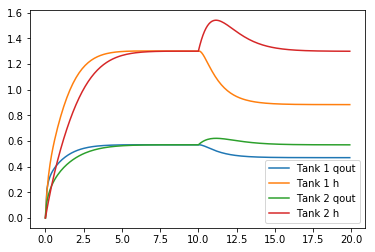

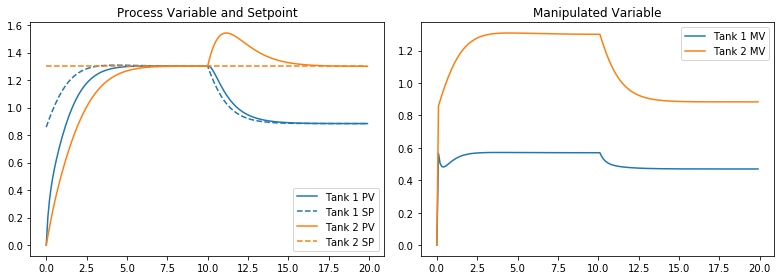

In [15]:
# disturbance function
def d(t):
    if t > 10:
        return 0.1
    else:
        return 0

# sample time
dt = 0.1

# create and initialize tank1
tank1_obj = gravtank(name='Tank 1',A=0.2, Cv=.5)
tank1 = tank1_obj.generator(dt)
tank1.send(None)

# create and initailize tank2
tank2_obj = gravtank(name='Tank 2',A=0.2, Cv=0.5)
tank2 = tank2_obj.generator(dt)
tank2.send(None)

# level control for tank 1. 
pi1_obj = PI('Tank 1',Kp = 1, Ki = 0.6, MVmin = 0, MVmax = 1)
pi1 = pi1_obj.generator(dt)
pi1.send(None)

# cascade level control for tank 2. Manipulated variable is the setpoint to for pi1
pi2_obj = PI('Tank 2',Kp = 0.6, Ki = 0.6, MVmin = 0, MVmax = 2)
pi2 = pi2_obj.generator(dt)
pi2.send(None)

# initial signals
u, r1 = 0, 0

# setpoint for tank 2 level
r2 = 1.3

for t in np.arange(0,20,dt):
    qout1,h1 = tank1.send((t,u))
    qout2,h2 = tank2.send((t,qout1 + d(t)))
    r1 = pi2.send((t,r2,h2,r1))
    u = pi1.send((t,r1,h1,u))    

plt.figure()
tank1_obj.plot()
tank2_obj.plot()

plt.figure(figsize=(11,4))
pi1_obj.plot()
pi2_obj.plot()

# Animation in Jupyter Notebooks

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

### Summary

Animation features are built into the Python matplotlib library and available through Jupyter notebooks. Unfortunately, however, the documentation is not particularly robust. This short notebook provides simple demonstrations of using animiation for the visualization of simulation results. 

The resulting animations are html video files embedded within the Jupyter notebook. The videos can be viewed in any modern web browser. Since they don't require an active Python kernal, the animations can be seen when the even when notebook is viewed as a static HTML web page.

The techniques used below come from blog postings [Animating the Lorenz System in 3D](https://jakevdp.github.io/blog/2013/02/16/animating-the-lorentz-system-in-3d/) and [Embedding Matplotlib Animations in Jupyter Notebooks](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/).

## Prerequisites

You should be able to view the animations with any modern web browser. However, to create animiations using the following cells you will need to install a video codec. By default matplotlib is configured to use ffmpeg. You find instructions on installing ffmpeg [here](https://github.com/adaptlearning/adapt_authoring/wiki/Installing-FFmpeg).

## Step-by-Step Approach to Animation with Matplotlib

### Step 1. Create the background frame.

The following cell creates a background frame for the animation. These are standard matplotlib graphics commands, but where we have kept a reference to the resulting objects. The objects include `fig` for the figure object, `ax1` and `ax2` for each of the two plotting axes, and then `txt_title`, `line1`, `line2`, `pt1`, and `line3` for graphical elements that will be updated in each frame of the animation.

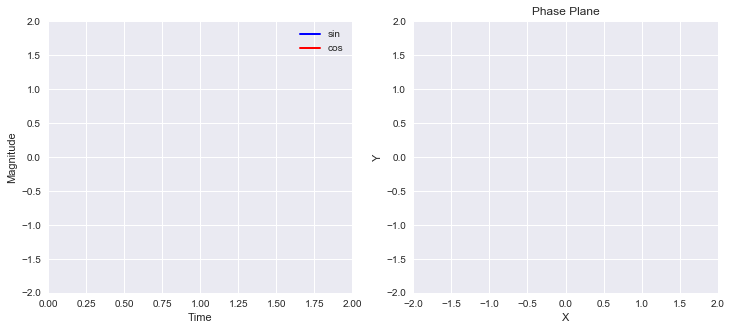

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# create a figure and axes
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)

# set up the subplots as needed
ax1.set_xlim(( 0, 2))            
ax1.set_ylim((-2, 2))
ax1.set_xlabel('Time')
ax1.set_ylabel('Magnitude')

ax2.set_xlim((-2,2))
ax2.set_ylim((-2,2))
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Phase Plane')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
line1, = ax1.plot([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects
line2, = ax1.plot([], [], 'r', lw=2)
pt1, = ax2.plot([], [], 'g.', ms=20)
line3, = ax2.plot([], [], 'y', lw=2)

ax1.legend(['sin','cos']);

### Step 2. Define a function to draw each frame

The animiation function is a function you define to draw individual frames in the animation. The variable `n` will be the frame number.  The function draws the frame by resetting the data values for the global objects `txt_title`, `line1`, `line2`, `pt1`, and `line3` that were defined above.

In [2]:
# animation function. This is called sequentially
def drawframe(n):
    x = np.linspace(0, 2, 1000)
    y1 = np.sin(2 * np.pi * (x - 0.01 * n))
    y2 = np.cos(2 * np.pi * (x - 0.01 * n))
    line1.set_data(x, y1)
    line2.set_data(x, y2)
    line3.set_data(y1[0:50],y2[0:50])
    pt1.set_data(y1[0],y2[0])
    txt_title.set_text('Frame = {0:4d}'.format(n))
    return (line1,line2)

### Step 3. Create the Animation Object

The animation class includes a function `FuncAnimation` that incorporations a user-specified function to update the figure for each frame of the animation. The result is an animation object which is subsequently called to actually produce the desired animation.

In [3]:
from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=20, blit=True)

### Step 4. Render the Animation

The final step is to actually render and display the desired animation. This is the compute-intensive step in the procedure. The next cell imports `HTML` which is used to display a HTML elements created in a python script. The animation is rendered to html5 video with the `to_html5_video()` function and then displayed with `HTML()`.

In [4]:
from IPython.display import HTML
HTML(anim.to_html5_video())

An alternative to the use of HTML is to set the default rendering of an animation object. 

In [5]:
from matplotlib import rc

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

Once the default rendering of the animation object is set to html5, all you have to do is ask to display the animation object. Everything is then done behind the scenes to render and display the desired animation.

In [6]:
anim

## Example: Phase Plane Animation for an Exothermic Stirred-Tank Reactor

This is more complex example that demonstrates the complex dynamics of an exothermic continuous stirred-tank reactor when operated with an unstable steady state. The computational strategy is to compute solutions to the dynamical model for a set of initial conditions, then step through the solutions simulataneously to draw frames in the animation.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.integrate import odeint

from matplotlib import animation
from IPython.display import HTML

# mode parameteres
Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q = 100.0       # Flowrate [L/min]
cAi = 1.0       # Inlet feed concentration [mol/L]
Ti  = 350.0     # Inlet feed temperature [K]
cA0 = 0.5;      # Initial concentration [mol/L]
T0  = 350.0;    # Initial temperature [K]
Tc  = 305.0     # Coolant temperature [K]

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/R/T)

def deriv(y,t):
    cA,T = y
    dcA = (q/V)*(cAi - cA) - k(T)*cA
    dT = (q/V)*(Ti - T) + (-dHr/rho/Cp)*k(T)*cA + (UA/V/rho/Cp)*(Tc-T)
    return [dcA,dT]

# create a set of initial conditions
ICs = [[cA0,T0] for cA0 in [0] for T0 in np.linspace(295,480,19)]
ICs += [[cA0,T0] for cA0 in np.linspace(0,1,21) for T0 in [290]]
ICs += [[cA0,T0] for cA0 in [1] for T0 in np.linspace(295,475,18)]

# perform simulations for each of the initial conditions
t = np.linspace(0,10.0,800)
sols = [odeint(deriv,IC,t) for IC in ICs]

# create background figure and axes
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((0,1))
ax.set_ylim((290,480))
ax.set_xlabel('Concentration [gmol/liter]')
ax.set_ylabel('Temperature [K]')
ax.set_title('Exothermic Reactor with Tc = {0:.1f} K'.format(Tc))

# create lists of colors, points, and lines
colors = sns.color_palette("husl",len(sols))
pts = sum([ax.plot([],[],'o',color=colors[k],ms=15) for k in range(0,len(sols))],[])
lines = sum([ax.plot([],[],color=colors[k],lw=2) for k in range(0,len(sols))],[])

# don't show the plain background
plt.close()

# define function to draw each frame
def drawframe(n):
    for k in range(0,len(sols)):
        C,T = sols[k].T
        pts[k].set_data(C[n],T[n])
        lines[k].set_data(C[:n],T[:n])
    return pts + lines

# create animiation object and render in HTML video
anim = animation.FuncAnimation(fig, drawframe, frames=len(t), interval=20, blit=True)
HTML(anim.to_html5_video())

## Baroreflex as a Linear Control System

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

The [baroreflex](https://en.wikipedia.org/wiki/Baroreceptor) is one of several mechanisms in the body for maintaining arterial blood pressure (AP) at near constant levels. Specialized neurons, known as [baroreceptors](https://en.wikipedia.org/wiki/Baroreceptor), sense pressure through the stretching of the walls in key blood vessels. The signals are processed in the brainstem which, in turn, produces a compensating change in sympathetic and parasympathetic nervous system causing a response by the heart.  (Figure from Victor, 2015).

![baroreflex system](../images/nrcardio.2015.96-f2.jpg)

This notebook presents a linear control analysis of the closed-loop system consisting of a 'peripheral arc' from the sympathetic efferents connected to the heart tissue that cause the blood pressure to increase, and a corresponding 'neural arc' from the carotid baroreceptors sensing blood pressure to the sympathetic nervous response. Together these arcs comprise a closed-loop for the short-term control of blood pressure in the body (McLoone, 2014). 

This is diagrammed below in the form a closed loop control system

![baroreflex control diagram](../images/baroreflex.png)

where $AP$ refers to arterial blood pressure, and $SNA$ is the activity of the sympathetic nervous system correlated with response of the heart, $G_p$ represents the transfer function of the peripheral arc, and $G_c$ represents the transfer function of the neural (or control) arc.  The signal $p$ is placeholder for the influence of exogenous influences on blood pressure, such as a change in body body position. 

In [24]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import control.matlab as control

sns.set_context('talk')

# needed to avoid a deprecation warning in the control library 
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

## Peripheral Arc

Transfer function models for the 'peripheral arc', denoted $G_p(s)$ in the closed-loop diagram, have been measured for various animal models. For anesthesized rats, for example, Chapius et al., 2004, found

$$G_p(jf) = \left(\frac{K}{1 + 2\lambda(f/f_n) + (j(f/f_n))^2}\right)\exp\left(-2\pi Tjf\right)$$

where $j$ is the imaginary operator $\sqrt{-1}$, and $f$ is frequency in units of Hertz. Reported values for the parameters are given in the following table.

| Parameter | Description | $\qquad\qquad$ Value $\qquad\qquad$ | Conversion |
| :--: | :- | :-: | :-: |
| $K$ | static gain | $1.16 \pm 0.21$ mmHg/% SNA | $K_p \approx 1.16$ mmHg/% SNA|
| $f_n$ | natural frequency | $0.089\pm 0.007$ Hz | $\tau \approx 1.79$ sec |
| $\lambda$ | damping coefficient | $1.23\pm 0.14$ | $\zeta \approx 1.23$
| $T$ | fixed time delay | $0.476\pm 0.020$ sec | $t_d \approx 0.476$ |

Using the indicated conversions of values and parameters, the literature model is recast into standard transfer function notation

$$G_p(s) =  \left(\frac{K_p}{\tau^2 s^2 + 2\zeta\tau s + 1}\right)\exp\left(-t_d s\right)$$

The following cell implements this transfer function using the [Python Control Systems Library](https://pypi.python.org/pypi/control/0.7.0).

In [25]:
Kp = 1.16                  # mmHg/%SNA
tau = 1.0/(2*0.089*np.pi)  # sec
zeta = 1.23
td = 0.476

Gp_ = control.tf([Kp],[tau**2,2*zeta*tau,1])
print('\nWithout Time Delay -->\n', Gp_)

num,den = control.pade(td,3)
Gp = Gp_ * control.tf(num,den)
print('\nWith a 3rd order Pade approximation for Time Delay -->\n', Gp)


Without Time Delay -->
 
          1.16
-----------------------
3.198 s^2 + 4.399 s + 1


With a 3rd order Pade approximation for Time Delay -->
 
           -1.16 s^3 + 29.24 s^2 - 307.2 s + 1291
------------------------------------------------------------
3.198 s^5 + 85.02 s^4 + 958.7 s^3 + 4748 s^2 + 5160 s + 1113



The following cell demonstrates the step response of the peripheral arc to a 1% change in $SNA$.

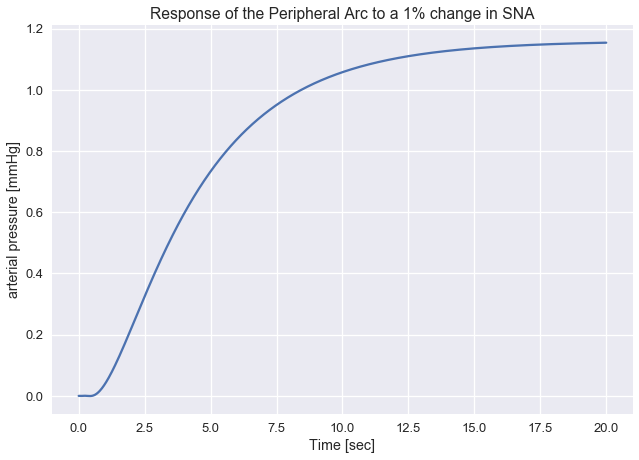

In [26]:
t = np.linspace(0,20,1000)
y,t = control.step(Gp,t)
plt.plot(t,y)
plt.xlabel('Time [sec]')
plt.ylabel('arterial pressure [mmHg]')
plt.title('Response of the Peripheral Arc to a 1% change in SNA');

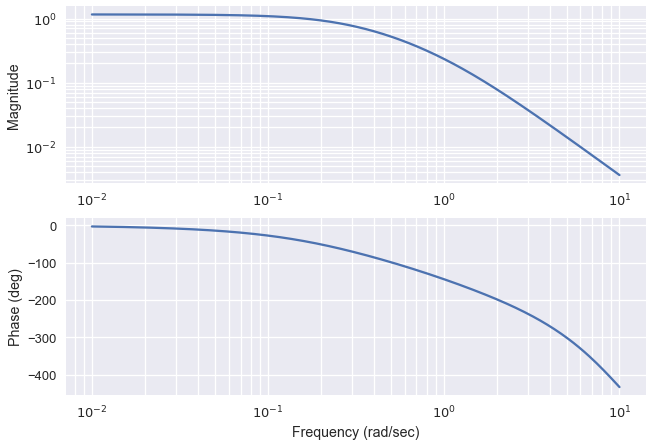

In [29]:
w = np.logspace(-2,1,300)
mag,phase,w = control.bode(Gp,w)

## P, PI, PD, and PID Control

Let's now consider how the baroreflex would behave if a controller were designed without regard to the underlying physiology.  For this purpose we'll consider the design of a PID control using tuning rules typical of practice in process control.

For coding convenience, we implement a utiity function that creates a transfer function for P, PI, PD, or PID control in standard form. The general expression is given by

$$ G_c^{PID}(s) = K_c\left[1 + \frac{1}{\tau_I s} + \frac{\tau_D s}{\alpha \tau_D s + 1}\right] $$

where the third term provides realizable derivative action. Parameter $\alpha \approx 0.1$ provides high-frequency roll-off of the derivative action.  When specialized and expressed over a common denominator, the specific forms of the controller become

\begin{align*}
G_c^{P} & = K_c \\
G_c^{PI} & = K_c \frac{\tau_Is + 1}{\tau_I s} \\
G_c^{PD} & = K_c \frac{(1+\alpha)\tau_D s + 1}{\alpha\tau_Ds + 1} \\
G_c^{PID} & = K_c\frac{(1+\alpha) \tau_I \tau_D s^2 + (\tau_I+\alpha\tau_D) s +  1}{\alpha \tau_I \tau_D s^2 + \tau_I s}
\end{align*}

In [39]:
def PID(Kc=1,tauI=0,tauD=0):
    alpha = 0.1
    Gc = control.tf([1],[1])
    if tauI != 0:
        Gc += control.tf([1],[1,0])
    if tauD != 0:
        Gc += control.tf([tauD,0],[alpha*tauD,1])
    return Kc*Gc

def P(Kc=1):
    return PID(Kc,0,0)

def PI(Kc=1,tauI=0):
    return PID(Kc,tauI,0)

def PD(Kc=1,tauD=0):
    return PID(Kc,0,tauD)

PID(1,1,1)


1.1 s^2 + 1.1 s + 1
-------------------
    0.1 s^2 + s

### Ziegler-Nichols Tuning

[Ziegler-Nichols tuning](https://en.wikipedia.org/wiki/Ziegler%E2%80%93Nichols_method) is a well known and widely used methods for determining an intial tuning of P, PI, PD, and PID controllers. The methods requires values of $K_{cu}$ (the proportional-only control gain at which a sustained oscillation is observed) and $P_u$ (the period of the observed oscillation). 

| Control Type | $K_p$ | $\tau_I$ | $\tau_D$ |
| :- | :-: | :-: | :-: |
| P | $0.5 K_u$ | - | - |
| PI | $0.45 K_u$ | $P_u$/$1.2$ | - |
| PD | $0.8 K_u$ | - | $P_u$/$8$ |
| classic PID | $0.6 K_u$ | $P_u$/$2$ | $P_u$/$8$ |
| Pessen Integral Rule | $0.7 K_u$ | $P_u$/$2.5$ | $3 P_u$/$20$ |
| some overshoot | $0.33 K_u$ | $P_u$/$2$ | $P_u$/$3$ |
| no overshoot | $0.2 K_u$ | $P_u$/$2$ | $P_u$/$3$ |

In the following cell, these values are obtained using the `margin` function from the Python Control Library, then verified by plotting a closed-loop step response using a proportional-only controller.

Ultimate Gain =  8.80991289154
Ultimate Period =  3.88965615063


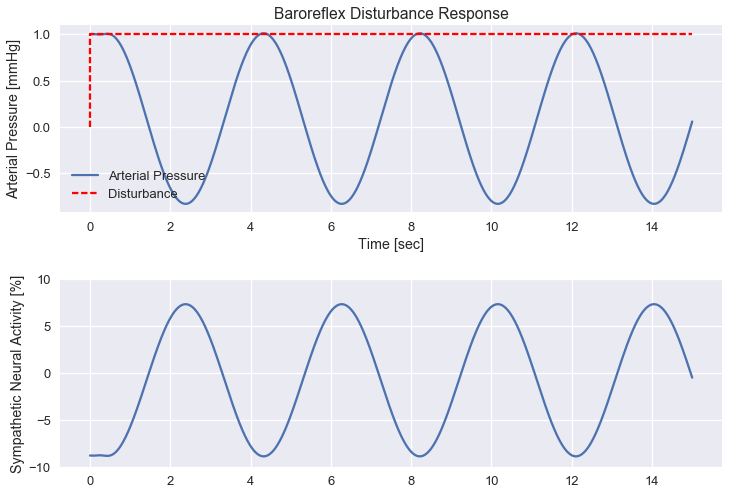

In [40]:
gm,pm,Wcg,Wcp = control.margin(Gp)
Kcu = gm
Pu = 2*np.pi/Wcp

print('Ultimate Gain = ', Kcu)
print('Ultimate Period = ', Pu)

def stepResponse(Gp,Gc,t):
    y,t = control.step(1/(1+Gp*Gc),t)
    u,t = control.step(-Gc/(1+Gp*Gc),t)
    plt.subplot(2,1,1)
    plt.plot(t,y,[0,0,max(t)],[0,1,1],'r--')
    plt.xlabel('Time [sec]')
    plt.ylabel('Arterial Pressure [mmHg]')
    plt.title('Baroreflex Disturbance Response')
    plt.legend(['Arterial Pressure','Disturbance'],loc='lower left')
    plt.subplot(2,1,2)
    plt.plot(t,u)
    plt.ylim(-10,10)
    plt.ylabel('Sympathetic Neural Activity [%]')
    plt.tight_layout()
         
t = np.linspace(0,15,1000)
stepResponse(Gp,PID(Kcu,0,0),t)

### Proportional-Derivative Control

Proportional-derivative control is generally associated with the suppression of peak overshoot in the disturbance response. The following shows the baroreflex response subject to PD control using a standard process control tuning rules.

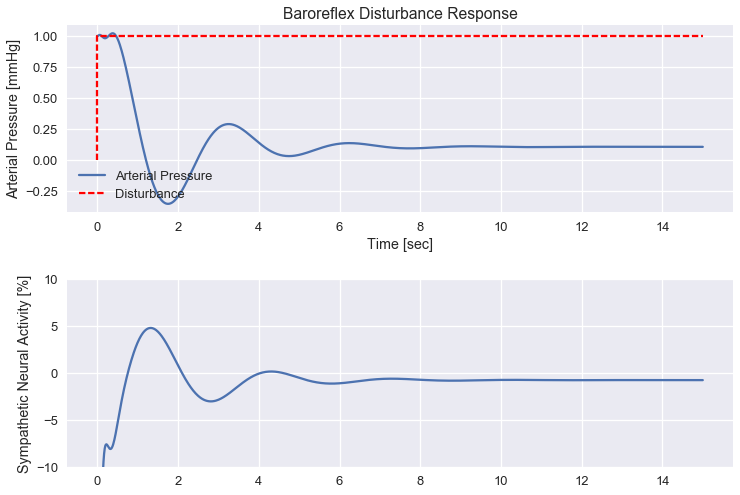

In [41]:
Gc = PID(0.8*Kcu,0,Pu/8)
stepResponse(Gp,Gc,t)

### Internal Model Control Tuning

Case J

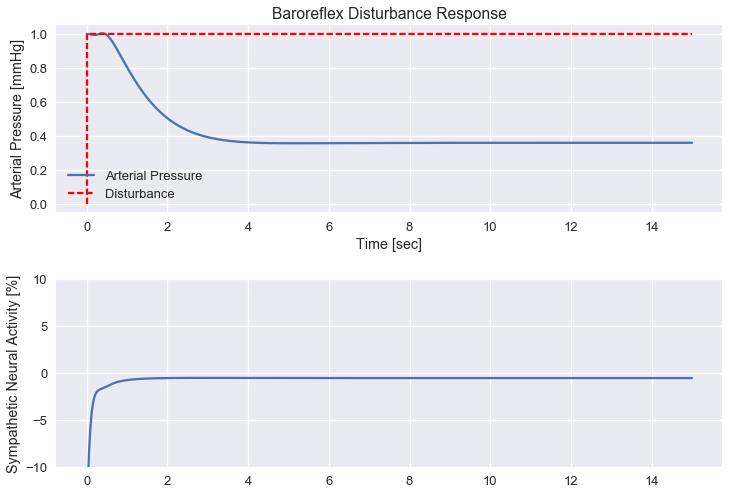

In [42]:
tauC = 2
Kc = (2*zeta*tau)/(tauC + td)/Kp
tauI = 2*zeta*tau
tauD = tau/(2*zeta)

GcIMC = PID(Kc,0,tauD)
t = np.linspace(0,15,1000)
stepResponse(Gp,GcIMC,t)

## Measured Physiological Response of Neural Arc

Petiot, et. al. (2001) (from the same laboratory cited above) provided laboratory measurements of the transfer function for the 'neural (or central) arc' for anesthesized rats. The results were given in the form

$$G_c^{Phys}(jf) = K\left(\frac{1+j(f/f_c)}{1 + 2\lambda j(f/fn)-(f/f_n)^2}\right)\exp\left(-2\pi jTf\right)$$

where $f$ is frequency in units of Hz. 

In the standard form for control engineering, the transfer function is written as

$$G_c^{Phys}(s) = K_c \frac{\tau_c s + 1}{\tau_n^2 s^2 + 2\lambda\tau_n s + 1} e^{-sT}$$

where $\tau = \frac{1}{2\pi f}$ and $s = 2\pi f$ are the conversions from frequency in Hz to time constant and Laplace variable $s$, respectively.

| Parameter | Description | $\qquad\qquad$ Value $\qquad\qquad$ | Conversion |
| :--: | :- | :-: | :-: |
| $K$ | static gain | 1.04 %SNA/mmHg | $K_c \approx$ 1.04 %SNA/mmHg|
| $f_c$ | corner frequency | 0.157 Hz | $\tau_c \approx$ 1.01 sec |
| $f_n$ | natural frequency | 1.12 Hz | $\tau_n \approx$ 0.142 sec |
| $\lambda$ | damping coefficient | 1.71 | $\zeta \approx$ 1.71 |
| $T$ | fixed time delay | 0.101 sec | $t_d \approx$ 0.101 sec|

1.0137257521776772 0.14210262776062083


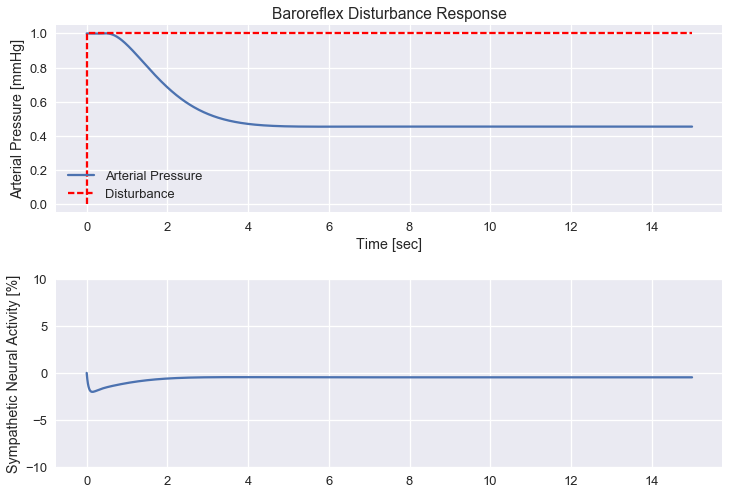

In [43]:
fc = 0.157
fn = 1.12
K = 1.04
zetac = 1.71
tdelay = 1.01

tauc = 1/(2*np.pi*fc)
taun = 1/(2*np.pi*fn)

print(tauc,taun)

num,den = control.pade(tdelay,3)

GcPhys = K*control.tf([tauc,1],[taun**2,2*zetac*taun,1])
stepResponse(Gp,GcPhys,t)

## Comparison of ZN Tuned PD Control to the Observed Physiological Response of the Neural arc

We observe a very different physiological behavior than what we naively predicted using a PD controller tuned using the Ziegler-Nichols rules.  To highlight these differences, the next cell compares the step responses of the two control laws

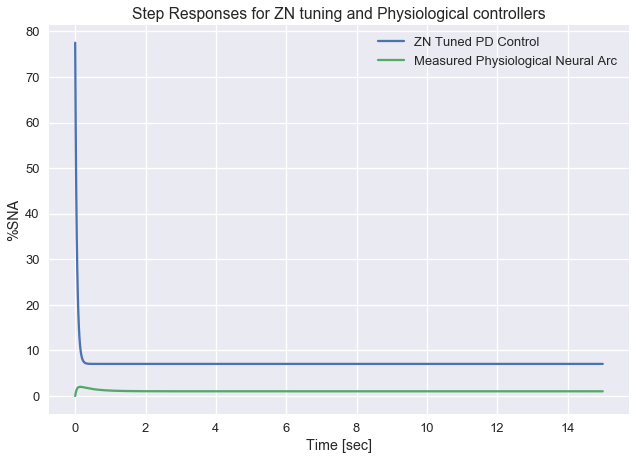

In [44]:
u,t = control.step(Gc,t)
uPhys,t = control.step(GcPhys,t)
plt.plot(t,u,t,uPhys)
plt.xlabel('Time [sec]')
plt.ylabel('%SNA')
plt.title('Step Responses for ZN tuning and Physiological controllers')
plt.legend(['ZN Tuned PD Control','Measured Physiological Neural Arc']);

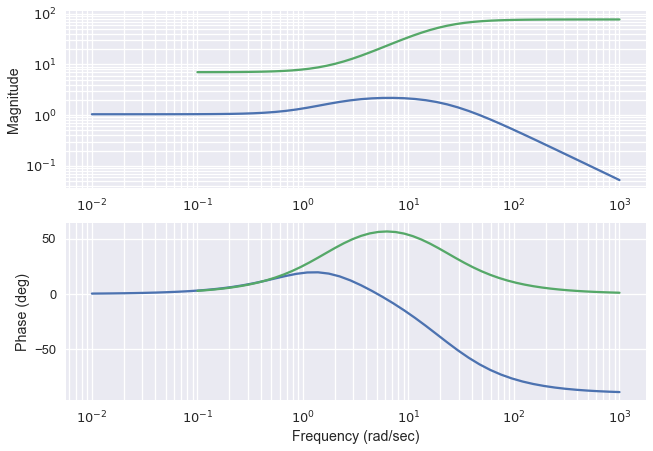

In [45]:
control.bode(GcPhys);
control.bode(Gc);

## Modifications to the PD Controller

Matching the Proportional-Derivative control law to the observed physiological response of the neural arc requires several modifications of the PD controller. The first step is to introduce a second-order filter to suppress the 'derivative kick' 

$$ G_c^{mod}(s) = K_c\left[1 + \frac{\tau_D s}{\alpha \tau_D s + 1}\right]\left[\frac{1}{\tau_n s + 1}\right]^2 $$

The second is to substantially reduce the control gain, and to slightly reduce the derivative time constant for a corresponding tuning $K_c = 0.12 K_{cu}$ and $\tau_D = P_u/6$. The following cells compares the computed baroreflex response with these modifications in place.

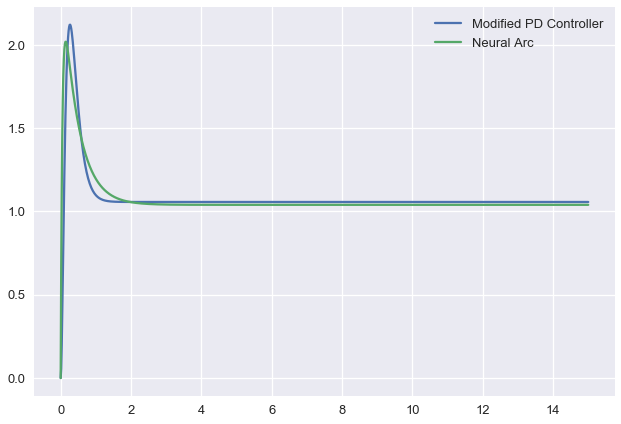

In [46]:
Gc = PID(0.12*Kcu,0,Pu/6)
Gcf = Gc*(control.tf([1],[1*taun,1]))**2
uf,t = control.step(Gcf,t)

uPhys,t = control.step(GcPhys,t)

plt.plot(t,uf,t,uPhys)
plt.legend(['Modified PD Controller','Neural Arc']);

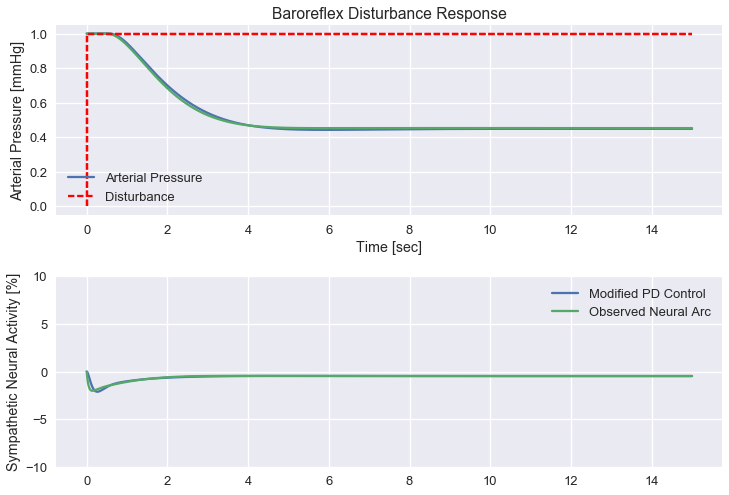

In [47]:
stepResponse(Gp,Gcf,t)
stepResponse(Gp,GcPhys,t)
plt.legend(['Modified PD Control','Observed Neural Arc']);

## Conclusions

To create a control response resembling the physiological response inferred from the cited papers, it was necessary to:

1. Introduce a filter to significantly reduce the 'derivative kick' associated with a standard PID control implementation.
2. Reduce the proportional gain by a factor of about 5 from a value that would be typically used in industrial process control.
3. There was no integral response observed in the physiologically consistent control.

### References


Chapuis, Bruno et al. “Linear Modelling Analysis of Baroreflex Control of Arterial Pressure Variability in Rats.” The Journal of Physiology 559.Pt 2 (2004): 639–649. PMC. Web. 29 Mar. 2017. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1665118/

Kamiya, Atsunori et al. “Closed-Loop Spontaneous Baroreflex Transfer Function Is Inappropriate for System Identification of Neural Arc but Partly Accurate for Peripheral Arc: Predictability Analysis.” The Journal of Physiology 589.Pt 7 (2011): 1769–1790. PMC. Web. 28 Mar. 2017.  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3099029/

Roy Kanbar, Valérie Oréa, Bruno Chapuis, Christian Barrès, Claude Julien
American Journal of Physiology - Regulatory, Integrative and Comparative Physiology Nov 2007, 293 (5) R1938-R1946; DOI: 10.1152/ajpregu.00374.2007  http://ajpregu.physiology.org/content/293/5/R1938.short

McLoone, Violeta. "Modelling of Long and Short Term Blood Pressure Control Systems." PhD Thesis, NUI Maynooth, 2014.  http://eprints.maynoothuniversity.ie/5611/1/Thesis_V_McLoone-Final_Version.pdf

Petiot, Emmanuelle et al. “Frequency Response of Renal Sympathetic Nervous Activity to Aortic Depressor Nerve Stimulation in the Anaesthetized Rat.” The Journal of Physiology 537.Pt 3 (2001): 949–959. PMC. Web. 29 Mar. 2017. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2278997/

Victor, Ronald G. "Carotid baroreflex activation therapy for resistant hypertension." Nature Reviews Cardiology 12, 451–463 (2015) doi:10.1038/nrcardio.2015.96 http://www.nature.com/nrcardio/journal/v12/n8/full/nrcardio.2015.96.html



# Blending Tank Simulation

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

### Summary

This example provides an introduction to the use of python for the simulation of a simple process modeled by a pair of ordinary differential equations. See SEMD textbook example 2.1 for more details on the process.

## Basic Simulation of the Blending Tank

\begin{align*}
\frac{dV}{dt} & = \frac{1}{\rho}(w_1 + w_2 - w)\\
\frac{dx}{dt} & = \frac{1}{\rho V}(w_1 (x_1 - x) + w_2 (x_2 - x))
\end{align*}

### Step 1. Initialize Python Workspace

Unlike Matlab, in Python it is always necessary to import the functions and libraries that you intend to use. In this case we import the complete `pylab` library, and the function `odeint` for integrating systems of differential equations from the `scipy` library.  The command `%matplotlib inline` causes graphic commands to produce results directly within the notebook output cells.

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


### Step 2. Establish Parameter Values

In [14]:
rho = 900.0  # density, kg/m**3

w1 = 500.0   # stream 1, kg/min
w2 = 200.0   # stream 2, kg/min
w =  650.0   # set outflow equal to sum of inflows

x1 = 0.4     # composition stream 1, mass fraction
x2 = 0.75    # composition stream 2, mass fraction

### Step 3. Write a function to compute the RHS's of the Differential Equations

In [15]:
def func(y,t):
    V,x = y
    dVdt = (w1 + w2 - w)/rho
    dxdt = (w1*(x1-x)+w2*(x2-x))/(rho*V)
    return [dVdt, dxdt]

### Step 4. Set the Initial Conditions, Time Grid, and Integrate

In [16]:
V = 2.0      # initial volume, cubic meters
x = 0.0      # initial composition, mass fraction

t = np.linspace(0,10.0)
y = odeint(func,[V,x],t)

### Step 5. Visualize the Solution

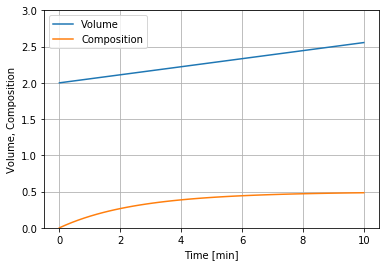

In [17]:
plt.plot(t,y)
plt.xlabel('Time [min]')
plt.ylabel('Volume, Composition')
plt.legend(['Volume','Composition'])
plt.ylim(0,3)
plt.grid()
#plt.savefig('BlendingTankStartUp.png')

## Steady State Analysis

The blending tank is a system with two state variables (volume and composition). Suppose a mechanism is put in place to force the inflow to equal the outflow, that is

$$w = w_1 + w_2$$

The mechanism could involve the installation of an overflow weir, level controller, or some other device to force a balance between the outflow and total inflows.  In this case,

$$\frac{dV}{dt} = 0$$

which means volume is at *steady state*. 

 
In that case there is just one remaining differential equation

$$\frac{dx}{dt} = \frac{1}{\rho V}( w_1(x_1 - x) + w_1(x_2 - x)) = 0$$

Solving for the steady value of $x$,

$$\bar{x} = \frac{w_1x_1 + w_2x_2}{w_1 + w_2}$$

In [19]:
w1 = 500.0   # stream 1, kg/min
w2 = 200.0   # stream 2, kg/min

x1 = 0.4     # composition stream 1, mass fraction
x2 = 0.75    # composition stream 2, mass fraction

x = (w1*x1 + w2*x2)/(w1 + w2)

print('Steady State Composition =', x)

Steady State Composition = 0.5


# Closed-Loop Transfer Functions for Car Cruise Control

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 
    
### Summary

Block diagrams allow you to visualize the flow of information in complex dynamical systems. Using simple elements, it is possible to create models to study the relationship between control structure, process response, and control action.

The purpose of this notebook is to introduce for the analysis of block diagrams made up of linear transfer functions. 

1. [Application: Vehicle Cruise Control](#application)
2. [Closed-Loop Transfer Functions](#closedloop)
3. [Step Responses](#stepresponse)
4. [Additional Examples](#additionalexamples)

<a id='application'></a>
## 1. Block Diagram for Car Cruise Control

Let's imagine you own a car with a mass of 1,500 kg (including passengers) that is traveling down a level stretch of highway at a desired speed of 100 kilometers per hour. You wish to design a cruise controller that will adjust the throttle position $u$ within the limits 0 to 1 in order to maintain constant speed. 

A block diagram for this system is shown in the following sketch:

![Cruise Control Block Diagram](../images/CruiseControl.png)

The disturbance to the system is a change in road grade measured in percent.  (A one percent grade corresponds to 1 foot of rise in 100 feet of horizontal travel, or a tangent of 0.01).  The dynamics are represented by three transfer functions denoting the response of the engine torque to throttle position,

$$G_e = \frac{600}{s + 1}$$

the response of the vehicle to engine and external forces, 

$$G_v = \frac{0.5}{5s + 1}$$

and the dynamics of the speed measurement,

$$G_m = \frac{1}{0.2s + 1}$$

We assume that a one percent increase in grade introduces 150 Newtons of force in opposing the car acceleration, that is

$$G_d = 150$$

The controller is assumed to be a proportional-integral control written as

$$G_c = K_c\left(1 + \frac{1}{\tau_I s}\right)$$

This can be summarized in the following block diagram

![Cruise Control Block Diagram](../images/CruiseControl2.png)


In [1]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import control.matlab as control

# control constants
Kc = 0.01
tauI = 10

# control transfer function
Gc = Kc*control.tf([tauI,1],[tauI,0])

# model transfer functions
Gd = control.tf([150],[1])
Ge = control.tf([600],[1,1])
Gv = control.tf([0.5],[5,1])
Gm = control.tf([1],[0.2,1])

<a id='closedloop'></a>
## 2. Closed-Loop Transfer Functions

Vehicle response to a change in setpoint:

$$H_{yr} = \frac{G_vG_eG_c}{1+G_vG_eG_cG_m}$$

Vehicle response to a disturbance:

$$H_{yd} = -\frac{G_vG_d}{1+G_vG_eG_cG_m}$$

Throttle response to a change in setpoint:

$$H_{ur} = \frac{G_c}{1+G_cG_mG_vG_e}$$

Throttle response to a disturbance:

$$H_{ud} = \frac{G_cG_mG_vG_d}{1+G_cG_mG_vG_e}$$


In [2]:
Hyr = Gv*Ge*Gc/(1+Gv*Ge*Gc*Gm)
Hyd = -Gv*Gd/(1+Gv*Ge*Gc*Gm)
Hur = Gc/(1+Gc*Gm*Gv*Ge)
Hud = Gc*Gm*Gv*Gd/(1+Gc*Gm*Gv*Ge)

In [3]:
print(Hyr)


           300 s^5 + 1890 s^4 + 2046 s^3 + 486 s^2 + 30 s
--------------------------------------------------------------------
500 s^7 + 3700 s^6 + 6920 s^5 + 6340 s^4 + 3170 s^3 + 580 s^2 + 30 s



In [4]:
print(Hyd)


    -750 s^4 - 4650 s^3 - 4650 s^2 - 750 s
-----------------------------------------------
50 s^5 + 320 s^4 + 372 s^3 + 262 s^2 + 55 s + 3



In [5]:
print(Hur)


s^5 + 6.3 s^4 + 6.82 s^3 + 1.62 s^2 + 0.1 s
--------------------------------------------
100 s^5 + 620 s^4 + 620 s^3 + 400 s^2 + 30 s



In [6]:
print(Hud)


         75 s^5 + 472.5 s^4 + 511.5 s^3 + 121.5 s^2 + 7.5 s
--------------------------------------------------------------------
100 s^7 + 1140 s^6 + 3944 s^5 + 4244 s^4 + 2730 s^3 + 556 s^2 + 30 s



<a id='stepresponse'></a>
## 3. Step Responses

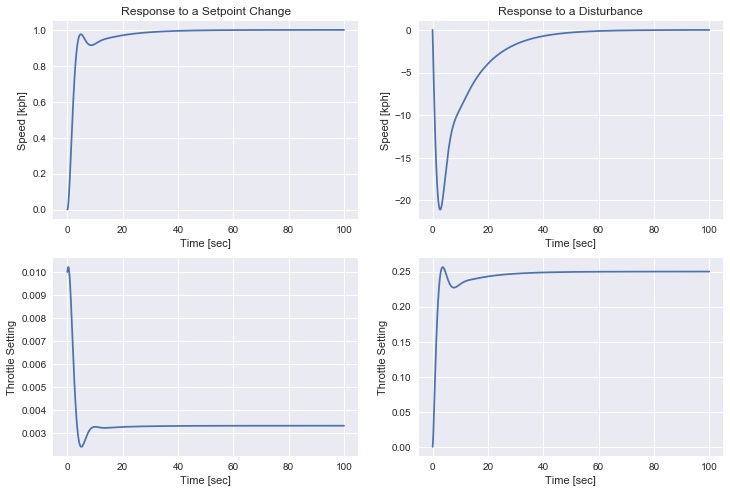

In [7]:
t = np.linspace(0,100,1000)
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
yr,t = control.step(Hyr,t)
plt.plot(t,yr)
plt.xlabel('Time [sec]')
plt.ylabel('Speed [kph]')
plt.title('Response to a Setpoint Change')

plt.subplot(2,2,2)
yd,t = control.step(Hyd,t)
plt.plot(t,yd)
plt.xlabel('Time [sec]')
plt.ylabel('Speed [kph]')
plt.title('Response to a Disturbance')

plt.subplot(2,2,3)
ur,t = control.step(Hur,t)
plt.plot(t,ur)
plt.xlabel('Time [sec]')
plt.ylabel('Throttle Setting')

plt.subplot(2,2,4)
ud,t = control.step(Hud,t)
plt.plot(t,ud)
plt.xlabel('Time [sec]')
plt.ylabel('Throttle Setting')


<a id='additionalexamples'></a>
## 4. Additional Examples

### Internal Model Control

Internal model control is a version of feedback control that incorporates an explicit process model. A simple block diagram of internal model control is given by

![Internal Model Control](../images/Internal_Model_Control.png)

There are two designated inputs, the reference $w$ and disturbance $y_d$, and three labeled signals $u$, $y$, and $d$ that appear relevant to closed-loop performance. Here's the solution for all six closed-loop transfer transfer functions:

| Output\Input | $w$ | $y_d$ |
| :----------: | :-: | :---: |
| $u$ | $\frac{Q}{1 + Q(G - G_m)}$ | $-\frac{Q}{1 + Q(G - G_m)}$ |
| $y$ | $\frac{GQ}{1 + Q(G - G_m)}$ | $\frac{1}{1 + Q(G - G_m)}$ |
| $d$ | $\frac{(G-G_m)Q}{1 + Q(G - G_m)}$ | $\frac{1}{1 + Q(G - G_m)}$ |


### SEMD Figure 11-14

![Internal Model Control](../images/E11-10.png)


$$H_{yd} = \frac{G_3}{1+(G_2 + G_3G_1)K_cK_m}$$

$$H_{yr} = \frac{(G_2+G_3G_1)K_cK_m}{1+(G_2 + G_3G_1)K_cK_m}$$




# Controller Tuning Rules in Frequency Domain

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

Demonstrate the use of a Bode plot for controller tuning. The notebook uses the [Python Control Systems Library](https://github.com/python-control/python-control).  

## Closed-Loop Transfer Functions

### Process Transfer Functions

The process output $y$ is modeled as the output of a linear system described by the transfer function 

$$y = G_p(s)G_v(s) u + G_d(s) d$$

where $G_p(s)$ is the process response to a manipulated variable, $G_v(s)$ is the transfer function of the actuator dynamics, and $G_d(s)$ is process response to a disturbance. The measured process output is given by

$$y_m = G_m(s) y$$

where $G_m(s)$ is the sensor transfer function. We assume the sensor has unit gain, i.e., $G_m(0) = 1$

### Control Transfer Functions

The controller generates a command $u$ in response to the reference input $r$ and measured process output $y_m$. This is modeled as

$$u = G_r(s)r - G_y(s)y_m$$

where $G_r(s)$ and $G_y(s)$ are the controller transfer functions. Textbook simulations often set $G_r(s) = G_y(s)$ for PID control.  In practice, however, it is generally desireable to avoid excessive action in response to setpoint changes, so generally $G_r \neq G_y$.

Below we employ a parallel implementation of PID control for output feedback where

$$G_y(s) = K_p\left[ 1 + \frac{1}{\tau_Is} + \frac{\tau_D s}{\alpha\tau_Ds + 1}\right]$$

where parameter $\alpha$ limits excessive derivative action. Typical values of $\alpha$ are in the range 0.2 to 0.1.

For the reference signal, $G_r(s)$ has the same general form but with additional parameters $\beta$ and $\gamma$

$$G_r(s) = K_p\left[ \beta + \frac{1}{\tau_Is} + \gamma\frac{\tau_D s}{\alpha\tau_Ds + 1}\right]$$

Commonly $\gamma = 0$ to avoid derivative action on the reference signal. Parameter $\beta$ is typically set to a value $0\leq\beta\leq 1$ that balances prompt response to a setpoint against undue 'kicks' caused by sudden changes in setpoint.

### Closed Loop Transfer Functions

The overall response of the closed-loop system is characterized by a set of four transfer functions relating the reference and disturbance inputs to the process output $y$ and the control command $u$.

$$\begin{align*}
y & = H_{yr}(s)r + H_{yd}(s)d \\
u & = H_{ur}(s)r + H_{ud}(s)d
\end{align*}
$$

The closed-loop transfer functions are given explicitly as 

$$H_{yr} = \frac{G_pG_vG_r}{1 + G_pG_vG_yG_m}$$

$$H_{yd} = \frac{G_d}{1 + G_pG_vG_yG_m}$$

$$H_{ur} = \frac{G_r}{1 + G_yG_mG_pG_v}$$

$$H_{ud} = -\frac{G_yG_mG_d}{1 + G_yG_mG_pG_v}$$

where the argument $s$ has been suppressed for brevity.


## Example


We'll assume a process transfer function with time delay

$$G_p(s) = \frac{0.2}{s^2 + 1.5 s + 1}$$

and a disturbance response

$$G_d(s) = \frac{1}{s + 1}$$

and a measurement transfer function

$$G_m(s) = e^{-s}$$

We'll assume the dynamics of the actuator are negligible such that $G_v(s) = 1$. 

The Python Control Systems Library does not provide a specific representation for time delay. It does, however, provide a function `pade` for creating Pade approximations to time delay systems.

### Entering Process Transfer Functions

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from control.matlab import *

Gp = tf([0.2],[1, 1.5, 1])
print("Gp = ", Gp)

Gd = tf([1],[1,1])
print("Gd = ", Gd)

Gv = tf([1],[1])
print("Gv = ", Gv)

(num,den) = pade(1.0,3)
Gm = tf(num,den)
print("Gm = ", Gm)

Gp =  
      0.2
---------------
s^2 + 1.5 s + 1

Gd =  
  1
-----
s + 1

Gv =  
1
-
1

Gm =  
-s^3 + 12 s^2 - 60 s + 120
--------------------------
s^3 + 12 s^2 + 60 s + 120



### Finding Cross-Over Frequency and Gain at Cross-Over

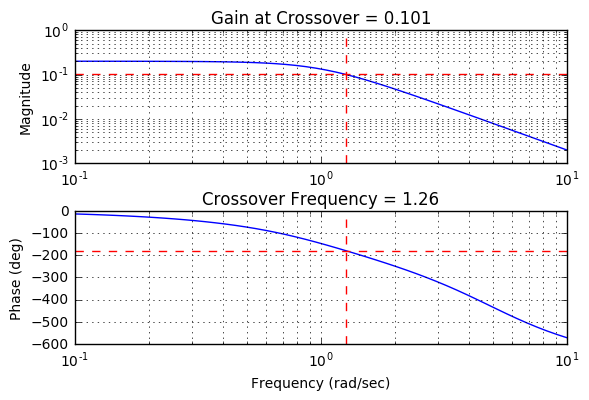

In [2]:
w = np.logspace(-1,1)
mag,phase,omega = bode(Gp*Gm*Gv,w)
plt.tight_layout()

# find the cross-over frequency and gain at cross-over
wc = np.interp(-180.0,np.flipud(phase),np.flipud(omega))
gc = np.interp(wc,omega,mag)

# get the subplots axes
ax1,ax2 = plt.gcf().axes

# add features to the magnitude plot
plt.sca(ax1)
plt.plot([omega[0],omega[-1]],[gc,gc],'r--')
[gmin,gmax] = plt.ylim()
plt.plot([wc,wc],[gmin,gmax],'r--')
plt.title("Gain at Crossover = {0:.3g}".format(gc))

# add features to the phase plot
plt.sca(ax2)
plt.plot([omega[0],omega[-1]],[-180,-180],'r--')
[pmin,pmax] = plt.ylim()
plt.plot([wc,wc],[pmin,pmax],'r--')
plt.title("Crossover Frequency = {0:.3g}".format(wc))

### Computing Ultimate Gain and Period

The conventional tuning rules for process control are written in terms of an ultimate gain $K_{cu}$ and ultimate period $P_u$. These are the values obtained by an experiment or calculation where the gain of a proportional only controller is increased until a steady closed-loop oscillation is first observed. The corresponding proportional gain is $K_{cu}$, and the period of oscillation is $P_u$.

These values may be computed from a Bode plot. The ultimate period corresponds to

$$P_u = \frac{2\pi}{\omega_c}$$

where $\omega_c$ is the cross-over frequency. The ultimate gain is then

$$K_{cu} = \frac{1}{G_p(\omega_c)}$$

where $G_p(\omega_c)$ is the open-loop process gain at the cross-over frequency.

In [3]:
Kcu = 1.0/gc
Pu = 2.0*np.pi/wc

## Ziegler-Nichols Tuning Rules

| Control | $K_p$       | $\tau_I$          | $\tau_D$        |
| :-----: | :---------: | :---------------: | :-------------: |
| P       | $0.5K_{cu}$ | $-$               | $-$             |
| PI      | $0.45K_{cu}$| $\frac{P_u}{1.2}$ | $-$             |
| PID     | $0.6K_{cu}$ | $\frac{P_u}{2}$   | $\frac{P_u}{8}$ |

In [4]:
Kp = 0.6*Kcu
tauI = Pu/2.0
tauD = Pu/8.0

print("Ziegler-Nichols PID Tuning")
print("Kp   = {0:0.3g}".format(Kp))
print("tauI = {0:0.3g}".format(tauI))
print("tauD = {0:0.3g}".format(tauD))

Ziegler-Nichols PID Tuning
Kp   = 5.97
tauI = 2.48
tauD = 0.621


### Interactive Tuning of a PID Controller

The following cell is initiated with the Ziegler-Nichols tuning for PID control. Interactive sliders can be adjusted to tune the controller for acceptable response.

<function __main__.f>

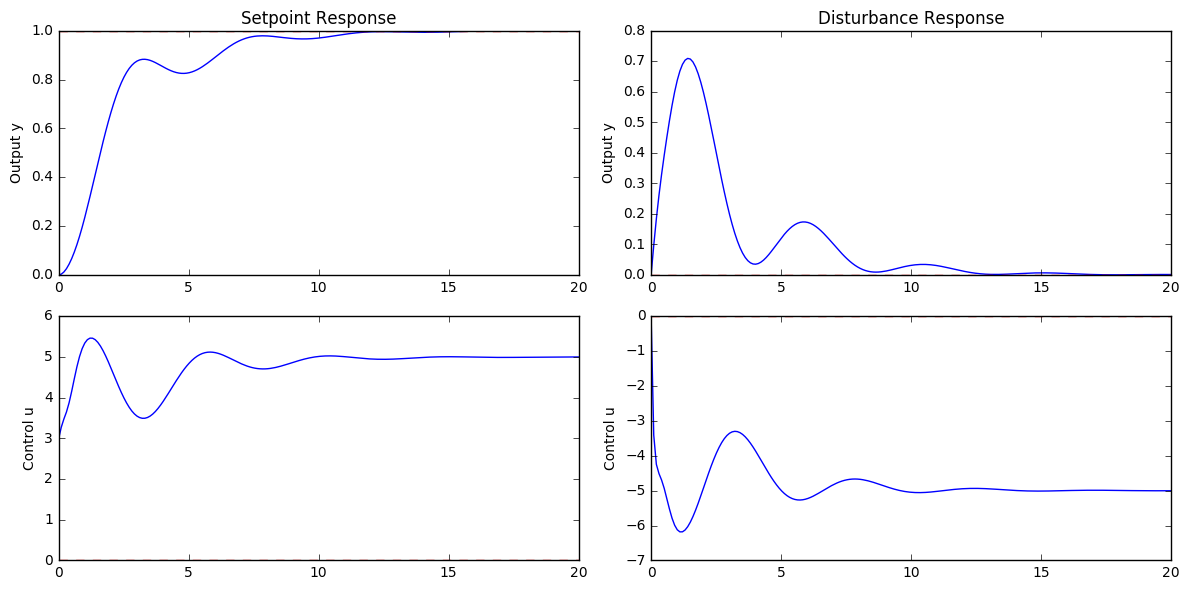

In [5]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

def f(alpha=0.1,beta=0.5,gamma=0.0,Kp=0.6*Kcu,tauI=Pu/2.0,tauD=Pu/8.0):
    
    # parallel implementation of PID control
    P = Kp * tf([1.0],[1.0])
    I = (Kp/tauI) * tf([1.0],[1.0,0.0])
    D = Kp*tauD * tf([1.0,0.0],[alpha*tauD,1.0])

    # controller transfer functions
    Gr = beta*P + I + gamma*D
    Gy = P + I + D

    t = np.linspace(0,20,200)
    plt.figure(figsize=(12,6))

    yr,t = step(Gp*Gv*Gr/(1+Gp*Gv*Gy*Gm),t)
    plt.subplot(2,2,1)
    plt.plot(t,yr)
    plt.plot(plt.xlim(),[1.0,1.0],'r--')
    plt.title('Setpoint Response')
    plt.ylabel('Output y')

    yd,t = step(Gd/(1+Gp*Gv*Gy*Gm),t)
    plt.subplot(2,2,2)
    plt.plot(t,yd)
    plt.plot(plt.xlim(),[0.0,0.0],'r--')
    plt.title('Disturbance Response')
    plt.ylabel('Output y')

    ur,t = step(Gr/(1+Gy*Gm*Gp*Gv),t)
    plt.subplot(2,2,3)
    plt.plot(t,ur)
    plt.plot(plt.xlim(),[0.0,0.0],'r--')
    plt.ylabel('Control u')

    ud,t = step(-Gy*Gd/(1+Gy*Gm*Gp*Gv),t)
    plt.subplot(2,2,4)
    plt.plot(t,ud)
    plt.plot(plt.xlim(),[0.0,0.0],'r--')
    plt.ylabel('Control u')

    plt.tight_layout()
    
interact(f, 
         alpha=fixed(0.1), 
         Kp = (0.01*Kcu,Kcu),
         tauI = (Pu/20.0,Pu),
         tauD = (0.0,Pu),
         continuous_update=False)

In [13]:
def h(a,b):
    print(a,b)

def g(Controller):
    interact(h,a=12.2,b=3.)
    return

interact(g, Controller=['P','PI','PID']);

12.2 3.0


# Creating Bode Plots

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

### Summary

This notebook demonstrate uss of the [Python Control Systems Library](https://github.com/python-control/python-control) to create and annotate Bode plots. Documentation of the control systems library is available [here](http://python-control.readthedocs.io/en/latest/).

## Initializations

These are the standard initializations with the [Python Control Systems Library](https://github.com/python-control/python-control). 

The control library is imported with full prefix `control`.  This is good practice to avoid name conflicts with other libraries.

The control library has a bug where it continues to make use of the deprecated `hold` command from matplotlib. This results in warnings being issued. Use the warnings library to turn off these distracting warnings.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control

import warnings
warnings.filterwarnings('ignore')

## Creating Bode Plots

### Specify a Transfer Function

Given a transfer function with time delay

$$G(s) = 0.2 \frac{0.5s + 1}{1.5s^2 + 0.5 s + 1}$$

the first task to create an object representing the transfer function.

In [2]:
# requires coefficients of the numerator and denominator polynomials
# the coefficients are given starting with the highest power of s

G = 0.2*control.tf([0.5,1],[1.5,0.5,1])
print(G)


    0.1 s + 0.2
-------------------
1.5 s^2 + 0.5 s + 1



### Adding Time Delay

Time delay is a common feature of process control applications. The current version of the Python Control Systems Library does not provide a specific representation for time delay. However, the library does provide a function `pade` to create high-order Pade approximations to time delay.

$$G_p(s) = e^{-0.25s} G(s)$$

Here we add a third order pade approximation for a time delay of 0.25 time units.

In [3]:
(num,den) = control.pade(0.25,3)
Gp = control.tf(num,den)*G
print(Gp)


        -0.1 s^4 + 4.6 s^3 - 86.4 s^2 + 576 s + 1536
-------------------------------------------------------------
1.5 s^5 + 72.5 s^4 + 1465 s^3 + 1.205e+04 s^2 + 4800 s + 7680



### Bode Plot using Default Options

Function `control.bode()` returns values of the magnitude ratio, phase lag, and frequency (in rad/time) for a given transfer function. It also creates a bode plot as a side effect.

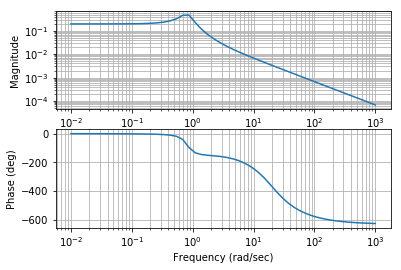

In [4]:
mag,phase,omega = control.bode(Gp)

### Specify Frequency Range

The default frequency range created by `bode` is often too wide. Use `numpy.logspace()` to Fortunately, it is possible to specify a desired set of frequencies at which to evaluate the Bode plot. The frequencies are always specified in radians per unit time.

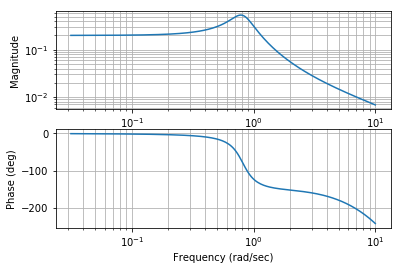

In [5]:
w = np.logspace(-1.5,1,200)
mag,phase,omega = control.bode(Gp,w)

### Setting Other Plotting Options

Bode plots can be customized with several key options as demonstrated in this cell. Note that setting `Hz = True` only changes the x-axis of the resulting bode plot, both input and output frequencies are still specified in radians per unit time.

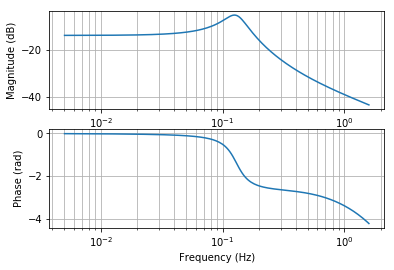

In [6]:
mag,phase,omega = control.bode(Gp,w,Hz=True,dB=True,deg=False)

## Adding Features to the Bode Plot

In addition to creating plots, the `bode` function returns numpy arrays containing the magnitude, phase, and frequency.  

### Crossover Frequency and Gain at Crossover

This data can be used to annotate or add features to a Bode plot. The following cell interpolates the phase data to find the crossover frequency, then interpolates the magnitude data to find the gain at crossover.

Crossover freq =  5.042527421277537  rad/sec
Gain at crossover =  0.014611811647525856


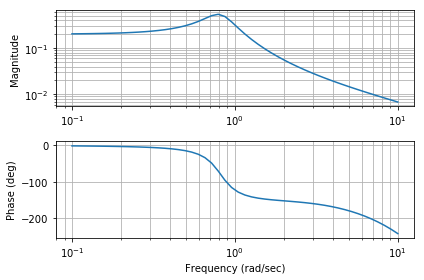

In [7]:
w = np.logspace(-1,1)
mag,phase,omega = control.bode(Gp,w);
plt.tight_layout()

# find the cross-over frequency and gain at cross-over
wc = np.interp(-180.0,np.flipud(phase),np.flipud(omega))
Kcu = np.interp(wc,omega,mag)

print('Crossover freq = ', wc, ' rad/sec')
print('Gain at crossover = ', Kcu)

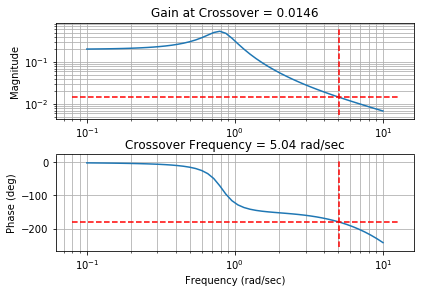

In [8]:
mag,phase,omega = control.bode(Gp,w);
plt.tight_layout()

ax1,ax2 = plt.gcf().axes     # get subplot axes

plt.sca(ax1)                 # magnitude plot
plt.plot(plt.xlim(),[Kcu,Kcu],'r--')
plt.plot([wc,wc],plt.ylim(),'r--')
plt.title("Gain at Crossover = {0:.3g}".format(Kcu))

plt.sca(ax2)                 # phase plot
plt.plot(plt.xlim(),[-180,-180],'r--')
plt.plot([wc,wc],plt.ylim(),'r--')
plt.title("Crossover Frequency = {0:.3g} rad/sec".format(wc))

# Exothermic Continuous Stirred Tank Reactor

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 


### Contents

* [1. Description](#Section01)
* [2. Reaction Kinetics](#Section02)
* [3. Model Equations and Parameter Values](#Section03)
* [4. Transient Behavior](#Section04)
* [5. Effect of Cooling Temperature](#Section05)
* [6. Interactive Simulation](#Section06)
* [7. Nullclines](#Section07)
* [8. Phase Plane Analysis](#Section08)
* [9. Suggested Exercises](#Section09)

<a id='Section00'></a>
## 1. Description

This example is intended as an introduction to the nonlinear dynamics of an exothermic continuous stirred-tank reactor. The example has been studied by countless researchers and students since the pioneering work of Amundson and Aris in the 1950's. The particular formulation and parameter values described below are taken from example 2.5 from Seborg, Edgar, Mellichamp and Doyle (SEMD).

![Exothermic Reactor](../images/408px-Agitated_vessel.png)

(Diagram By <a href="//commons.wikimedia.org/wiki/User:Daniele_Pugliesi" title="User:Daniele Pugliesi">Daniele Pugliesi</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="http://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=6915706">Link</a>)

<a id='Section01'></a>
## 2. Reaction Kinetics

We assume the kinetics are dominated by a single first order reaction

$$A \xrightarrow{kc_A}{} \text{Products}$$

The reaction rate per unit volume is modeled as the product $kc_A$ where $c_A$ is the concentration of $A$. The rate constant $k(T)$ is a increases with temperature following the Arrehenius law

$$k(t) = k_0 e^{-\frac{E_a}{RT}}$$

$E_a$ is the activation energy, $R$ is the gas constant, $T$ is absolute temperature, and $k_0$ is the pre-exponential factor. 

We can see the strong temperature dependence by plotting $k(T)$ versus temperature over typical operating conditions.

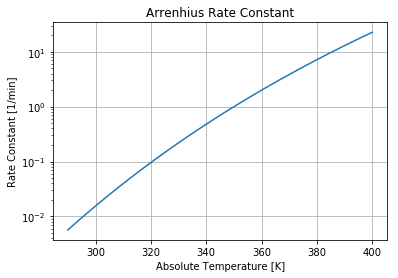

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min

T = np.linspace(290,400)

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/R/T)

plt.semilogy(T,k(T))
plt.xlabel('Absolute Temperature [K]')
plt.ylabel('Rate Constant [1/min]')
plt.title('Arrenhius Rate Constant')
plt.grid();

This graph shows the reaction rate changes by three orders of magnitude over the range of possible operating temperatures. Because an exothermic reaction releases heat faster at higher temperatures, there is a positive feedback that can potentially result in unstable process behavior.

<a id='Section03'></a>
## 3. Model Equations and Parameter Values

The model consists of mole and energy balances on the contents of the well-mixed reactor.

\begin{align*}
V\frac{dc_A}{dt} & = q(c_{Ai}-c_A)-Vkc_A \\
V\rho C_p\frac{dT}{dt} & = wC_p(T_i-T) + (-\Delta H_R)Vkc_A + UA(T_c-T)
\end{align*}

Normalizing the equations to isolate the time rates of change of $c_A$ and $T$ give

\begin{align*}
\frac{dc_A}{dt} & = \frac{q}{V}(c_{Ai} - c_A)- kc_A \\
\frac{dT}{dt} & = \frac{q}{V}(T_i - T) + \frac{-\Delta H_R}{\rho C_p}kc_A + \frac{UA}{V\rho C_p}(T_c - T)
\end{align*}

which are the equations that will be integrated below.

| Quantity | Symbol | Value | Units | Comments |
| :------- | :----: | :---: | :---- | |
| Activation Energy | $E_a$ | 72,750 | J/gmol | |
| Arrehnius pre-exponential | $k_0$ | 7.2 x 10<sup>10</sup> | 1/min | |
| Gas Constant | $R$ | 8.314 | J/gmol/K | |
| Reactor Volume | $V$ | 100 | liters | |
| Density | $\rho$ | 1000 | g/liter | |
| Heat Capacity | $C_p$ | 0.239 | J/g/K | |
| Enthalpy of Reaction | $\Delta H_r$ | -50,000 | J/gmol | |
| Heat Transfer Coefficient | $UA$ | 50,000 | J/min/K | |
| Feed flowrate | $q$ | 100 | liters/min | |
| Feed concentration | $c_{A,f}$ | 1.0 | gmol/liter | |
| Feed temperature | $T_f$ | 350 | K | |
| Initial concentration | $c_{A,0}$ | 0.5 | gmol/liter | |
| Initial temperature | $T_0$ | 350 | K | |
| Coolant temperature | $T_c$ | 300 | K | Primary Manipulated Variable |



In [2]:
Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q = 100.0       # Flowrate [L/min]
cAi = 1.0       # Inlet feed concentration [mol/L]
Ti  = 350.0     # Inlet feed temperature [K]
cA0 = 0.5;      # Initial concentration [mol/L]
T0  = 350.0;    # Initial temperature [K]
Tc  = 300.0     # Coolant temperature [K]

def deriv(y,t):
    cA,T = y
    dcA = (q/V)*(cAi - cA) - k(T)*cA
    dT = (q/V)*(Ti - T) + (-dHr/rho/Cp)*k(T)*cA + (UA/V/rho/Cp)*(Tc-T)
    return [dcA,dT]

We first define a visualization function that will be reused in later simulations.

In [3]:
# visualization
def plotReactor(t,y):
    plt.subplot(1,2,1)
    plt.plot(t,y[:,0])
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [gmol/liter]')
    plt.title('Concentration')
    plt.ylim(0,1)

    plt.subplot(1,2,2)
    plt.plot(t,y[:,1])
    plt.xlabel('Time [min]')
    plt.ylabel('Temperature [K]');
    plt.title('Temperature')
    plt.ylim(300,450)
    plt.legend([Tc])

<a id='Section04'></a>
## 4. Transient Behavior

The first simulation assumes a cooling water temperature of 300 K. 

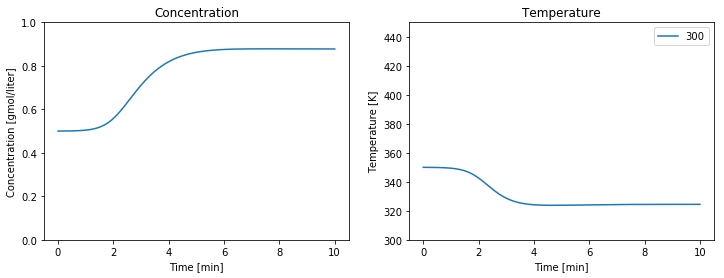

In [4]:
from scipy.integrate import odeint

Tc = 300
IC = [cA0,T0]
t = np.linspace(0,10.0,2000)
y = odeint(deriv,IC,t)

plt.figure(figsize=(12,4))
plotReactor(t,y);

<a id='Section05'></a>
## 5. Effect of Cooling Temperature

The primary means of controlling the reactoris through temperature of the cooling water jacket. The next calculations explore the effect of plus or minus change of 5 K in cooling water temperature on reactor behavior. These simulations reproduce the behavior shown in Example 2.5 SEMD.

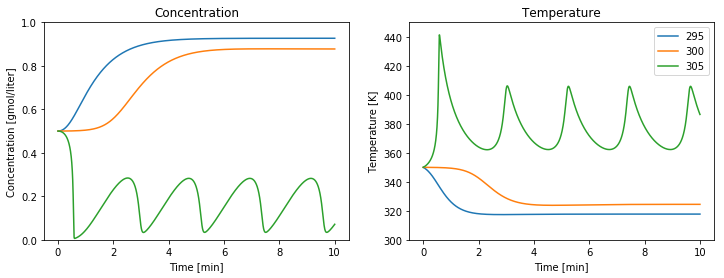

In [5]:
Tlist = [295,300,305]

plt.figure(figsize=(12,4))
for Tc in Tlist:
    y = odeint(deriv,IC,t)
    plotReactor(t,y)

plt.legend(Tlist);

<a id='Section01'></a>
## 6. Interactive Simulation

Executing the following cell provides an interactive tool for exploring the relationship of cooling temperature with reactor behavior.  Use it to observe a thermal runaway, sustained osciallations, and low and high conversion steady states.

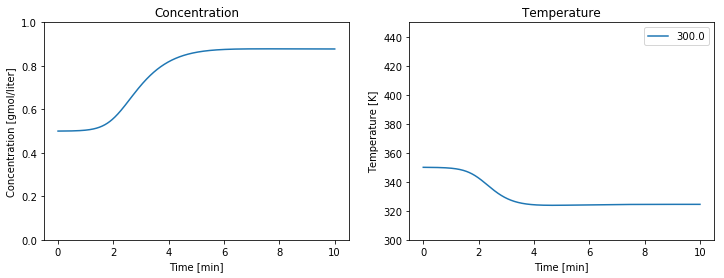

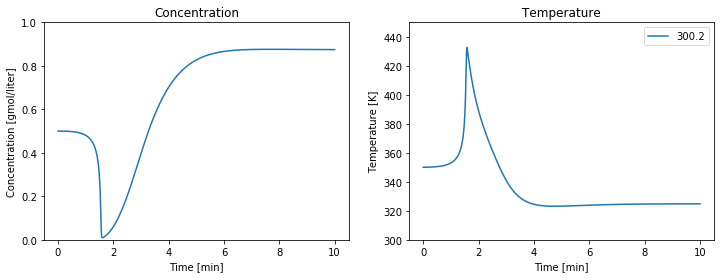

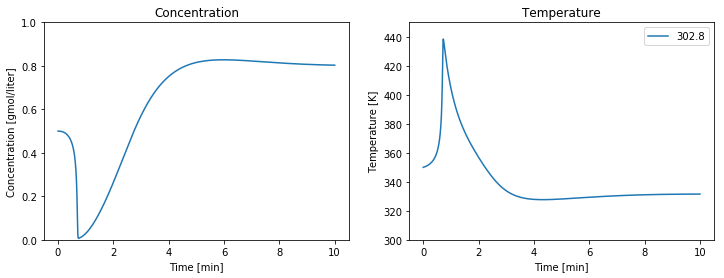

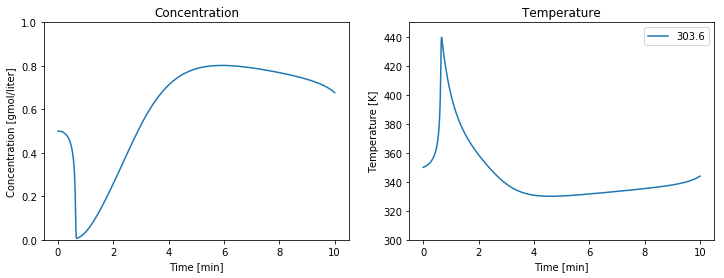

In [6]:
from ipywidgets import interact

def sim(Tcooling):
    global Tc
    Tc = Tcooling
    y = odeint(deriv,IC,t)

    plt.figure(figsize=(12,4))
    plotReactor(t,y)
    plt.legend([Tc])
    
interact(sim,Tcooling = (290.0,310.0));

<a id='Section07'></a>
## 7. Nullclines

The nullclines of two first-order differential equations are points in the phase plane for which one or the other of the two derivatives are zero.

\begin{align*}
V\frac{dc_A}{dt} & = 0 = q(c_{Ai}-c_A)-Vkc_A \\
V\rho C_p\frac{dT}{dt} & = 0 = wC_p(T_i-T) + (-\Delta H_R)Vkc_A + UA(T_c-T)
\end{align*}

The intersection of the nullclines correspond to steady states. The relative positions of the nullclines provide valuable insight into the dynamics of a nonlinear system.

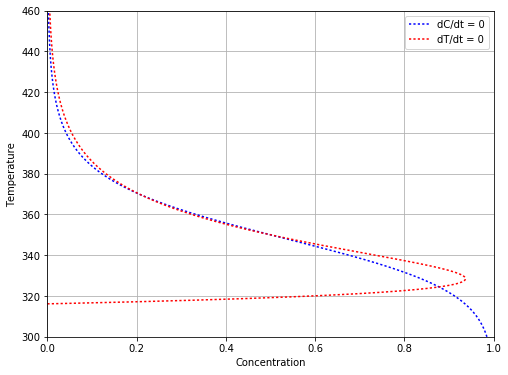

In [16]:
# plot nullclines

def plotNullclines():
    T = np.linspace(300.0,460.0,1000)
    
    plt.plot((q/V)*cAi/((q/V) + k(T)),T,'b:')
    plt.plot(((q/V)*(Ti-T) + (UA/V/rho/Cp)*(Tc-T))/((dHr/rho/Cp)*k(T)),T,'r:')
    plt.xlim(0,1)
    plt.ylim(300,460)
    plt.grid()
    plt.legend(['dC/dt = 0','dT/dt = 0'])
    plt.xlabel('Concentration')
    plt.ylabel('Temperature')
    
plt.figure(figsize=(8,6))
plotNullclines()

<a id='Section08'></a>
## 8. Phase Plane Analysis

The final analysis is display the simulation in both time and phase plane coordinates. The following cell produces a 

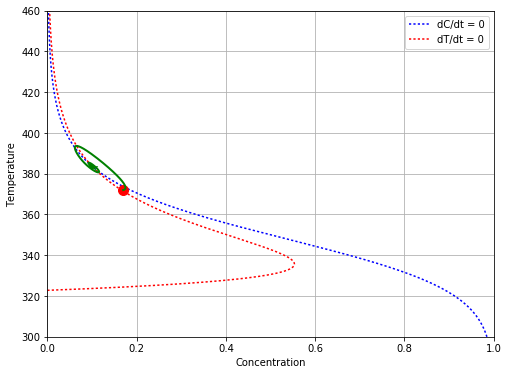

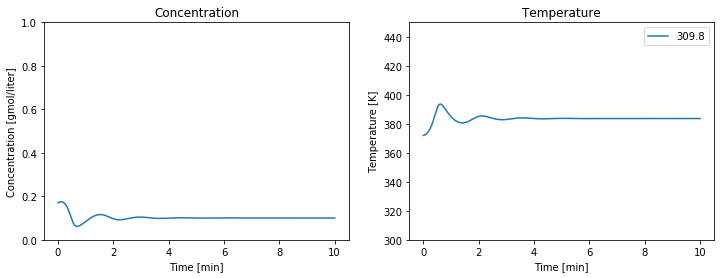

In [17]:
def plotPhase(t,y):
    plt.plot(y[0,0],y[0,1],'r.',ms=20)
    plt.plot(y[:,0],y[:,1],'g',lw=2)
    plt.annotate('',xy=y[-2,:],xytext=y[-1,:],
                 arrowprops=dict(arrowstyle='->',color='g'))

def phase(Tcooling=300,cinitial=0.5,Tinitial=350):
    # put slider value into the global Tc
    global Tc
    Tc = Tcooling
    y = odeint(deriv,[cinitial,Tinitial],t)

    plt.figure(figsize=(8,6))
    plotNullclines()
    plotPhase(t,y)
    
    plt.figure(figsize=(12,4))
    plotReactor(t,y)

interact(phase,Tcooling = (290.0,310.0), cinitial=(0,1,.01), Tinitial=(300,400,1))

<a id='Section01'></a>
## Suggested Exercises

**1.** Using the interactive simulation, adjust the cooling temperature over the range of values from 290K to 310K, identify the cooling water temperatures at which you observe a qualitative difference in system behavior. Try to identify the following behaviors:

* Stable steady state
* Oscillatory steady state
* The onset of a thermal runaway condition

**2.** Repeat the exercise using the phase plane simulation. Describe the underlying behaviors in light of the nullclines.

**3.** Assume the reactor is start up with a tank of reactant feed with a concentration $c_A = 1$. What is the maximum initial temperature that would avoid thermal runaway during reactor startup?

# Fed-Batch Bioreactor

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 


## Model Development

Mass balances for a fed-batch bioreactor are given by

$$\begin{align*}
\frac{d(XV)}{dt} & = V r_g(X,S) \\
\frac{d(PV)}{dt} & = V r_P(X,S) \\
\frac{d(SV)}{dt} & = F S_f - \frac{1}{Y_{X/S}}V r_g(X,S)
\end{align*}$$

where $X$ is cell concentration, $P$ is product concentration, and $S$ is substrate concentration, all given in units of grams/liter. The reactor is fed with fresh substrate at concentration $S_f$ and flowrate $F(t)$ in liters per hour. The volume (in liters) is therefore changing 

$$\frac{dV}{dt} = F(t)$$

Rate $r_g(X,S)$ is the production of fresh cell biomass in units of grams/liter/hr. The cell specific growth is expressed as

$$r_g(X,S) = \mu(S)X$$

where $\mu(S)$ is the cell specific growth rate. In the Monod model, the specific growth rate is a function of substrate concentration given by

$$\mu(S) = \mu_{max}\frac{S}{K_S + S}$$

where $\mu_{max}$ is the maximum specific growth rate, and $K_S$ is the half saturation constant which is the value of $S$ for which $\mu = \frac{1}{2}\mu_{max}$.

For this model, the product is assumed to be a by-product of cell growth

$$r_P(X,S) = Y_{P/X}r_g(X,S)$$

where $Y_{P/X}$ is the product yield coefficient defined as

$$Y_{P/X} = \frac{\mbox{mass of product formed}}{\mbox{mass of new cells formed}}$$

The model further assumes that substrate is consumed is proportion to the mass of new cells formed where $Y_{X/S}$ is the yield coefficient for new cells

$$Y_{P/X} = \frac{\mbox{mass of new cells formed}}{\mbox{mass of substrate consumed}}$$

### Dilution Effect

One aspect of the fed-batch model is that volume is not constant, therefore the cell, product, and substrate concentrations are subject to a dilution effect.  Mathematically, the chain rule of differential calculus provides a means to recast the state of model in terms of the intensive concentration variables $X$, $P$, and $S$, and extensive volume $V$.

$$\begin{align*}
\frac{d(XV)}{dt} & = V\frac{dX}{dt} + X\frac{dV}{dt} = V\frac{dX}{dt} + F(t)X \\
\frac{d(PV)}{dt} & = V\frac{dP}{dt} + P\frac{dV}{dt} = V\frac{dP}{dt} + F(t)P \\
\frac{d(SV)}{dt} & = V\frac{dS}{dt} + S\frac{dV}{dt} = V\frac{dS}{dt} + F(t)S
\end{align*}$$

Rearranging and substituting into the mass balances gives

$$\begin{align*}
\frac{dX}{dt} & = - \frac{F(t)}{V}X + r_g(X,S)  \\
\frac{dP}{dt} & = - \frac{F(t)}{V}P + r_P(X,S) \\
\frac{dS}{dt} & = \frac{F(t)}{V}(S_f - S) - \frac{1}{Y_{X/S}}r_g(X,S) \\
\frac{dV}{dt} & = F(t)
\end{align*}$$


## Python Implementation

In [83]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# parameter values

mumax = 0.20      # 1/hour
Ks = 1.00         # g/liter
Yxs = 0.5         # g/g
Ypx = 0.2         # g/g
Sf = 10.0         # g/liter

# inlet flowrate

def F(t):
    return 0.05

# reaction rates

def mu(S):
    return mumax*S/(Ks + S)

def Rg(X,S):
    return mu(S)*X
    
def Rp(X,S):
    return Ypx*Rg(X,S)

# differential equations

def xdot(x,t):
    X,P,S,V = x
    dX = -F(t)*X/V + Rg(X,S)
    dP = -F(t)*P/V + Rp(X,S)
    dS = F(t)*(Sf-S)/V - Rg(X,S)/Yxs
    dV = F(t)
    return [dX,dP,dS,dV]

## Simulation

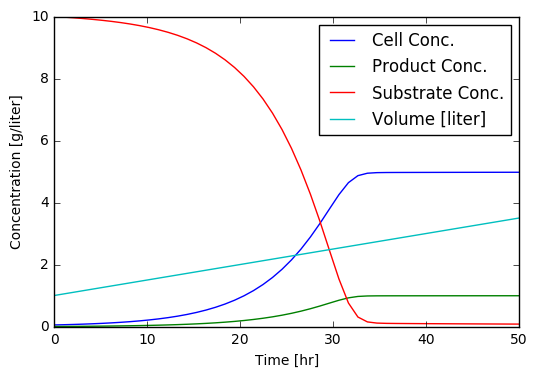

In [84]:
IC = [0.05, 0.0, 10.0, 1.0]

t = np.linspace(0,50)
sol = odeint(xdot,IC,t)
X,P,S,V = sol.transpose()

plt.plot(t,X)
plt.plot(t,P)
plt.plot(t,S)
plt.plot(t,V)

plt.xlabel('Time [hr]')
plt.ylabel('Concentration [g/liter]')
plt.legend(['Cell Conc.',
            'Product Conc.',
            'Substrate Conc.',
            'Volume [liter]'])

# Fitting First Order plus Time Delay (FOPTD) to Step Response Data

by Jeffrey Kantor (jeff at nd.edu). The latest version of this notebook is available at https://github.com/jckantor/CBE30338.


### Summary

Linear first order plus time delay (FOPTD) models are often good approximations to process dynamics for process control applications. This notebook demonstrates the fitting of FOPTD models to step response data.

### Initializations

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control
from scipy.optimize import minimize

## First Order plus Time Delay Models

### First Order Models

A linear first-order plus time-delay model is a good approximation for many process control applications. Assume the manipulated process input, $u$, and measured process output, $y$, are initially at steady-state $u_0, y_0$.  

Without loss of generality, the response of a linear first-order system without time-delay can be written as a differential equation

$$\tau\frac{d(y-y_0)}{dt} + (y-y_0) = K(u-u_0)$$

or

$$\tau\frac{dy}{dt} + (y-y_0) = K(u-u_0)$$

At time $t_0$, the input $u$ is changed to a new constant value $u_\infty$. Provided the system is stable (i.e, $\tau \geq 0$), the new steady state value of $y$ will be 

$$y_\infty = y_0 + K(u_\infty - u_0)$$


The solution to the differential equation can be written in a number of useful forms.

\begin{align*}
y(t) & = y_0 + K(u_\infty - u_0) (1 - e^{-(t-t_0)/\tau)}) \\
\\
& = y_0 + (y_\infty - y_0) (1 - e^{-(t-t_0)/\tau)}) \\
\\
& = y_\infty + (y_0 - y_\infty)e^{-(t-t_0)/\tau)}
\end{align*}

### Time Delay

Chemical processes are frequently encumbered with time delays associated with the transport of materials, chemical measurement, or simply sluggish response to control inputs. A pure time delay is modeled by a single parameter, $\tau_d$, such that 

$$y(t) = u(t-\tau_d)$$

### First Order plus Time Delay (FOPTD) 

If we add the time delay feature to the first order process described above, then

\begin{align*}
y(t) & = y_0 + K(u_\infty - u_0) (1 - e^{-(t-\tau_d - t_0)/\tau)}) \\
\\
& = y_0 + (y_\infty - y_0) (1 - e^{-(t-\tau_d-t_0)/\tau)}) \\
\\
& = y_\infty + (y_0 - y_\infty)e^{-(t-\tau_d-t_0)/\tau)}
\end{align*}

### Visualization

First we write a function to compute the response of a first order system with time delay to a unit step input where $u_0 = 0$ and $u_\infty = 1$.  

In [2]:
def foptd(t, K=1, tau=1, tau_d=0):
    tau_d = max(0,tau_d)
    tau = max(0,tau)
    return np.array([K*(1-np.exp(-(t-tau_d)/tau)) if t >= tau_d else 0 for t in t])

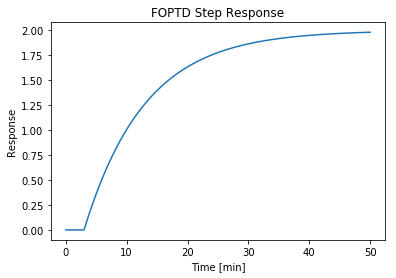

In [3]:
t = np.linspace(0,50,200)
tau = 10
tau_delay = 3
K = 2

y = foptd(t,K,tau,tau_delay)
plt.plot(t,y)
plt.xlabel('Time [min]')
plt.ylabel('Response')
plt.title('FOPTD Step Response')

## Fitting an FOPTD model

### Sample Problem Statement

A distillation column is initially at steady state where the cooling water flow to the condensor is 110 kg/hr and the vapor phase mole fraction of the volatile compound is 0.87.  At t = 60 min, the steam flow is raised to 120 kg/hr. The vapor phase mole fraction increases as shown in the following chart. 

The problem task to fit a FOPTD model to this experimental result.

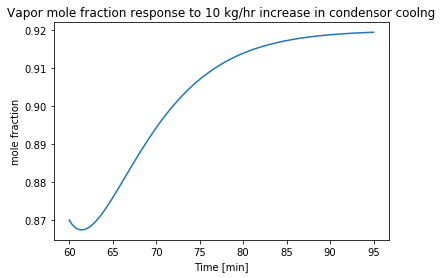

In [4]:
# create the hypothetical problem data
delta_y,t = control.step(0.05*control.tf([-2, 1],[25, 10, 1]))
y = 0.87 + delta_y
t = t + 60

plt.plot(t,y)
plt.xlabel('Time [min]')
plt.ylabel('mole fraction')
plt.title('Vapor mole fraction response to 10 kg/hr increase in condensor coolng')

### Step 1. Shift and scale the experimental data to correspond to a unit step input at time t =  0.

The first step is to scale the experimental data to fit the framework of an FOPTD model. This generally involves three steps:

* Shift the time scale to t = 0 corresponds to the start of the experiment.

$$ t_s = t - t_0$$

* Shift the response so y = 0 is the initial steady state
* Rescale the response to a unit change in input

$$ y_s = \frac{y(t) - y_0}{u_\infty - u_0}$$

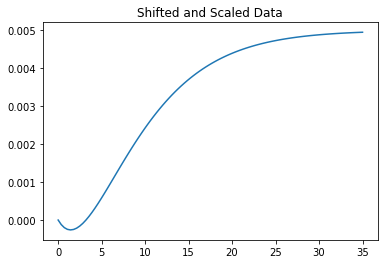

In [5]:
ts = t - t[0]
ys = (y - y[0])/(120 - 110)

plt.plot(ts, ys)
plt.title('Shifted and Scaled Data')

### Step 2. Create a function to compute the response of an FOPTD model.

For a given list of times $t$ and parameters $K$, $\tau$, and $\tau_d$, the `foptd` returns the response of an FOPTD system to a unit change in input at $t = 0$.

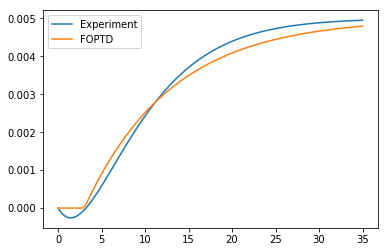

In [6]:
def foptd(t, K=1, tau=1, tau_d=0):
    tau_d = max(0,tau_d)
    tau = max(0,tau)
    return np.array([K*(1-np.exp(-(t-tau_d)/tau)) if t >= tau_d else 0 for t in t])

z = foptd(ts, 0.005, 10, 3)
plt.plot(ts,ys,ts,z)
plt.legend(['Experiment','FOPTD'])

### Step 3. Create a function to measure the error between an FOPTD model and the experimental data.

Let's called the step response of the fitted model to be $\hat{y}_s$. We seek to minimize

$$\min_{K,\tau,\tau_d} \int_0^T \|\hat{y}_s - y_s\|\,dt$$

for some suitable norm $\|\cdot\|$.  A common choice of norm for process control is the absolute value of the difference called Integral Absolute Error (IAE)

$$\text{IAE} = \min_{K,\tau,\tau_d} \int_0^T |\hat{y}_s - y_s|\,dt$$

The advantage of IAE over other choices of norms is that it tends to be more robust with respect to larger errors.

In [7]:
def err(X,t,y):
    K,tau,tau_d = X
    z = foptd(t,K,tau,tau_d)
    iae = sum(abs(z-y))*(max(t)-min(t))/len(t)
    return iae

X = [0.005,10,3]
err(X,ts,ys)

0.0077632135835474644

### Step 4. Use scipy.optimize.minimize() to find the best fitting FOPTD model.

In [8]:
K,tau,tau_d = minimize(err,X,args=(ts,ys)).x

print("K = {:.5f}".format(K))
print("tau = {:.2f}".format(tau))
print("tau_d = {:.2f}".format(tau_d))

K = 0.00512
tau = 8.04
tau_d = 4.61


### Step 5. Rescale FOPTD output and compare to experimental data.

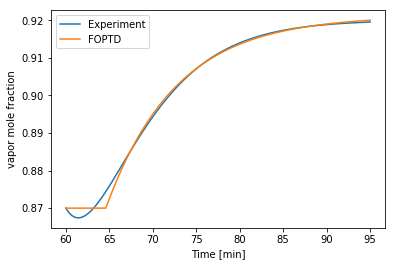

In [9]:
z = foptd(ts,K,tau,tau_d)
ypred = y[0] + z*(120 - 110)

plt.plot(t,y,t,ypred)
plt.xlabel('Time [min]')
plt.ylabel('vapor mole fraction')
plt.legend(['Experiment','FOPTD'])

# Fitting a Linear Model to the Step Response of a Gravity Drained Tank

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

### Summary

In the example we show how to fit the step response of a nonlinear system, a gravity drained tank, to a first order linear system.

## Mass Balance for Tank with Constant Cross-Sectional Area

For a tank with constant cross-sectional area, such as a cylindrical or rectangular tank, the liquid height is described by a differential equation

$$A\frac{dh}{dt} = q_{in}(t) - q_{out}(t)$$

where $q_{out}$ is a function of liquid height. Torricelli's law tells the outlet flow from the tank is proportional to square root of the liquid height

$$ q_{out}(h) = C_v\sqrt{h} $$

Dividing by area we obtain a nonlinear ordinary differential equation 

$$ \frac{dh}{dt} = - \frac{C_V}{A}\sqrt{h} + \frac{1}{A}q_{in}(t) $$

in our standard form where the LHS derivative appears with a constant coefficient of 1.

## Nonlinear Step Response

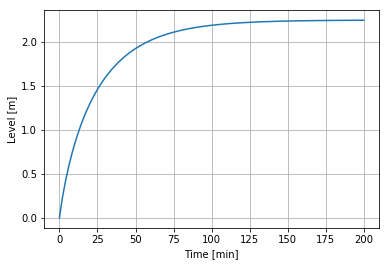

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

Cv  = 0.1     # Outlet valve constant [cubic meters/min/meter^1/2]
A   = 1.0     # Tank area [meter^2]

# inlet flow rate in cubic meters/min
def qin(t):
    return 0.15

def deriv(h,t):
    return qin(t)/A - Cv*np.sqrt(h)/A

IC = [0.0]
t = np.linspace(0,200,101)
h = odeint(deriv,IC,t)

plt.plot(t,h)

plt.xlabel('Time [min]')
plt.ylabel('Level [m]')
plt.grid();

## Linear Approximation of the Step Response

The step response of the gravity drained to a change in flowrate looks similar to the step response of a firat order linear system. Let's try a linear approximation

$$\tau\frac{dx}{dt} + x = Ku$$

which has a step response solution that can be written

$$x(t) = x_{ss} + (x_0 - x_{ss})\exp(-t/\tau)$$

where $x_{ss} = Ku_{ss}$. There are two parameters, $K$ and $\tau$, which we need to estimate in order to fit the linear approximation to the nonlinear simulation results computed above.

### Fit for $K$

The steady state gain $K$ of the linear system is given by

$$ K = \frac{x_{ss} - x(0)}{u_{ss} - u_0}$$

where $u_0$ is the initial input, $u_{ss}$ is the steady-state input, and $x_0$ and $x_{ss}$ are corresponding values of the state variable. In the case of liquid level, $h\sim x$ and $q_{in}\sim u$, therefore an estimate of $K$ is 

$$ K = \frac{h_{ss} - h_0}{q_{in,ss} - q_{in,0}}$$

In [2]:
q0,h0 = 0,0            # initial conditions
qss = qin(t[-1])       # final input
hss = h[-1]            # python way to get the last element in a list

K = (hss-h0)/(qss-q0)  # step change in output divided by step change in input
print('Steady-State Gain is approximately = ', K)

Steady-State Gain is approximately =  [ 14.98595148]


### Fit for $\tau$

From the formula for the solution of a first-order linear equation with constant input,

$$\frac{x_{ss} - x(t)}{x_{ss} - x_0} = \exp(-t/\tau) \qquad \implies \qquad \tau = \frac{-t}{\ln\frac{x_{ss} - x(t)}{x_{ss} - x_0}}$$

We pick one point representative of the transient portion of the nonlinear response. In this case the response at $t = 25$ minutes accounts for $\approx$60% of the ultimate response, so we choose point as a representative point.

In [3]:
k = sum(t<25)        # find index in t corresponding to 25 minutes
tk = t[k]
hk = h[k]

tau = -tk/np.log((hss-hk)/(hss-h0))
print('Estimated time constant is ', tau)

Estimated time constant is  [ 23.92271579]


### Comparing the linear approximation to the nonlinear simulation

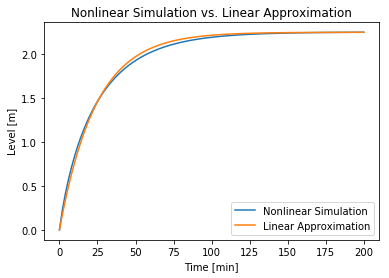

In [4]:
u0 = q0
uss = qss

xss = K*(uss - u0)
xpred = xss - xss*np.exp(-t/tau)

plt.plot(t,h)
plt.plot(t,xpred)
plt.legend(['Nonlinear Simulation','Linear Approximation'])
plt.xlabel('Time [min]')
plt.ylabel('Level [m]')
plt.title('Nonlinear Simulation vs. Linear Approximation');

# Getting Started with CVXPY

## Installation of CVXPY

    conda install -c https://conda.binstar.org/cvxgrp cvxpy

## Example - Solving a System of Equations

In [1]:
import cvxpy as cvx
import numpy as np

# Create two scalar optimization variables.
x = cvx.Variable()
y = cvx.Variable()

# Create two constraints.
constraints = [3*x + 4*y == 26,
               2*x - 3*y == -11]

# Form objective.
obj = cvx.Minimize(cvx.norm(x+y))

# Form and solve problem.
prob = cvx.Problem(obj,constraints)
prob.solve()  # Returns the optimal value

# Display the solution

print("Status:", prob.status)
print("Objective Value:", prob.value)
print("Solution:", x.value, y.value)

Status: optimal
Objective Value: 6.999999995683918
Solution: 2.0 5.0


# Getting Started with Python and Jupyter Notebooks

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338).  

### Summary

The purpose of this [Jupyter Notebook](http://jupyter.org/) is to get you started using Python and Jupyter Notebooks for routine chemical engineering calculations. This introduction assumes this is your first exposure to Python or Jupyter notebooks.

* [Step 0: Gain Executable Access to Jupyter Notebooks](#step0)
  * Using Jupyter/Python in the Cloud
  * Vocareum
  * Installing Jupyter/Python on your laptop
* [Step 1: Start a Jupyter Notebook Session](#step1)
* [Step 2: Simple Calculations with Python](#step2)
  * Basic Arithmetic Operations
  * Python Libraries
  * Working with Lists
  * Working with Dictionaries
  * Plotting with Matplotlib
  * Solve Equations with Sympy Library
* [Step 3: Where to Learn More](#step3)

<a id="step0"></a>
## Step 0: Gain Executable Access to Jupyter Notebooks

Jupyter notebooks are documents that can be viewed and executed inside any modern web browser. Since you're reading this notebook, you already know how to view a Jupyter notebook. The next step is to learn how to execute computations that may be embedded in a Jupyter notebook.

To execute Python code in a notebook you will need access to a Python kernal. A kernal is simply a program that runs in the background, maintains workspace memory for variables and functions, and executes Python code.  The kernal can be located on the same laptop as your web browser or located in an on-line cloud service. 

**Important Note Regarding Versions** There are two versions of Python in widespread use. Version 2.7 released in 2010, which was the last release of the 2.x series. Version 3.5 is the most recent release of the 3.x series which represents the future direction of language. It has taken years for the major scientific libraries to complete the transition from 2.x to 3.x, but it is now safe to recommend Python 3.x for widespread use. So for this course be sure to use latest verstion, currently 3.6, of the Python language.

### Using Jupyter/Python in the Cloud

The easiest way to use Jupyter notebooks is to sign up for a free or paid account on a cloud-based service such as [Wakari.io](https://www.wakari.io/) or [SageMathCloud](https://cloud.sagemath.com/). You will need continuous internet connectivity to access your work, but the advantages are there is no software to install or maintain. All you need is a modern web browser on your laptop, Chromebook, tablet or other device. Note that the free services are generally heavily oversubscribed, so you should consider a paid account to assure access during prime hours.

There are also demonstration sites in the cloud, such as [tmpnb.org](https://tmpnb.org/). These start an interactive session where you can upload an existing notebook or create a new one from scratch. Though convenient, these sites are intended mainly for demonstration and generally quite overloaded. More significantly, there is no way to retain your work between sessions, and some python functionality is removed for security reasons.

### Vocareum

This course will use a cloud-based service [Vocareum](https://vocareum.com/) to provide on-line access to Jupyter notebooks and Python through the Sakai learn management system. Once you log into Sakai, you can access Vocareum directly and use it to complete and submit course assignments.

### Installing Jupyter/Python on your Laptop

For regular off-line use you should consider installing a Jupyter Notebook/Python environment directly on your laptop. This will provide you with reliable off-line access to a computational environment. This will also allow you to install additional code libraries to meet particular needs. 

Choosing this option will require an initial software installation and routine updates. For this course the recommended package is [Anaconda](https://store.continuum.io/cshop/anaconda/) available from [Continuum Analytics](http://continuum.io/). Downloading and installing the software is well documented and easy to follow. Allow about 10-30 minutes for the installation depending on your connection speed. 

After installing be sure to check for updates before proceeding further. With the Anaconda package this is done by executing the following two commands in a terminal window:

    > conda update conda
    > conda update anaconda

Anaconda includes an 'Anaconda Navigator' application that simplifies startup of the notebook environment and manage the update process.

<a id="step1"></a>
## Step 1: Start a Jupyter Notebook Session

If you are using a cloud-based service a Jupyter session will be started when you log on. 

If you have installed a Jupyter/Python distribution on your laptop then you can open a Jupyter session in one of two different ways:

* Use the Anaconda Navigator App, or 
* open a terminal window on your laptop and execute the following statement at the command line:

        > jupyter notebook

Either way, once you have opened a session you should see a browser window like this:

![Screen Shot Jupyter Session](../images/Screen Shot Jupyter Session.png)

At this point the browser displays a list of directories and files. You can navigate amoung the directories in the usual way by clicking on directory names or on the 'breadcrumbs' located just about the listing. 

Jupyter notebooks are simply files in a directory with a `.ipynb` suffix. They can be stored in any directory including Dropbox or Google Drive. Upload and create new Jupyter notebooks in the displayed directory using the appropriate buttons. Use the checkboxes to select items for other actions, such as to duplicate, to rename, or to delete notebooks and directories.

* select one of your existing notebooks to work on,
* start a new notebook by clicking on the `New Notebook` button, or 
* import a notebook from another directory by dragging it onto the list of notebooks.

An IPython notebook consists of cells that hold headings, text, or python code. The user interface is relatively self-explanatory. Take a few minutes now to open, rename, and save a new notebook. 

Here's a quick video overview of Jupyter notebooks.

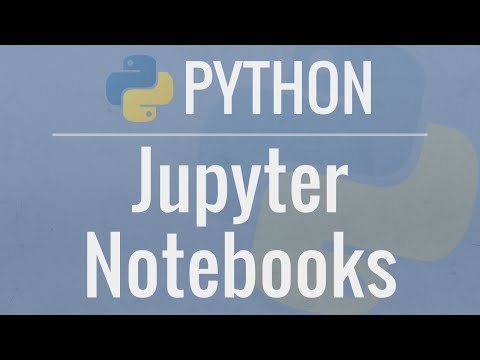

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("HW29067qVWk",560,315,rel=0)

<a id="step2"></a>
## Step 2: Simple Calculations with Python

Python is an elegant and modern language for programming and problem solving that has found increasing use by engineers and scientists.  In the next few cells we'll demonstrate some basic Python functionality.

### Basic Arithmetic Operations

Basic arithmetic operations are built into the Python langauge. Here are some examples. In particular, note that exponentiation is done with the \*\* operator.

In [2]:
a = 12
b = 2

print(a + b)
print(a**b)
print(a/b)

14
144
6.0


### Python Libraries

The Python language has only very basic operations. Most math functions are in various math libraries. The `numpy` library is convenient library.  This next cell shows how to import `numpy` with the prefix `np`, then use it to call a common mathematical functions.

In [3]:
import numpy as np

# mathematical constants
print(np.pi)
print(np.e)

# trignometric functions
angle = np.pi/4
print(np.sin(angle))
print(np.cos(angle))
print(np.tan(angle))

3.141592653589793
2.718281828459045
0.707106781187
0.707106781187
1.0


### Working with Lists

Lists are a versatile way of organizing your data in Python. Here are some examples, more can be found on [this Khan Academy video](http://youtu.be/zEyEC34MY1A).

In [4]:
xList = [1, 2, 3, 4]
xList

[1, 2, 3, 4]

Concatentation is the operation of joining one list to another. 

In [5]:
# Concatenation
x = [1, 2, 3, 4];
y = [5, 6, 7, 8];

x + y

[1, 2, 3, 4, 5, 6, 7, 8]

Sum a list of numbers

In [6]:
np.sum(x)

10

An element-by-element operation between two lists may be performed with 

In [7]:
print(np.add(x,y))
print(np.dot(x,y))

[ 6  8 10 12]
70


A for loop is a means for iterating over the elements of a list. The colon marks the start of code that will be executed for each element of a list. Indenting has meaning in Python. In this case, everything in the indented block will be executed on each iteration of the for loop. This example also demonstrates string formatting.

In [8]:
for x in xList:
    print("sin({0}) = {1:8.5f}".format(x,np.sin(x)))

sin(1) =  0.84147
sin(2) =  0.90930
sin(3) =  0.14112
sin(4) = -0.75680


### Working with Dictionaries

Dictionaries are useful for storing and retrieving data as key-value pairs.  For example, here is a short dictionary of molar masses. The keys are molecular formulas, and the values are the corresponding molar masses.

In [9]:
mw = {'CH4': 16.04, 'H2O': 18.02, 'O2':32.00, 'CO2': 44.01}
mw

{'CH4': 16.04, 'CO2': 44.01, 'H2O': 18.02, 'O2': 32.0}

We can a value to an existing dictionary.

In [10]:
mw['C8H18'] = 114.23
mw

{'C8H18': 114.23, 'CH4': 16.04, 'CO2': 44.01, 'H2O': 18.02, 'O2': 32.0}

We can retrieve a value from a dictionary.

In [11]:
mw['CH4']

16.04

A for loop is a useful means of interating over all key-value pairs of a dictionary.

In [12]:
for species in mw.keys():
    print("The molar mass of {:<s} is {:<7.2f}".format(species, mw[species]))

The molar mass of H2O is 18.02  
The molar mass of CH4 is 16.04  
The molar mass of C8H18 is 114.23 
The molar mass of O2 is 32.00  
The molar mass of CO2 is 44.01  


Dictionaries can be sorted by key or by value

In [13]:
for species in sorted(mw):
    print(" {:<8s}  {:>7.2f}".format(species, mw[species]))

 C8H18      114.23
 CH4         16.04
 CO2         44.01
 H2O         18.02
 O2          32.00


In [14]:
for species in sorted(mw, key = mw.get):
    print(" {:<8s}  {:>7.2f}".format(species, mw[species]))

 CH4         16.04
 H2O         18.02
 O2          32.00
 CO2         44.01
 C8H18      114.23


### Plotting with Matplotlib

Importing the `matplotlib.pyplot` library gives IPython notebooks plotting functionality very similar to Matlab's. Here are some examples using functions from the 

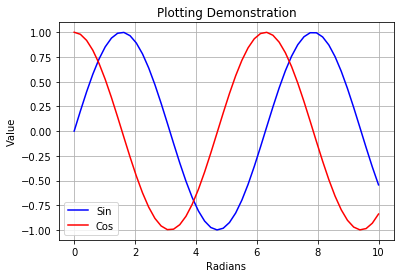

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0,10)
y = np.sin(x)
z = np.cos(x)

plt.plot(x,y,'b',x,z,'r')
plt.xlabel('Radians');
plt.ylabel('Value');
plt.title('Plotting Demonstration')
plt.legend(['Sin','Cos'])
plt.grid()

(-1.09972447591003,
 1.0979832896606587,
 -1.0992804688576738,
 1.0999657366122702)

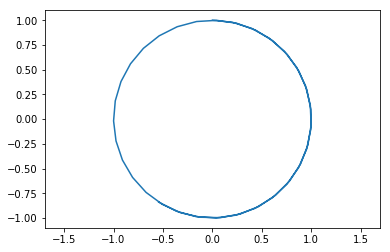

In [16]:
plt.plot(y,z)
plt.axis('equal')

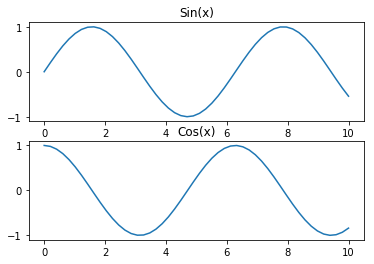

In [17]:
plt.subplot(2,1,1)
plt.plot(x,y)
plt.title('Sin(x)')

plt.subplot(2,1,2)
plt.plot(x,z)
plt.title('Cos(x)')

### Solve Equations using Sympy Library

One of the best features of Python is the ability to extend it's functionality by importing special purpose libraries of functions. Here we demonstrate the use of a symbolic algebra package [`Sympy`](http://sympy.org/en/index.html) for routine problem solving.

85521.9882637211/V


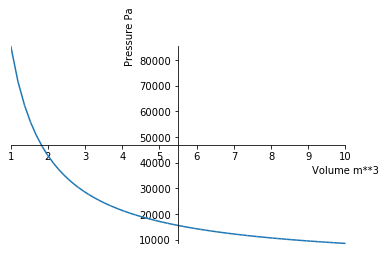

In [18]:
import sympy as sym

sym.var('P V n R T');

# Gas constant
R = 8.314        # J/K/gmol
R = R * 1000     # J/K/kgmol

# Moles of air
mAir = 1         # kg
mwAir = 28.97    # kg/kg-mol
n = mAir/mwAir   # kg-mol

# Temperature
T = 298

# Equation
eqn = sym.Eq(P*V,n*R*T)

# Solve for P 
f = sym.solve(eqn,P)
print(f[0])

# Use the sympy plot function to plot
sym.plot(f[0],(V,1,10),xlabel='Volume m**3',ylabel='Pressure Pa')

<a id="step3"></a>
## Step 3: Where to Learn More

Python offers a full range of programming language features, and there is a seemingly endless range of packages for scientific and engineering computations. Here are some suggestions on places you can go for more information on programming for engineering applications in Python.

__Introduction to Python for Science__

This excellent introduction to python is aimed at undergraduates in science with no programming experience. It is free and available at the following link.

* [Introduction to Python for Science](https://github.com/djpine/pyman)


__Tutorial Introduction to Python for Science and Engineering.__

The following text is licensed by the Hesburgh Library for use by Notre Dame students and faculty only. Please refer to the library's [acceptable use policy](http://library.nd.edu/eresources/access/acceptable_use.shtml). Others can find it at [Springer](http://www.springer.com/us/book/9783642549588) or [Amazon](http://www.amazon.com/Scientific-Programming-Computational-Science-Engineering/dp/3642549586/ref=dp_ob_title_bk). Resources for this book are available on [github](http://hplgit.github.io/scipro-primer/).

* [A Primer on Scientific Programming with Python (Fourth Edition)](http://link.springer.com.proxy.library.nd.edu/book/10.1007/978-3-642-54959-5) by Hans Petter Langtangen. Resources for this book are available on [github](http://hplgit.github.io/scipro-primer/).

pycse is a package of python functions, examples, and document prepared by John Kitchin at Carnegie Mellon University. It is a recommended for its coverage of topics relevant to chemical engineers, including a chapter on typical chemical engineering computations. 

* [pycse - Python Computations in Science and Engineering](https://github.com/jkitchin/pycse/blob/master/pycse.pdf) by John Kitchin at Carnegie Mellon. This is a link into the the [github repository for pycse](https://github.com/jkitchin/pycse), click on the `Raw` button to download the `.pdf` file.

__Interative learning and on-line tutorials__

* [Code Academy on Python](http://www.codecademy.com/tracks/python)
* [Khan Academy Videos on Python Programming](https://www.khanacademy.org/science/computer-science-subject/computer-science)
* [Python Tutorial](http://docs.python.org/2/tutorial/)
* [Think Python: How to Think Like a Computer Scientist](http://www.greenteapress.com/thinkpython/html/index.html)
* [Engineering with Python](http://www.engineeringwithpython.com/)

__Official documentation, examples, and galleries.__

* [Notebook Examples](https://github.com/ipython/ipython/tree/master/examples/notebooks)
* [Notebook Gallery](https://github.com/ipython/ipython/wiki/A-gallery-of-interesting-IPython-Notebooks)
* [Official Notebook Documentation](http://ipython.org/ipython-doc/stable/interactive/notebook.html)
* [Matplotlib](http://matplotlib.org/index.html) 

# Getting Started with Transfer Functions

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

The [Python Control Systems Library](https://github.com/python-control/python-control) provides basic tools for the analysis and design of linear feedback control systems. The library provides tools to specify transfer function and state space models, manipulate models using block diagram algebra, stability analysis, and perform time and frequency domain simulation.

The purpose of these notes is to provide a quick start with the Python Control Systems Library. Consult the [Python Control Systems Documentation](http://python-control.readthedocs.io/en/latest/) for more details.

#### Contents

1. [Installation](#1)
2. [Importing Libraries](#2)
3. [Transfer Functions](#3)
  * 3.1 [Step Response of a First Order Transfer Function](#31)
  * 3.2 [Transfer functions in Series](#32)
  * 3.3 [Second Order Transfer Functions](#33)


<a id=1></a>
## 1. Installation

The [Python Control Systems Library](https://github.com/python-control/python-control) is not, unfortunately, a standard part of most standard Python distributions. On most systems, the following commands will perform the required one-time installation of the necessary software.

In [1]:
!pip install slycot
!pip install control

<a id=2></a>
## 2. Library Usage

The control systems library is designed to work with a simplified syntax where libraries are imported without the standard prefixes.  

In [2]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import control.matlab as control

<a id=3></a>
## 3. Demonstration

<a id=31></a>
### 3.1 Step Response of Transfer Functions

The following cells demonstrate the use of two functions in the control systems library, `tf` and `step`. Suppose a signal $y(s)$ is related to an input $u(s)$ by the formula

$$y(s) = \underbrace{\frac{4.3}{3.2s + 1}}_{G(s)} u(s)$$

The transfer function

$$G(s) = \frac{4.3}{3.2 s + 1}$$

is represented in the control system libary using `tf(num,den)` where `num` and `den` list the coefficients of the numerator and denominator polynomials.  

In [3]:
G = control.tf([4.3],[3.2, 1])
print(G)


   4.3
---------
3.2 s + 1



The step response is created and plotted as

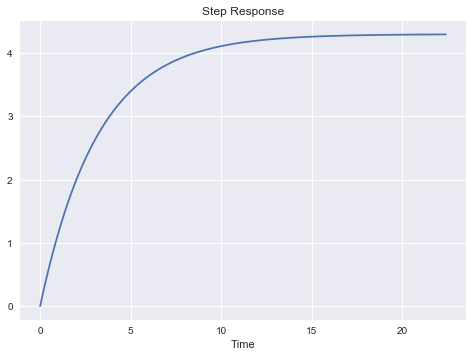

In [4]:
y,t = control.step(G)
plt.plot(t,y)
plt.xlabel('Time')
plt.title('Step Response')

<a id=32></a>
### 3.2 Transfer Functions in Series

Models for complex systems are generally constructed by combining models of simpler elements. Consider, for example, a serial connection of two transfer functions

$$ y_1(s) = G_1(s) u(s)$$

$$ y_2(s) = G_2(s) y_1(s)$$

which can be diagrammed as

$$u(s) \longrightarrow \boxed{\\G_1(s)} \stackrel{y_1(s)}{\longrightarrow} \boxed{\\G_2(s)} 
\longrightarrow y_2(s)$$

The serial composition of two transfer functions can be written

$$y_2(s) = \underbrace{G_2(s)G_1(s)}_{G(s)} u(s)$$

where the product $G(s) = G_2(s)G_1(s)$ represents the transfer function of the combined system. In terms of a block diagram

$$u(s) \longrightarrow \boxed{\\G_1(s)} \stackrel{y_1(s)}{\longrightarrow} \boxed{\\G_2(s)} 
\longrightarrow y_2(s) \qquad \implies \qquad
u(s) \longrightarrow \boxed{\\G_2(s)G_1(s)} \longrightarrow y_2(s)$$

The product $G(s) = G_2(s)G_1(s)$$ is computed by taking the products of the numerator and denominator polynomials, respectively.  For example, suppose

$$G_1(s) = \frac{12.3}{10 s + 1} \text{   and   }G_2(s) = \frac{4}{15 s + 1}$$

Then

\begin{align*}
G(s) & = G_2(s)G_1(s) \\
& = \frac{4}{15 s + 1} \times \frac{12.3}{10 s + 1} = \frac{4 \times 12.3}{(15s + 1)(10s + 1)} = \frac{49.2}{150 s^2 + 25s + 1}
\end{align*}

We can verify this calculation using the control systems library.


       49.2
------------------
150 s^2 + 25 s + 1



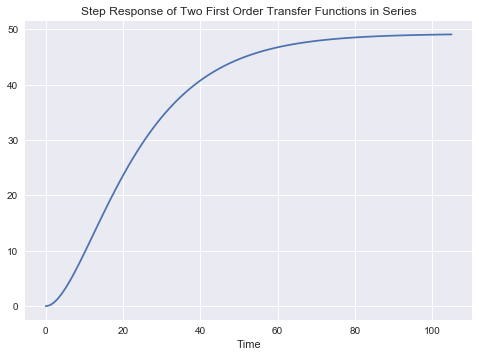

In [5]:
G1 = control.tf([12.3],[10,1])
G2 = control.tf([4],[15,1])

G = G2 * G1

print(G)

y,t = control.step(G)
plt.plot(t,y)
plt.xlabel('Time')
plt.title('Step Response of Two First Order Transfer Functions in Series')

<a id=33></a>
### 3.3 Second Order Transfer Functions

The control systems library is particularly helpful when working with second and higher order transfer functions. For

$$G(s) = \frac{3}{4s^2 + s + 1}$$




      3
-------------
4 s^2 + s + 1



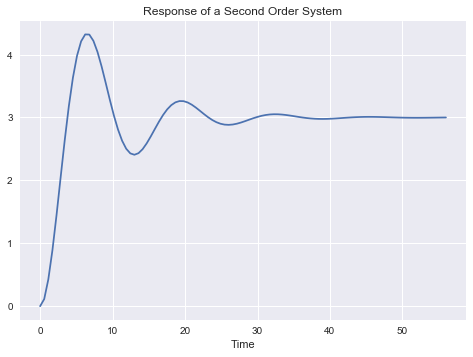

In [6]:
R = control.tf([3.],[4.,1.,1.])
print(R)

y,t = control.step(R)
plt.plot(t,y)
plt.xlabel('Time')
plt.title('Response of a Second Order System')

# Gravity Drained Tank

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

### Summary

In the example we study the problem of constructing nonlinear process model for the liquid level in a gravity drained tank.

## Torricelli's law

Torricelli's law states the velocity of an incompressible liquid stream exiting a liquid tank at level $h$ below the surface is 

$$v = \sqrt{2gh}$$ 

This is the same velocity as an object dropped from a height $h$. The derivation is straightforward. From Bernoulli's principle,

$$\frac{v^2}{2} + gh + \frac{P}{\rho} = \text{constant}$$

Applying this principle, compare a drop of water just below the surface of the water at distance $h$ above the exit, to a drop of water exiting the tank

$$gh + \frac{P_{atm}}{\rho} = \frac{v^2}{2} + \frac{P_{atm}}{\rho}$$

$$\implies v^2 = 2gh$$
$$\implies v = \sqrt{2gh}$$

Torricelli's law is an approximation that doesn't account for the effects of fluid viscosity, the specific flow geometry near the exit, or other flow non-idealities. Nevertheless it is a useful first approximation for flow from a tank.

## Mass Balance for Tank with Constant Cross-Sectional Area

For a tank with constant cross-sectional area, such as a cylindrical or rectangular tank, the liquid height is described by a differential equation

$$A\frac{dh}{dt} = q_{in}(t) - q_{out}(t)$$

where $q_{out}$ is a function of liquid height. Torricelli's law tells the outlet flow from the tank is proportional to square root of the liquid height

$$ q_{out}(h) = C_v\sqrt{h} $$

Dividing by area we obtain a nonlinear ordinary differential equation 

$$ \frac{dh}{dt} = - \frac{C_V}{A}\sqrt{h} + \frac{1}{A}q_{in}(t) $$

in our standard form where the LHS derivative appears with a constant coefficient of 1.

## Step-by-Step Approach to Nonlinear Simulation

### Step 1. Initialize Jupyter and Python

The first step in any Python application is to initialize graphics display (if you will be creating graphic output), and import any needed libraries.  

The `%matplotlib inline` is a command telling the Jupyter notebook to display any graphics inside this notebook.

We then import a standard graphics library (`matplotlib.pyplot`) that will be referred to with the prefix `plt`, a standard numerical library `numpy` that will be referred to with the prefix `np`, and the function `odeint` from the `scipy.integrate` library.  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

### Step 2. Define parameters

Provide values for all relevant parameters.  Use comments to describe the parameters and units.

In [2]:
Cv  = 0.1     # Outlet valve constant [cubic meters/min/meter^1/2]
A   = 1.0     # Tank area [meter^2]

### Step 3. Write Functions for the RHS of the Differential Equations

In [3]:
# inlet flow rate in cubic meters/min
def qin(t):
    return 0.15

def deriv(h,t):
    return qin(t)/A - Cv*np.sqrt(h)/A

### Step 4. Choose an Initial Condition, a Time Grid, and Integrate the Differential Equation

In [4]:
IC = [0.0]
t = np.linspace(0,200,101)
h = odeint(deriv,IC,t)

### Step 5. Visualize and Analyze Results

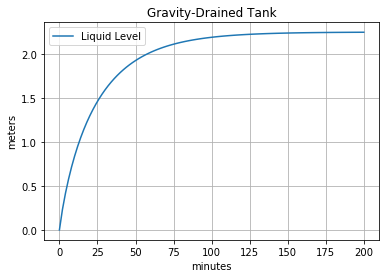

In [5]:
plt.plot(t,h)

plt.xlabel('minutes')
plt.ylabel('meters')
plt.title('Gravity-Drained Tank')
plt.legend(['Liquid Level'])
plt.grid();

### Step 6.  Adjust and Repeat as Needed

Rarely does a simulation provide you with the information you seek on the first try.  You will almost certainly need to revise parameter values, choose different time grids, and add visualization features to obtain the most informative results.

# Implementing PID Control in Nonlinear Simulations

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

A task common to many control projects is to simulate the PID control of a nonlinear process. This notebook demonstrates the simulation of PID for an exothermic stirred tank reactor where the objective is to control the reactor temperature through manipulation of cooling water through the reactor cooling jacket.

![Exothermic Reactor](../images/408px-Agitated_vessel.png)

(Diagram By <a href="//commons.wikimedia.org/wiki/User:Daniele_Pugliesi" title="User:Daniele Pugliesi">Daniele Pugliesi</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="http://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=6915706">Link</a>)

## Model

The model consists of nonlinear mole and energy balances on the contents of the well-mixed reactor.

\begin{align*}
V\frac{dc}{dt} & = q(c_f - c )-Vk(T)c \\
\rho C_p V\frac{dT}{dt} & = wC_p(T_f - T) + (-\Delta H_R)Vk(T)c + UA(T_c-T)
\end{align*}

where $c$ is the reactant concentration, $T$ is the reactor temperature, and $T_c$ is the cooling jacket temperature. The model is adapted from example 2.5 from Seborg, Edgar, Mellichamp and Doyle (SEMD), parameters defined and given in the table below.

The temperature in the cooling jacket is manipulated by the cooling jacket flow, $q_c$, and governed by the energy balance

\begin{align*}
\rho C_p V_c\frac{dT_c}{dt} & = \rho C_p q_c(T_{cf}-T_c) + UA(T - T_c)
\end{align*}

Normalizing the equations to isolate the time rates of change of $c$, $T$, and $T_c$ give

\begin{align*}
\frac{dc}{dt} & = \frac{q}{V}(c_f - c)- k(T)c\\
\frac{dT}{dt} & = \frac{q}{V}(T_i - T) + \frac{-\Delta H_R}{\rho C_p}k(T)c + \frac{UA}{\rho C_pV}(T_c - T)\\
\frac{dT_c}{dt} & = \frac{q_c}{V_c}(T_{cf}-T_c) + \frac{UA}{\rho C_pV_c}(T - T_c)
\end{align*}

These are the equations that will be integrated below.

| Quantity | Symbol | Value | Units | Comments |
| :------- | :----: | :---: | :---- | |
| Activation Energy | $E_a$ | 72,750 | J/gmol | |
| Arrehnius pre-exponential | $k_0$ | 7.2 x 10<sup>10</sup> | 1/min | |
| Gas Constant | $R$ | 8.314 | J/gmol/K | |
| Reactor Volume | $V$ | 100 | liters | |
| Density | $\rho$ | 1000 | g/liter | |
| Heat Capacity | $C_p$ | 0.239 | J/g/K | |
| Enthalpy of Reaction | $\Delta H_r$ | -50,000 | J/gmol | |
| Heat Transfer Coefficient | $UA$ | 50,000 | J/min/K | |
| Feed flowrate | $q$ | 100 | liters/min | |
| Feed concentration | $c_{A,f}$ | 1.0 | gmol/liter | |
| Feed temperature | $T_f$ | 350 | K | |
| Initial concentration | $c_{A,0}$ | 0.5 | gmol/liter | |
| Initial temperature | $T_0$ | 350 | K | |
| Coolant feed temperature | $T_{cf}$ | 300 | K |  |
| Nominal coolant flowrate | $q_c$ | 50 | L/min | primary manipulated variable |
| Cooling jacket volume | $V_c$ | 20 | liters | |

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import seaborn as sns
sns.set_context('talk')

Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q = 100.0       # Flowrate [L/min]
Cf = 1.0        # Inlet feed concentration [mol/L]
Tf  = 300.0     # Inlet feed temperature [K]
C0 = 0.5        # Initial concentration [mol/L]
T0  = 350.0;    # Initial temperature [K]
Tcf = 300.0     # Coolant feed temperature [K]
qc = 50.0       # Nominal coolant flowrate [L/min]
Vc = 20.0       # Cooling jacket volume

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/R/T)

def deriv(X,t):
    C,T,Tc = X
    dC = (q/V)*(Cf - C) - k(T)*C
    dT = (q/V)*(Tf - T) + (-dHr/rho/Cp)*k(T)*C + (UA/V/rho/Cp)*(Tc - T)
    dTc = (qc/Vc)*(Tcf - Tc) + (UA/Vc/rho/Cp)*(T - Tc)
    return [dC,dT,dTc]

## Simulation 1. Same Initial Condition, different values of $q_c$

The given reaction is highly exothermic. If operated without cooling, the reactor will reach an operating temperature of 500K which leads to significant pressurization, a potentially hazardous condition, and possible product degradation. 

The purpose of this first simulation is to determine the cooling water flowrate necessary to maintain the reactor temperature at an acceptable value. This simulation shows the effect of the cooling water flowrate, $q_c$, on the steady state concentration and temperature of the reactor.  We use the scipy.integrate function `odeint` to create a solution of the differential equations for entire time period.

In [2]:
# visualization
def plotReactor(t,X):
    plt.subplot(1,2,1)
    plt.plot(t,X[:,0])
    plt.xlabel('Time [min]')
    plt.ylabel('gmol/liter')
    plt.title('Reactor Concentration')
    plt.ylim(0,1)

    plt.subplot(1,2,2)
    plt.plot(t,X[:,1])
    plt.xlabel('Time [min]')
    plt.ylabel('Kelvin');
    plt.title('Reactor Temperature')
    plt.ylim(300,520)

Once the visualization code has been established, the actual simulation is straightforward.

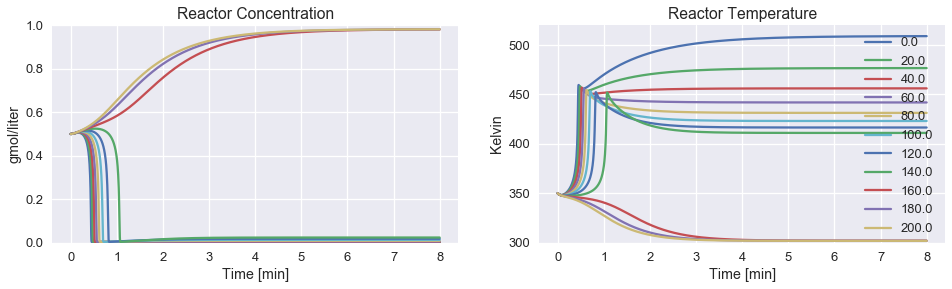

In [3]:
IC = [C0,T0,Tcf]                        # initial condition
t = np.linspace(0,8.0,2000)             # simulation time grid

qList = np.linspace(0,200,11)

plt.figure(figsize=(16,4))              # setup figure 
for qc in qList:                        # for each flowrate q_c
    X = odeint(deriv,IC,t)              # perform simulation
    plotReactor(t,X)                    # plot the results
    
plt.legend(qList)

The results clearly show a strongly nonlinear behavior for cooling water flowrates in the range from 140 to 160 liters per minute. Here we expand on that range to better understand what is going on.

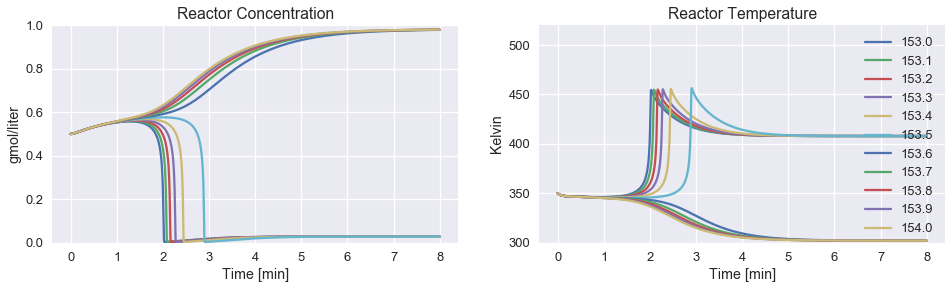

In [4]:
IC = [C0,T0,Tcf]                        # initial condition
t = np.linspace(0,8.0,2000)             # simulation time grid

qList = np.linspace(153,154,11)

plt.figure(figsize=(16,4))              # setup figure 
for qc in qList:                        # for each flowrate q_c
    X = odeint(deriv,IC,t)              # perform simulation
    plotReactor(t,X)                    # plot the results
    
plt.legend(qList)

There's a clear bifurcation when operated without feedback control. At cooling flowrates less than 153.7 liters/minute, the reactor goes to a high conversion steady state with greater than 95% conversion and a reactor temperature higher than about 410K. Coolant flowrates less than 153.8 liters/minute result in uneconomic operation at low conversion.

For the remainder of this notebook, our objective will be to achieve stable operation of the reactor at a high conversion steady state but with an operating temperature below 400 K, an operating condition that does not appear to be possible without feedback control.

## Simulation 2.  Fixed Time Grid

Introducing feedback control requires a change in the simulation strategy. 

The new approach will be to break the simulation interval up into small time steps of length $dt$.  At each breakpoint a PID control calculation will be performed, the coolant flow updated, then `odeint` will be used to simulate the reactor up to the next breakpoint.

The following cell demontrates the simulation strategy assuming a constant coolant flowrate. Note the use of Python lists to log simulation values for later plotting.

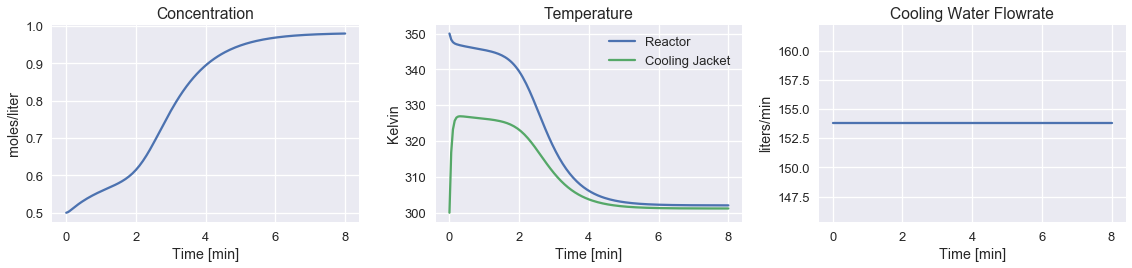

In [5]:
# set initial conditions and cooling flow
IC = [C0,T0,Tcf]

# do simulation at fixed time steps dt
dt = 0.05
ti = 0.0
tf = 8.0

# create python list to log results
log = []

# start simulation
c,T,Tc = IC
qc = 153.8
for t in np.linspace(ti,tf,int((tf-ti)/dt)+1):
    log.append([t,c,T,Tc,qc])                      # log data for later plotting
    c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]   # start at t, find state at t + dt

def qplot(log):
    log = np.asarray(log).T
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.plot(log[0],log[1])
    plt.title('Concentration')
    plt.ylabel('moles/liter')
    plt.xlabel('Time [min]')

    plt.subplot(1,3,2)
    plt.plot(log[0],log[2],log[0],log[3])
    if 'Tsp' in globals():
        plt.plot(plt.xlim(),[Tsp,Tsp],'r:')
    plt.title('Temperature')
    plt.ylabel('Kelvin')
    plt.xlabel('Time [min]')
    plt.legend(['Reactor','Cooling Jacket'])

    plt.subplot(1,3,3)
    plt.plot(log[0],log[4])
    plt.title('Cooling Water Flowrate')
    plt.ylabel('liters/min')
    plt.xlabel('Time [min]')
    plt.tight_layout()

SS = log[-1]
qplot(log)


## Simulation 3.  Proportional-Integral-Derivative Control

Proportional-Integral-Derivative (PID) control is the workhorse of the process control industry. In standard form, the PID algorithm would be written

$$q_c(t) = \bar{q}_c - K_c\left[(T_{sp}-T) + \frac{1}{\tau_I}\int_0^t (T_{sp}-T)dt' + \tau_D\frac{d(T_{sp}-T)}{dt} \right]$$

For the control reactor temperature, note the controller is 'direct-acting' such that a positive excursion of the reactor temperature $T$ above the setpoint $T_{sp}$ is compensated by an increase in coolant flow, and vice-versa. Thus a negative sign appears before the term $K_c$ contrary to the usual textbook convention for negative feedback control.

The practical implementation of PID control is generally facilitated by a number of modifications.

#### Independent Parameters

A common practice is to introduce an independent parameterization for each fo the P, I, and D terms.  Rewriting, the control equation becomes

$$q_c(t) = \bar{q}_c - \left[k_P(T_{sp}-T) + k_I\int_0^t (T_{sp}-T)dt' + k_D\frac{d(T_{sp}-T)}{dt} \right]$$

where

\begin{align*}
k_P & = K_c \\
k_I & = \frac{K_c}{\tau_I} \\
k_D & = K_c\tau_D
\end{align*}

#### Setpoint Weighting

Step changes in setpoint $T_{sp}$ can produce undesired 'kicks' and 'bumps' if PID control is implemented directly using in standard form. It is common practice to introduce setpoint weighting factors for the proportional and derivative terms. This can be written as 

$$q_c(t) = \bar{q}_c - \left[k_Pe_P(t) + k_I\int_0^t e_I(t')dt' + k_D\frac{e_D(t)}{dt} \right]$$

where

\begin{align*}
e_P(t) & = \beta T_{sp}(t) - T(t) \\
e_I(t) & = T_{sp}(t) - T(t) \\
e_D(t) & = \gamma T_{sp}(t) - T(t)
\end{align*}

Common practice is to set $\gamma = 0$ which eliminates derivative action based on change in the setpoint. This feature is sometimes called 'derivative on output'. This almost always a good idea in process control since it avoids the 'derivative kick' associated with a change in setpoint.

In practice, the term $\beta$ is generally tuned to meet the specific application requirements. In this case, where setpoint tracking is not a high priority, setting $\beta = 0$ is a reasonable starting point.

#### Discrete Time Implementation

The simulation strategy adopted here requires a discrete time implementation of PID control. For a sampling time $dt$, the PID algorithm becomes

$$q_c(t_k) = \bar{q}_c - \left[k_Pe_P(t_k) + k_Idt\sum_0^{t_k} e_I(t_{k'}) + k_D\frac{e_D(t_k)-e_D(t_{k-1})}{dt} \right]$$

Implementation is further streamlined by computing changes is $q_c(t_k)$

$$\Delta q_c(t_k) = q_c(t_k) - q_c(t_{k-1})$$

Computing the differences

$$\Delta q_c(t_k) = -\left[k_P(e_P(t_k)-e_P(t_{k-1})) + k_I\ dt\ e_I(t_k) + k_D\frac{e_D(t_k) - 2e_D(t_{k-1}) + e_D(t_{k-2})}{dt}\right]$$

#### Bounded Control

A final consideration is that the coolant flows have lower and upper bounds of practical operation. 

$$q_c = \max(q_{c,min},\max(q_{c,max},q_c)) $$



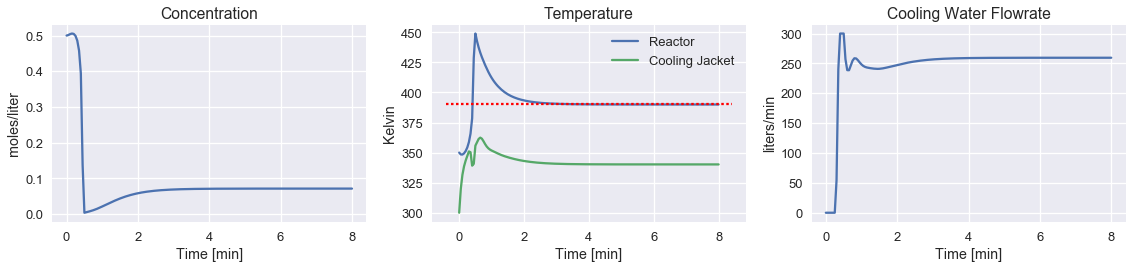

In [6]:
# setpoint
Tsp = 390

# set initial conditions and cooling flow
IC = [C0,T0,Tcf]

# do simulation at fixed time steps dt
dt = 0.05
ti = 0.0
tf = 8.0

# control saturation
qc_min = 0                            # minimum possible coolant flowrate
qc_max = 300                          # maximum possible coolant flowrate
def sat(qc):                          # function to return feasible value of qc
    return max(qc_min,min(qc_max,qc))

# control parameters
kp = 40
ki = 80
kd = 0
beta = 0
gamma = 0

# create python list to log results
log = []

# start simulation
c,T,Tc = IC
qc = 150

eP_ = beta*Tsp - T
eD_ = gamma*Tsp - T
eD__ = eD_

for t in np.linspace(ti,tf,int((tf-ti)/dt)+1):
    # PID control calculations
    eP = beta*Tsp - T
    eI = Tsp - T
    eD = gamma*Tsp - T
    qc -= kp*(eP - eP_) + ki*dt*eI + kd*(eD - 2*eD_ + eD__)/dt
    qc = sat(qc)
    
    # log data and update state
    log.append([t,c,T,Tc,qc])
    c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]     # start at t, find state at t + dt
    
    # save data for PID calculations
    eD__,eD_,eP_ = eD_,eD,eP

qplot(log)

## Simulation 4. Interactive Controller Tuning

In this example, PID control is used to stabilize an otherwise unstable steady state, thereby allowing the reactor to operate at temperature and conversion that would not be possible without control. The acheivable operating conditions are limited by the controller tuning and the limits on the available control action.

The following simulation provides for the interactive adjustment of reactor setpoint temperature and the proportional, integral, and derivative control gains. Adjust these in order to answer the following questions:

1. What is the minimum achieveable temperature setpoint for the reactor with conversion greater than 80%?  What limits the ability to reduce the temperature setpoint even further?

2. Adjust the temperature setpoint to 420K.  Adjust the controller gains for satisfactory closed-loop performance.  Repeat the exercise for a setpoint of 390K. How is the behavior different?  What happens when when the proportional gain is set too small?  Explain what you see.

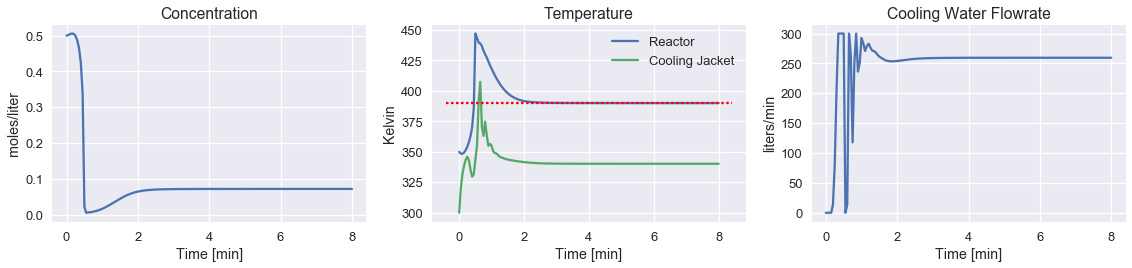

In [7]:
from ipywidgets import interact

IC = [C0,T0,Tcf]

def sim(Tsetpoint,kp,ki,kd):
    global Tsp, qc
    Tsp = Tsetpoint
    
    # control parameters
    beta = 0
    gamma = 0

    # create python list to log results
    log = []

    # start simulation
    c,T,Tc = IC
    qc = 150

    eP_ = beta*Tsp - T
    eD_ = gamma*Tsp - T
    eD__ = eD_

    for t in np.linspace(ti,tf,int((tf-ti)/dt)+1):
        # PID control calculations
        eP = beta*Tsp - T
        eI = Tsp - T
        eD = gamma*Tsp - T
        qc -= kp*(eP - eP_) + ki*dt*eI + kd*(eD - 2*eD_ + eD__)/dt
        qc = sat(qc)

        # log data and update state
        log.append([t,c,T,Tc,qc])
        c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]     # start at t, find state at t + dt
    
        # save data for PID calculations
        eD__ = eD_
        eD_ = eD
        eP_ = eP

    qplot(log)
    
interact(sim,Tsetpoint = (360,420),kp = (0,80), ki=(0,160), kd=(0,10));

## Simulation 5. Using the PIDsim Controller Class

From this point on, this notebook describes the development of a PID control class that could be used in more complex simulations. Regard everything after this point as 'try at your own risk'!

Examples of PID Codes in Python:

* [DISCRETE PID CONTROLLER (PYTHON RECIPE)](http://code.activestate.com/recipes/577231-discrete-pid-controller/)
* [ivPID](https://github.com/ivmech/ivPID)
* [python-pid_controller](https://gist.github.com/chaosmail/8372717)
* [PID Controller](https://github.com/chrisspen/pid_controller)
* [pypid 0.4](https://pypi.python.org/pypi/pypid/)
* [PIDController](http://cgkit.sourceforge.net/doc2/pidcontroller.html)
* [PID.py](http://examples.oreilly.com/9780596809577/CH09/PID.py)
* [APMonitor.com](http://apmonitor.com/do/index.php/Main/NonlinearControl)

Below we demonstrate the use of `PIDsim`, a python module that can be used to implement multiple PID controllers in a single simulation. 

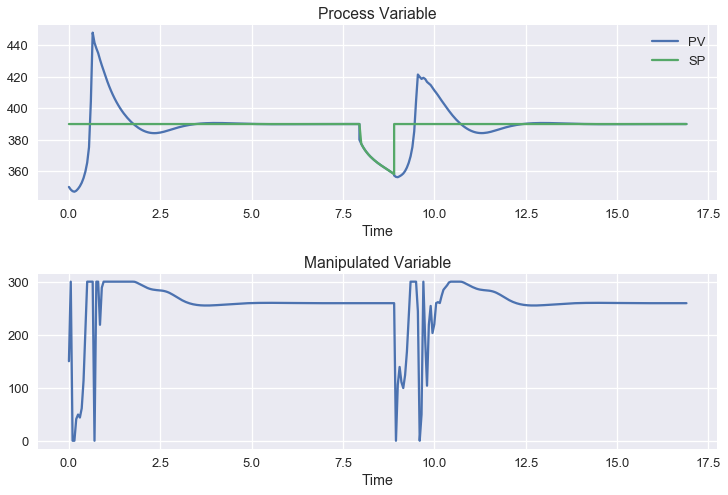

In [8]:
from PIDsim import PID

# reactor temperature setpoint
Tsp = 390

# set initial conditions and cooling flow
IC = [C0,T0,Tcf]

# do simulation at fixed time steps dt
tstart = 0
tstop = 8
tstep = 0.05

# configure controller. Creates a PID object.
reactorPID = PID(Kp=8,Ki=30,Kd=5,MVrange=(0,300),DirectAction=True)

c,T,Tc = IC                                          # reactor initial conditions
qc = 150                                             # initial condition of the MV
for t in np.arange(tstart,tstop,tstep):              # simulate from tstart to tstop
    qc = reactorPID.update(t,Tsp,T,qc)               # update manipulated variable
    c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]     # start at t, find state at t + dt

reactorPID.manual()                                  # switch to manual model                    
T -= 10                                              # change process variable by -10 deg
for t in np.arange(t,t+1,tstep):                     # simulate for 1 minute
    qc = reactorPID.update(t,Tsp,T,qc)               # continue to update, SP tracks PV
    c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]     # start at t, find state at t + dt

reactorPID.auto()                                    # switch back to auto mode
for t in np.arange(t,t+tstop,tstep):                 # integrate another tstop minutes
    qc = reactorPID.update(t,Tsp,T,qc)               # update MV
    c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]     # start at t, find state at t + dt
    
# plot controller log
reactorPID.plot()                                    # plot controller log

### Contents of PIDsim.py

In [9]:
# %load PIDsim.py
import matplotlib.pyplot as plt
import numpy as np

class PID:
    """ An implementation of a PID control class for use in process control simulations.
    """
    def __init__(self, name=None, SP=None, Kp=0.2, Ki=0, Kd=0, beta=1, gamma=0, MVrange=(0,100), DirectAction=False):
        self.name = name
        self.SP = SP
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.beta = beta
        self.gamma = gamma
        self.MVrange = MVrange
        self.DirectAction = DirectAction
        self._mode = 'inAuto'
        self._log = []
        self._errorP0 = 0
        self._errorD0 = 0
        self._errorD1 = 0
        self._lastT = 0
        self._currT = 0
        
    def auto(self):
        """Change to automatic control mode. In automatic control mode the .update()
        method computes new values for the manipulated variable using a velocity algorithm.
        """
        self._mode = 'inAuto'
        
    def manual(self):
        """Change to manual control mode. In manual mode the setpoint tracks the process 
        variable to provide bumpless transfer on return to automatic model.
        """
        self._mode = 'inManual'
        
    def _logger(self,t,SP,PV,MV):
        """The PID simulator logs values of time (t), setpoint (SP), process variable (PV),
        and manipulated variable (MV) that can be plotted with the .plot() method.
        """
        self._log.append([t,SP,PV,MV])
        
    def plot(self):
        """Create historical plot of SP,PV, and MV using the controller's internal log file.
        """
        dlog = np.asarray(self._log).T
        t,SP,PV,MV = dlog
        plt.subplot(2,1,1)
        plt.plot(t,PV,t,SP)
        plt.title('Process Variable')
        plt.xlabel('Time')
        plt.legend(['PV','SP'])
        plt.subplot(2,1,2)
        plt.plot(t,MV)
        plt.title('Manipulated Variable')
        plt.xlabel('Time')
        plt.tight_layout()
    
    @property
    def beta(self):
        """beta is the setpoint weighting for proportional control where the proportional error
        is given by error_proportional = beta*SP - PV. The default value is one.
        """
        return self._beta
        
    @beta.setter
    def beta(self,beta):
        self._beta = max(0.0,min(1.0,beta))
        
    @property
    def DirectAction(self):
        """DirectAction is a logical variable setting the direction of the control. A True
        value means the controller output MV should increase for PV > SP. If False the controller
        is reverse acting, and ouput MV will increase for SP > PV. IFf the steady state
        process gain is positive then a control will be reverse acting. 
        
        The default value is False.
        """
        return self._DirectAction
    
    @DirectAction.setter
    def DirectAction(self,DirectAction):
        if DirectAction:
            self._DirectAction = True
            self._action = +1.0
        else:
            self._DirectAction = False
            self._action = -1.0
    
    @property
    def gamma(self):
        """gamma is the setpoint weighting for derivative control where the derivative error
        is given by gamma*SP - PV.  The default value is zero. 
        """
        return self._gamma
    
    @gamma.setter
    def gamma(self,gamma):
        self._gamma = max(0.0,min(1.0,gamma))
    
    @property
    def Kp(self):
        """Kp is the proportional control gain.
        """
        return self._Kp
    
    @Kp.setter
    def Kp(self,Kp):
        self._Kp = Kp
    
    @property
    def Ki(self):
        """Ki is the integral control gain.
        """
        return self._Ki
        
    @Ki.setter
    def Ki(self,Ki):
        self._Ki = Ki
    
    @property
    def Kd(self):
        """Kd is the derivative control gain.
        """
        return self._Kd
    
    @Kd.setter
    def Kd(self,Kd):
        self._Kd = Kd
        
    @property
    def MV(self):
        """MV is the manipulated (or PID outpout) variable. It is automatically
        restricted to the limits given in MVrange.
        """
        return self._MV
    
    @MV.setter
    def MV(self,MV):
        self._MV = max(self._MVmin,min(self._MVmax,MV))
        
    @property
    def MVrange(self):
        """range is a tuple specifying the minimum and maximum controller output.
        Default value is (0,100).
        """
        return (self._MVmin,self._MVmax)
    
    @MVrange.setter
    def MVrange(self,MVrange):
        self._MVmin = MVrange[0]
        self._MVmax = MVrange[1]

    @property
    def SP(self):
        """SP is the setpoint for the measured process variable.
        """
        return self._SP
    
    @SP.setter
    def SP(self,SP):
        self._SP = SP
        
    @property
    def PV(self):
        """PV is the measured process (or control) variable.
        """
        return self._PV
    
    @PV.setter
    def PV(self,PV):
        self._PV = PV

    def update(self,t,SP,PV,MV):
        self.SP = SP
        self.PV = PV
        self.MV = MV 
        if t > self._lastT:
            dt = t - self._lastT
            self._lastT = t
            if self._mode=='inManual':
                self.SP = PV
            self._errorP1 = self._errorP0
            self._errorP0 = self.beta*self.SP - self.PV
            self._errorI0 = self.SP - self.PV            
            self._errorD2 = self._errorD1
            self._errorD1 = self._errorD0
            self._errorD0 = self.gamma*self.SP - self.PV
            if self._mode=='inAuto':
                self._deltaMV = self.Kp*(self._errorP0 - self._errorP1) \
                    + self.Ki*dt*self._errorI0 \
                    + self.Kd*(self._errorD0 - 2*self._errorD1 + self._errorD2)/dt
                self.MV -= self._action*self._deltaMV
        self._logger(t,self.SP,self.PV,self.MV)
        return self.MV 


# Interacting Tanks

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338).

## Problem Statement

The following diagram shows a pair of interacting tanks.

![Image of a two interacting tanks](../images/InteractingTanks.png)

Assume the pressure driven flow into and out of the tanks is linearly proportional to tank levels. The steady state flowrate through the tanks is 3 cubic ft per minute, the steady state heights are 7 and 3 feet, respectively, and a constant cross-sectional area 5 sq. ft. The equations are written as

$$\begin{align*}
\frac{dh_1}{dt} & = \frac{F_0}{A_1} - \frac{\beta_1}{A_1}\left(h_1-h_2\right) \\
\frac{dh_2}{dt} & = \frac{\beta_1}{A_2}\left(h_1-h_2\right) - \frac{\beta_2}{A_2}h_2
\end{align*}$$

**a.** Use the problem data to determine values for all constants in the model equations.

**b.** Construct a Phython simulation using `odeint`, and show a plot of the tank levels as function of time starting with an initial condition $h_1(0)=6$ and $h_2(0)$ = 5. Is this an overdamped or underdamped system.

## Solution

### Part a. 

The parameters that need to be determined are $\beta_1$ and $\beta_2$. At steady state all of the flows must be identical and

$$\begin{align*}
0 & = F_0 - \beta_1(h_1 - h_2) \\
0 & = \beta_1(h_1 - h_2) - \beta_2h_2 
\end{align*}$$

Substituting problem data,

$$\beta_1 = \frac{F_0}{h_1-h_2} = \frac{3\text{ cu.ft./min}}{4\text{ ft}} = 0.75\text{ sq.ft./min}$$ 

$$\beta_2 = \frac{\beta_1(h_1 - h_2)}{h_2} = \frac{3\text{ cu.ft./min}}{3\text{ ft}} = 1.0\text{ sq.ft./min}$$ 

### Part b.

The next step is perform a simulation from a specified initial condition. 

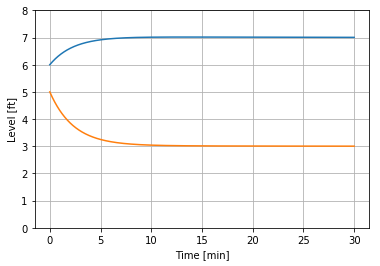

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from ipywidgets import interact

# simulation time grid
t = np.linspace(0,30,1000)

# initial condition
IC = [6,5]

# inlet flowrate
F0 = 3

# parameters for tank 1 
A1 = 5
beta1 = 0.75

# parameters for tank 2
A2 = 5
beta2 = 1.0

def hderiv(H,t):
    h1,h2 = H
    h1dot = (F0 - beta1*(h1-h2))/A1
    h2dot = (beta1*(h1-h2) - beta2*h2)/A2
    return [h1dot,h2dot]

sol = odeint(hderiv,IC,t)
plt.plot(t,sol)
plt.ylim(0,8)
plt.grid()
plt.xlabel('Time [min]')
plt.ylabel('Level [ft]')

##### Further Calculations

$$\frac{d}{dt}\left[\begin{array}{c} h_1 \\ h_2 \end{array}\right] = 
\left[\begin{array}{cc}-\frac{\beta_1}{A_1} & \frac{\beta_1}{A_1} \\
\frac{\beta_1}{A_2} & -\frac{\beta_1}{A_2} - \frac{\beta_2}{A_2} \end{array}\right]
\left[\begin{array}{c}h_1 \\ h_2\end{array}\right]
+
\left[\begin{array}{c}\frac{1}{A_1} \\ 0\end{array}\right]F_0$$

# Interactive PID Control Tuning with  Ziegler-Nichols

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

### Summary

This notebook demonstrates methods for tuning PID controllers using Ziegler-Nichols and other tuning rules.

### Table of Contents

1. [Block Diagram of the Closed-Loop Control System](#blockdiagram)
    * Process Transfer Functions
    * Pade Approximate for Measurement Transfer Function with Time Delay
    * Proportional-Integral Control Transfer Function
2. [Closed-Loop Transfer Functions](#closedloop)
    * Definitions
    * Interactive Simulation
3. [Control Tuning Procedures](#tuning)
    * Ziegler-Nichols
    * Tyreus-Luyben
4. [Exercises](#exercises)
5. [References](#references)
    
### Notebook Initialization

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control.matlab as control

<a id="blockdiagram"></a>
## 1. Block Diagram of the Closed-Loop Control System

The task is to design and tune a PID controller for the closed-loop block shown in the figure below with signal descriptions given in the following table:

| Signal | Description |
| :----: | :---------- |
| $u$    | command to manipulated variable |
| $d$    | disturbance variable input |
| $y$    | controlled varable process output |
| $r$    | controlled variable setpoint |

Transfer functions corresponding to the valve dynamics $G_v(s)$, the process transfer function $G_p(s)$, the disturbance transfer function $G_d(s)$ and measurement transfer function $G_m(s)$ are specified in subsequent cells.

<img src="../images/controlloop.png"/>

### Process Transfer Functions

Valve dynamics:
$$G_v(s) = \frac{1}{2s + 1}$$

Process dynamics:
$$G_p(s) = \frac{1}{5s + 1}$$

Disturbance dynamics:
$$G_d(s) = \frac{1}{5s + 1}$$


In [2]:
Gv = control.tf([1],[2,1])
Gp = control.tf([1],[5,1])
Gd = control.tf([1],[5,1])
print(Gv,Gp,Gd)


   1
-------
2 s + 1
 
   1
-------
5 s + 1
 
   1
-------
5 s + 1



### Measurement Transfer Function

The measurement consists of a pure time delay of 1 minute modeled by the transfer function 

$$G_m(s) = e^{-\tau_d s}$$

where $\tau_d = 1$. The python control library does not currently incorporate time delays modeled by exponentials, therefore an approximation is necessary. The first order Pade approximation is given by

$$e^{-\tau_d s} \approx \frac{-\frac{\tau_d}{2}s + 1}{\frac{\tau_d}{2}s + 1}$$

This is implemented in the python control library by the function `pade(tdelay,norder)` where `tdelay` is the length of the time delay, and `norder` is the order of approximation.

In [3]:
tdelay = 1
norder = 1
num,den = control.pade(tdelay,norder)
Gm = control.tf(num,den)
print(Gm)


-s + 2
------
s + 2



### Proportional-Integral (PI) Control

The classical form for PI control is given by 

$$G_c(s) = K_c\left(1 + \frac{1}{\tau_I s}\right)$$

where $K_c$ is the proportional control gain, and $\tau_I$ in the integrator time constant. Note the making $K_c$ very small is equivalent to turning off the controller, while making $\tau_I$ very large is equivalent to turning off just the integrating portion of the controller.

In the transfer function format

$$G_c(s) = K_c\frac{\tau_I s + 1}{\tau_I s + 0}$$

In [4]:
Kc = 1
tauI = 100

Gc = Kc*control.tf([tauI,1],[tauI,0])
print(Gc)


100 s + 1
---------
  100 s



<a id="closedloop"></a>
## 2. Closed-Loop Transfer Functions

### Definitions

The task we're given is to choose the parameters for a P, PI, or PID controller that result in the good system response. How do we determine if the system response is good or not?

The key to this analysis is to consider a set of four responses

| Response | Transfer function | Description |
| :------: | :---------------: | :---------- |
| $r \rightarrow y$ | $H_{yr}$ | output response to a setpoint change (ideally 1) |
| $d \rightarrow y$ | $H_{yd}$ | output response to a disturbance (ideally 0) |
| $r \rightarrow u$ | $H_{ur}$ | manipulated variable response to a setpoint change |
| $d \rightarrow u$ | $H_{ud}$ | manipulated variable resposne to a disturbance |

Only by examining all four of these can you reach a determination of whether the controller does a good job with respect to both setpoint tracking and disturbance rejection, and that it acheives good output control without excessive or unacceptable changes in the manipulated variable.

The notation use $H$ to designate a closed-loop transfer function and subscripts to indicate the particular pairing of system inputs and outputs. The subscripts correspond to the row and column indices in a matrix equation

$$\left[\begin{array}{c} y \\ u \end{array}\right] =
\left[\begin{array}{cc} H_{yr} & H_{yd} \\ H_{ur} & H_{ud} \end{array}\right]
\left[\begin{array}{c} r \\ d \end{array}\right]$$

For the closed-loop block diagram shown above, the closed-loop transfer functions are given by

$$H_{yr} = \frac{G_p G_v G_c}{1 + G_p G_v G_c G_m}$$

$$H_{yd} = \frac{G_d}{1 + G_p G_v G_c G_m}$$

$$H_{ur} = \frac{G_c}{1 + G_c G_m G_p G_v}$$

$$H_{ud} = -\frac{G_c G_m G_d}{1 + G_c G_m G_p G_v}$$


In [5]:
Hyr = Gp*Gv*Gc/(1+Gp*Gv*Gc*Gm)
Hyd = Gd/(1+Gp*Gv*Gc*Gm)
Hur = Gc/(1+Gc*Gm*Gp*Gv)
Hud = -Gc*Gm*Gd/(1+Gc*Gm*Gp*Gv)

### Interactive Simulation

In [16]:
def sim(Kc = 1, tauI = 1000):
    Gc =  Kc*control.tf([tauI,1],[tauI,0])
    
    Hyr = Gp*Gv*Gc/(1+Gp*Gv*Gc*Gm)
    Hyd = Gd/(1+Gp*Gv*Gc*Gm)
    Hur = Gc/(1+Gc*Gm*Gp*Gv)
    Hud = -Gc*Gm*Gd/(1+Gc*Gm*Gp*Gv)

    t = np.linspace(0,25,1000)

    plt.figure(figsize=(12,6))

    plt.subplot(2,2,1)
    y,t = control.step(Hyr,t)
    plt.plot(t,y)
    plt.ylim(-0.5,2.2)
    plt.title('output response due to step setpoint')
    plt.ylabel('y')

    plt.subplot(2,2,2)
    y,t = control.step(Hyd,t)
    plt.plot(t,y)
    plt.ylim(-0.5,2.2)
    plt.title('output response due to a step disturbance')
    plt.ylabel('y')

    plt.subplot(2,2,3)
    u,t = control.step(Hur,t)
    plt.plot(t,u)
    plt.ylim(-1.5,1.5)
    plt.title('manipulated variable response due to step setpoint')
    plt.ylabel('u')

    plt.subplot(2,2,4)
    u,t = control.step(Hud,t)
    plt.plot(t,u)
    plt.ylim(-1.5,1.5)
    plt.title('manipulated variable response due to a step disturbance')
    plt.ylabel('u')

    plt.tight_layout()

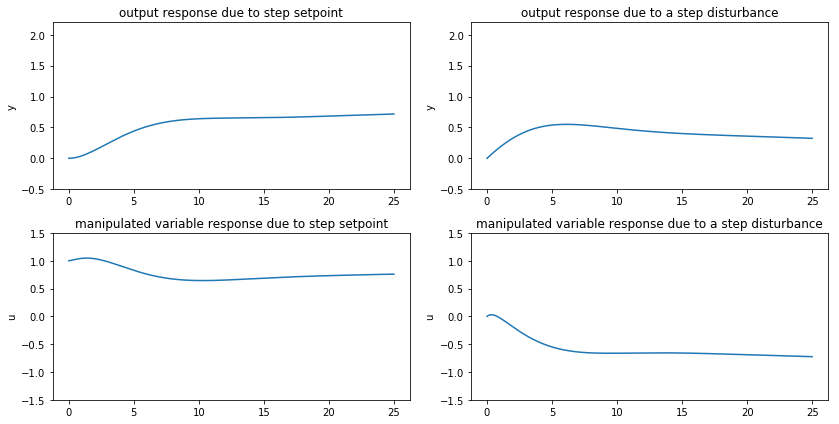

In [17]:
from ipywidgets import interact, fixed
interact(sim,Kc = (0.1,10,0.1),tauI=(0.1,25,1));

<a id="tuning"></a>
## 3. Control Tuning Procedures

Tuning rules are a frequently used method for selecting the parameters for Proportional, Proportional-Integral, and Proportional-Integral-Derivative control. The procedures for the Ziegler-Nichols and Tyreus-Luyben tuning rules are as follows:

1. Begin with the controller turned on in proportional only mode.  This can be acheived by setting $\tau_D = 0$ and $\tau_I$ to the maximum possible value.

2. Increase the proportional gain $K_c$ until you observe continuous cycling in response to a disturbance or setpoint adjustment.  Continous cycling is the boundary between stable and unstable process response. The cycling should have constant amplitude that is neither increasing or descreasing in time. The value of $K_c$ at which you observe continuous cycling is the **ulitmate gain** $K_{cu}$.  The period of the corresponding oscillation is $P_u$ and called the **ultimate period**.

3. Having obtained values for $K_{cu}$ and $P_u$, select the type of control to use, and set parameters usign either the Ziegler-Nichols (agressive, tends to be underdamped) or Tyreus-Luyben (tends to be more appropriate for large scale chemcial processes).

4. Test the closed-loop controlled system response to typical process disturbances and setpoint adjustments. Retune as necessary.

To demonstrate, we used the interactive simulation to determine the ultimate gain and period. The ultimate gain $K_{cu} = 8.1$ and $P_u = 8$.

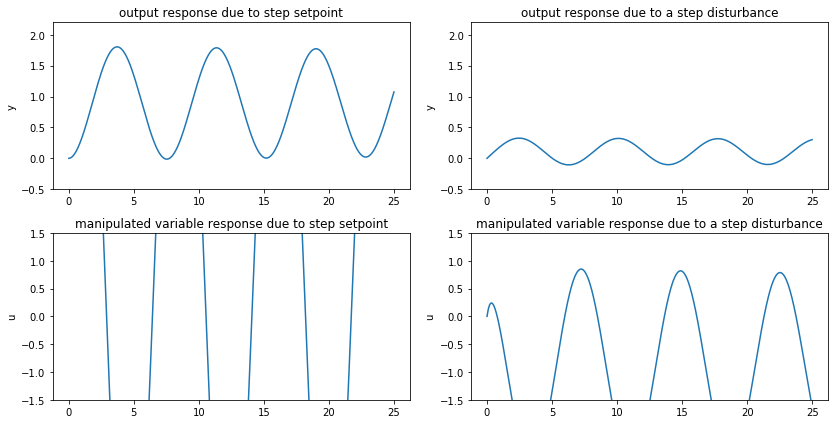

In [18]:
from ipywidgets import fixed
interact(sim,Kc = fixed(8.1), tauI=fixed(1000));

### Ziegler-Nichols

One of the best known set of tuning rules was developed by J. G. Ziegler and N. B. Nichols in 1942 when they working for the Taylor Instrument Company in Rochester, NY.  The rules are summarized as

| Control | $K_c$         | $\tau_I$          | $\tau_D$        |
| :-----: | :-----------: | :---------------: | :-------------: |
| P       | $0.5 K_{cu}$  | -                 | -               |
| PI      | $0.45 K_{cu}$ | $\frac{P_u}{1.2}$ | -               |
| PID     | $0.6 K_{cu}$  | $\frac{P_u}{2}$   | $\frac{P_u}{8}$ |

For the given example, assuming PI control,

$$K_c = 0.45 K_{cu} = 0.45 \times 8.1 = 3.6$$

$$\tau_I = P_u/1.2 = 8/1.2 = 6.7$$

These rules will typically yield a decay ratio of about 25%, which is generally a bit too aggressive for most large scale chemical process applications.


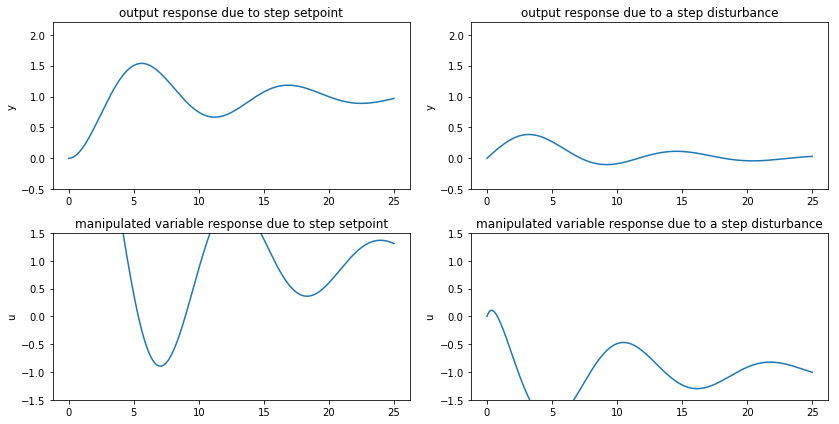

In [19]:
interact(sim,Kc = fixed(3.6), tauI=fixed(6.7));

### Tyreus-Luyben

The Ziegler-Nichols tuning rules are generally regarded as too aggressive for most process control applications. In 1992, based on collaborative research between the Dow Chemical Company and Lehigh University, Bjorn Tyreus and William Luyben proposed the following modification for the traditional tuning rules.

| Control | $K_c$         | $\tau_I$     | $\tau_D$          |
| :-----: | :-----------: | :----------: | :---------------: |
| PI      | $0.31 K_{cu}$ | $2.2 P_u$    | -                 |
| PID     | $0.45 K_{cu}$  | $2.2 P_u$   | $\frac{P_u}{6.3}$ |

For the given example, assuming PI control,

$$K_c = 0.31 K_{cu} = 0.31 \times 8.1 = 2.5$$

$$\tau_I = 2.2 P_u = 2.2 \times 8 = 17.6$$

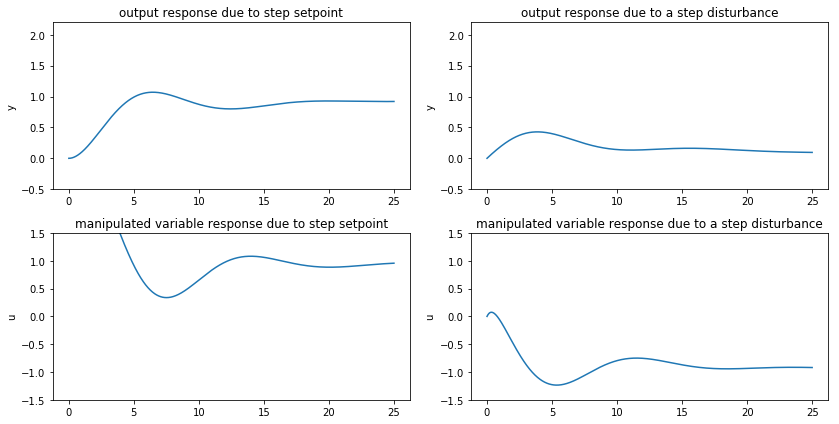

In [20]:
from ipywidgets import fixed
interact(sim,Kc = fixed(2.5), tauI=fixed(17.6));

<a id="exercises"></a>
## 4. Exercises

### Exercise: PID Control

Modify the simulation to include a three parameter PID control of the form

$$G_c(s) = K_c\left(1 + \frac{1}{\tau_Is} + \frac{\tau_Ds}{\frac{\tau_D}{N} s + 1}\right)$$

where $N = 10$. This formulation is needed to avoid a transfer function with a numerator polynomial that is higher order than the denominator polynomial as required by the Python Control Library.

### Exercise: Alternative Tuning Rules

There are wide variety of recommended tuning rules, including several mentioned on the [Wikipedia page describing the Ziegler-Nichols method](https://en.wikipedia.org/wiki/Ziegler%E2%80%93Nichols_method). Test these to see if they perform as expected. Can you draw any general conclusions about the superiority of one method to another?

<a id="references"></a>
## References

1. Tyreus, Bjorn D., and William L. Luyben. "Tuning PI controllers for integrator/dead time processes." Industrial & Engineering Chemistry Research 31.11 (1992): 2625-2628.

2. Ziegler, John G., and Nathaniel B. Nichols. "Optimum settings for automatic controllers." trans. ASME 64.11 (1942).

# Introduction to Python - A Python Tutorial

by Jacob Gerace. The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338).

### Why Python?

1. Clean syntax
2. The same code can run on all Operating Systems
3. **Extensive first and third party libraries (of particular note for our purposes is NumPy)**

### Markdown Sidenote
 * This text is written in a Markdown block. Markdown is straightforward way to format writeups in Jupyter, but I won't cover it here for the sake of brevity. 
 * See if you can use Markdown in your next homework, here's a link that explains the formatting: https://daringfireball.net/projects/markdown/syntax . 
 * You can also look at existing Markdown examples (i.e. this worksheet) and emulate the style. Double click a Markdown box in Jupyter to show the code.
 
### LaTeX Sidenote
* LaTeX (pronounced "La-tech") is a language itself used widely to write documents with symbolic math
* When you add a mathematical formula to these markdown blocks, the math is in LaTeX.
* Ex from class: $$V \frac{dC}{dt} = u(t) - Q C(t)$$ 
* A good resource: https://en.wikibooks.org/wiki/LaTeX/Mathematics
 
 
### What I hope you'll get out of this tutorial:
* The feeling that you'll "know where to start" when you see python code in lecture, or when you need to write python for an assignment.
* (You won't be a python expert after one hour)
* Basics to variables, lists, conditionals, functions, loops, and the numpy package.
* Resources to look further

## Python Basics
### Variable Basics

In [1]:
#A variable stores a piece of data and gives it a name
answer = 42

#answer contained an integer because we gave it an integer!

is_it_tuesday = True
is_it_wednesday = False

#these both are 'booleans' or true/false values

pi_approx = 3.1415

#This will be a floating point number, or a number containing digits after the decimal point

my_name = "Jacob"
#This is a string datatype, the name coming from a string of characters

#Data doesn't have to be a singular unit

#p.s., we can print all of these with a print command. For Example:
print(answer)
print(pi_approx)

42
3.1415


### More Complicated Data Types


In [2]:

#What if we want to store many integers? We need a list!
prices = [10, 20, 30, 40, 50]

#This is a way to define a list in place. We can also make an empty list and add to it.
colors = []

colors.append("Green")
colors.append("Blue")
colors.append("Red")

print(colors)

#We can also add unlike data to a list
prices.append("Sixty")

#As an exercise, look up lists in python and find out how to add in the middle of a list!

print(prices)
#We can access a specific element of a list too:

print(colors[0])
print(colors[2])

#Notice here how the first element of the list is index 0, not 1! 
#Languages like MATLAB are 1 indexed, be careful!

#In addition to lists, there are tuples
#Tuples behave very similarly to lists except that you can't change them after you make them

#An empty Tuple isn't very useful:
empty_tuple = ()

#Nor is a tuple with just one value:
one_tuple = ("first",)

#But tuples with many values are useful:
rosa_parks_info = ("Rosa", "Parks", 1913, "February", 4)

#You can access tuples just like lists
print(rosa_parks_info[0] + " " + rosa_parks_info[1])

#You cannot modify existing tuples, but you can make new tuples that extend the information.
#I expect Tuples to come up less than lists. So we'll just leave it at that. 

['Green', 'Blue', 'Red']
[10, 20, 30, 40, 50, 'Sixty']
Green
Red
Rosa Parks


### Basic Things to do with Variables. Especially Floats.

In [3]:
float1 = 5.75
float2 = 2.25
#Addition, subtraction, multiplication, division are as you expect

print(float1 + float2)
print(float1 - float2)
print(float1 * float2)
print(float1 / float2)

#Here's an interesting one that showed up in your first homework. Modulus. The remainder of division:
print(5 % 2)

#Just about every standard math function on a calculator has a python equivalent pre made.
#however, they are from the 'math' package in python. Let's add that package!
import math
print(math.log(float1))
print(math.exp(float2))
print(math.pow(2,5))
# There is a quicker way to write exponents if you want:
print(2.0**5.0)

#Like in MATLAB, you can expand the math to entire lists
list3 = [1, 2, 3, 4, 5]
print(2 * list3)

#There's more you can do with lists in normal python, but let's look at numpy, which makes things easier.

8.0
3.5
12.9375
2.5555555555555554
1
1.749199854809259
9.487735836358526
32.0
32.0
[1, 2, 3, 4, 5, 1, 2, 3, 4, 5]


### Conditionals in Python

In [4]:
#Sometimes you want to execute code only in certain circumstances. We saw this on HW1.

#Should be fairly straightforward:
answer = 42

if answer == 42:
    print('This is the answer to the ultimate question')
elif answer < 42:
    print('This is less than the answer to the ultimate question')
else:
    print('This is more than the answer to the ultimate question')
print('This print statement is run no matter what because it is not indented!')

#An if statement is an example of a structure that creates a new block. The block includes all of the code that is 
#indented. The indentation (tab character) is imperative. Don't forget it!

#This is normally just good coding style in other languages, but in python it isn't optional

#We can check multiple things at once using boolean operations
rainy = True
day = "Wednesday"

if (rainy == False) and (day != "Tuesday"):
    #&& is boolean and, true only if both are true. False otherwise
    print("The price for golfing is the full $10")
elif (rainy == True) and (day == "Tuesday"):
    print("The price for golfing is reduced to $5!")
elif (rainy == True) or (day == "Tuesday"):
    #|| is boolean inclusive or False only if both are false. True otherwise.
    print("The price for golfing is reduced to $7.50!")
    
#You can structure these statements more neatly if you "nest" if statements (put an if statement inside an if statement)
#But this is just for edification.

This is the answer to the ultimate question
This print statement is run no matter what because it is not indented!
The price for golfing is reduced to $7.50!


### Functions in Python

In [5]:
#We can separate off code into functions, that can take input and can give output. They serve as black boxes from the 
#perspective of the rest of our code

#use the def keyword, and indent because this creates a new block
def print_me( string ):
    print(string)
   
   #End with the "return" keyword
    return

#Your functions can return data if you so choose
def my_favorite_song( ):
    ans = "Amsterdam - Imagine Dragons"
    return ans

#call functions by repeating their name, and putting your variable in the parenthesis. 
#Your variable need not be named the same thing, but it should be the right type!

text = "I'll take the West train, just by the side of Amsterdam"
print_me(text)
print(my_favorite_song())

I'll take the West train, just by the side of Amsterdam
Amsterdam - Imagine Dragons


### Loops in Python

In [6]:
#Repeat code until a conditional statement ends the loop

#Let's try printing a list
fib = [1, 1, 2, 3, 5, 8]

#While loops are the basic type
i = 0
while(i < len(fib)):
    print(fib[i])
    i = i + 1
    
#In matlab, to do the same thing you would have the conditional as: counter < (length(fib) + 1)
#This is because matlab starts indexing at 1, and python starts at 0.
    
#The above type of loop is so common that the 'for' loop is the way to write it faster.

print("Let's try that again")
#This is most similar to for loops in matlab
for i in range(0, len(fib)) :
    print(fib[i])

print("One more time:")
#Or you can do so even neater
for e in fib:
    print(e)

1
1
2
3
5
8
Let's try that again
1
1
2
3
5
8
One more time:
1
1
2
3
5
8


### Numpy - "The Fundamental Package for Scientific Computing with Python"

[1 2 3]
1
[10 10 10]
[-8 -6 -4]
[ 9 16 21]
[ 0.11111111  0.25        0.42857143]
[[14 14 14]
 [32 32 32]
 [50 50 50]]
-9.51619735393e-16


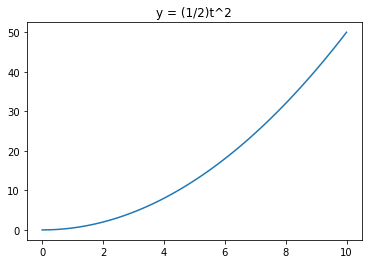

In [7]:
import numpy as np
#Here, we grab all of the functions and tools from the numpy package and store them in a local variable called np.
#You can call that variable whatever you like, but 'np' is standard.

#numpy has arrays, which function similarly to python lists. 
a = np.array([1,2,3])
b = np.array([9,8,7])
#Be careful with syntax. The parentheses and brackets are both required!
print(a)

#Access elements from them just like you would a regular list
print(a[0])

#Element-wise operations are a breeze!
c = a + b
d = a - b
e = a * b
f = a / b

print(c)
print(d)
print(e)
print(f)
#This is different from MATLAB where you add a dot to get element wise operators.

#What about multi-dimensional arrays? Matrices!

#You just nest lists within lists! 
A = np.array( [[1,2,3], [4,5,6], [7,8,9]] )
B = np.array( [[1,1,1], [2,2,2], [3,3,3]] )

#Then matrix multlication
C = np.matmul(A,B)
 
print(C)

#Or determinants:
print(np.linalg.det(A))


#Now, let's use numpy for something essential for you: Numeric Integration

#Define the function you want to integrate....
#dy/dt = t:
def deriv(y,t):
    return t
#Note this doesn't use y in the return. That is okay, but we need to include it just to satisfy the function we will use.

#Set your initial or boundary condition
IC = 0

#Give the number of points to evaluate the integration
start_time = 0
end_time = 10
num_times = 101
times = np.linspace(start_time, end_time, num_times)

from scipy.integrate import odeint
integrated_func = odeint(deriv,IC,times)

#Can we plot the result? You betcha. Just import a new package
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact

plt.plot(times, integrated_func)
plt.title("y = (1/2)t^2")
#Very similar to MATLAB!

### Additional Resources
* If you still feel VERY lost: [Code Academy](https://www.codecademy.com/learn/python)

* If you want a good reference site: [Official Python Reference](https://docs.python.org/2/reference/)

* If you want to learn python robustly: [Learn Python the Hard Way](https://learnpythonthehardway.org/book/)

* Feel free to contact me at: **jgerace (at) nd (dot) edu**


# Linear Approximation of a Multivariable Model using Taylor Series

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

## Multivariable Systems

### Key Idea

Most process models consist of more than a single state and a single input. Techniques for linearization extend naturally to multivariable systems. The most convenient mathematical tools involve some linear algebra.

### Example: Gravity Drained Tanks

Here we develop a linear approximation to a process model for a system consisting of coupled gravity-drained tanks. 

![Gravity Drained Tanks](../images/GravityDrainedTanks.png)

##### Model
\begin{eqnarray*}
A_{1}\frac{dh_{1}}{dt} & = & q_{in}-C_{1}\sqrt{h_{1}}\\
A_{2}\frac{dh_{2}}{dt} & = & q_{d}+C_{1}\sqrt{h_{1}}-C_{2}\sqrt{h_{2}}
\end{eqnarray*}

##### Nominal Inputs
\begin{eqnarray*}
\bar{q}_{in} & = & \bar{q}_{in}\\
\bar{q}_{d} & = & 0
\end{eqnarray*}

##### Steady State for nominal input
\begin{eqnarray*}
\bar{h}_{1} & = & \frac{\bar{q}_{in}^{2}}{C_{1}^{2}}\\
\bar{h}_{2} & = & \frac{\bar{q}_{in}^{2}}{C_{2}^{2}}
\end{eqnarray*}

##### Deviation Variables

States

\begin{eqnarray*}
x_{1} & = & h_{1}-\bar{h}_{1}\\
x_{2} & = & h_{2}-\bar{h}_{2}
\end{eqnarray*}

Control input
$$u=q_{in}-\bar{q}_{in}$$

Disturbance input
$$d=q_{d}-\bar{q}_{d}$$

Measured output
$$y=h_{2}-\bar{h}_{2}$$

##### Linearization 
\begin{eqnarray*}
\frac{dh_{1}}{dt} & = & \frac{1}{A_{1}}\left(q_{in}-C_{1}\sqrt{h_{1}}\right)=f_{1}(h_{1},h_{2},q_{in},q_{d})\\
\frac{dh_{2}}{dt} & = & \frac{1}{A_{2}}\left(q_{d}+C_{1}\sqrt{h_{1}}-C_{2}\sqrt{h_{2}}\right)=f_{2}(h_{1},h_{2},q_{in},q_{d})
\end{eqnarray*}

Taylor series expansion for the first tank

\begin{eqnarray*}
\frac{dx_{1}}{dt} & = & f_{1}(\bar{h}_{1}+x_{1},\bar{h}_{2}+x_{2},\bar{q}_{in}+u,\bar{q}_{d}+d)\\
 & \approx & \underbrace{f_{1}(\bar{h}_{1},\bar{h}_{2},\bar{q}_{in})}_{0}+\left.\frac{\partial f_{1}}{\partial h_{1}}\right|_{SS}x_{1}+\left.\frac{\partial f_{1}}{\partial h_{2}}\right|_{SS}x_{2}+\left.\frac{\partial f_{1}}{\partial q_{in}}\right|_{SS}u+\left.\frac{\partial f_{1}}{\partial q_{d}}\right|_{SS}d\\
 & \approx & \left(-\frac{C_{1}}{2A_{1}\sqrt{\bar{h}_{1}}}\right)x_{1}+\left(0\right)x_{2}+\left(\frac{1}{A_{1}}\right)u+\left(0\right)d\\
 & \approx & \left(-\frac{C_{1}^{2}}{2A_{1}\bar{q}_{in}}\right)x_{1}+\left(\frac{1}{A_{1}}\right)u
\end{eqnarray*}

Taylor series expansion for the second tank

\begin{eqnarray*}
\frac{dx_{2}}{dt} & = & f_{2}(\bar{h}_{1}+x_{1},\bar{h}_{2}+x_{2},\bar{q}_{in}+u,\bar{q}_{d}+d)\\
 & \approx & \underbrace{f_{2}(\bar{h}_{1},\bar{h}_{2},\bar{q}_{in})}_{0}+\left.\frac{\partial f_{2}}{\partial h_{1}}\right|_{SS}x_{1}+\left.\frac{\partial f_{2}}{\partial h_{2}}\right|_{SS}x_{2}+\left.\frac{\partial f_{2}}{\partial q_{in}}\right|_{SS}u+\left.\frac{\partial f_{2}}{\partial q_{d}}\right|_{SS}d\\
 & \approx & \left(\frac{C_{1}}{2A_{2}\sqrt{\bar{h}_{1}}}\right)x_{1}+\left(-\frac{C_{2}}{2A_{2}\sqrt{\bar{h}_{2}}}\right)x_{2}+\left(0\right)u+\left(\frac{1}{A_{2}}\right)d\\
 & \approx & \left(\frac{C_{1}^{2}}{2A_{2}\bar{q}_{in}}\right)x_{1}+\left(-\frac{C_{2}^{2}}{2A_{2}\bar{q}_{in}}\right)x_{2}+\left(\frac{1}{A_{2}}\right)d
\end{eqnarray*}

Measured outputs

\begin{eqnarray*}
y & = & h_{2}-\bar{h}_{2}\\
 & = & x_{2}
\end{eqnarray*}

##### Summary of the linear model using matrix/vector notation
\begin{eqnarray*}
\frac{d}{dt}\left[\begin{array}{c}
x_{1}\\
x_{2}
\end{array}\right] & = & \left[\begin{array}{cc}
-\frac{C_{1}^{2}}{2A_{1}\bar{q}_{in}} & 0\\
\frac{C_{1}^{2}}{2A_{2}\bar{q}_{in}} & -\frac{C_{2}^{2}}{2A_{2}\bar{q}_{in}}
\end{array}\right]\left[\begin{array}{c}
x_{1}\\
x_{2}
\end{array}\right]+\left[\begin{array}{c}
\frac{1}{A_{1}}\\
0
\end{array}\right]u+\left[\begin{array}{c}
0\\
\frac{1}{A_{2}}
\end{array}\right]d\\
y & = & \left[\begin{array}{cc}
0 & 1\end{array}\right]\left[\begin{array}{c}
x_{1}\\
x_{2}
\end{array}\right]+\left[\begin{array}{c}
0\end{array}\right]u+\left[\begin{array}{c}
0\end{array}\right]d
\end{eqnarray*}

### Exercises

##### 1. First Order Reaction in a CSTR
A first-order reaction

$$A\longrightarrow\mbox{Products}$$
takes place in an isothermal CSTR with constant volume $V$, volumetric
flowrate in and out the same value $q$, reaction rate constant $k$,
and feed concentration $c_{AF}$.

* Write the material balance equation for this system as a first-order ordinary differential equation. 
* Algebraically determine the steady-state solution to this equation. 
* For what values of $q$, $k$, $V$, and $c_{AF}$ is this stable?
* For a particular reaction $k$ = 2 1/min. We run this reaction in a vessel of volume $V$ =10 liters, volumetric flowrate $q$ = 50 liters/min. The desired exit concentrationof $A$ is $0.1$ gmol/liter. Assume that we can manipulate $c_{AF}$, the concentration of $A$ entering the CSTR, with proportional control, in order to control the concentration of $A$ exiting the reactor. Substitute the appropriate control law into the mathematical model and rearrange it to get a model of the same form as part (a).
* Determine the steady-state solution to this equation. If we set $K_{c}=100$, what is the absolute value of the offset between the exit concentration of $A$ and the desired exit concentration of $A$? 


##### 2. Two Gravity Drained Tanks in Series
Consider the two-tank model. Assuming the tanks are identical, and
using the same parameter values as used for the single gravity-drained
tank, compute values for all coefficients appearing in the multivariable
linear model. Is the system stable? What makes you think so? 

##### 3.  Isothermal CSTR with second-order reaction
Consider an isothermal CSTR with a single reaction 
$$A\longrightarrow\mbox{Products}$$
whose reaction rate is second-order. Assume constant volume, $V$,
and density, $\rho$, and a time-dependent volumetric flow rate $q(t)$.
The input to the reactor has concentration $c_{A,in}$.

* Write the modeling equation for this system. 
* Assume that the state variable is the concentration of $A$ in the
output, $c_{A}$, and the flow rate $q$ is an input variable. There
is a steady-state operating point corresponding to $q=1$ L/min. Other
parameters are $k=1$ L/mol/min, $V=2$ L, $c_{A,in}=2$ mol/L. Find
the linearized model for $\frac{dc'_{A}}{dt}$ valid in the neighborhood
of this steady state.


# Linear Approximation of a Process Model using Taylor Series

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

### Key Idea

Process models usually exhibit some form of non-linearity due to the multiplication of an extensive flowrate and an intensive thermodynamic state variable, chemical kinetics, or various types of transport phenomenon. Near a steady-state, however, an approximate linear models often provide a 'good-enough' dynamical model for control design and analysis. Here we show how a linear approximation is constructed using a Taylor series expansion.

### Why is this Important?

As we will learn later in this course, linear models are amenable to control design and analysis. For process systems that will be operated near a steady-state, linear models provide a useful framework for control design.

## Procedure for a Single Variable System

We start with a process model that consists of a single first-order
ordinary differential equation of the form

$$\frac{dh}{dt}=f(h,q)$$

where $h$ is the state variable and $q$ is an input variable. Choose
a nominal value for the process input $q$, we'll call this nominal
value $\bar{q}$. The following procedure will produce a linear approximate
valid near the steady-state.

##### Step 1.  Find a Nominal Steady State Operating Condition
Find the steady-state value of $h$ by solving

$$0=f(\bar{h},\bar{q})$$

where $\bar{q}$ is a nominal (i.e, typical, or desired value) of a manipulated process variable.

##### Step 2. Define deviation variables
\begin{eqnarray*}
x & = & h-\bar{h}\\
u & = & q-\bar{q}
\end{eqnarray*}

##### Step 3. Taylor Series Expansion
Compute the first terms in the Taylor series and evaluate at steady-state. The higher-order terms are not needed provided the lower-order terms are non-zero and the deviations are small.
$$
f(\bar{h}+x,\bar{q}+u)\approx f(\bar{h},\bar{q})+\left.\frac{\partial f}{\partial h}\right|_{\bar{h},\bar{q}}x+\left.\frac{\partial f}{\partial q}\right|_{\bar{h},\bar{q}}u+\cdots
$$

##### Step 4. Linear Approximation
The linear approximation is 
$$
\frac{dx}{dt}=\underbrace{\left.\frac{\partial f}{\partial h}\right|_{\bar{h},\bar{q}}}_{a}x+\underbrace{\left.\frac{\partial f}{\partial q}\right|_{\bar{h},\bar{q}}}_{b}u
$$

### Example: Gravity Drained Tank

A simple model for the liquid height in a gravity-drained tank with cross-sectional area $A$ is 

$$A\frac{dh}{dt}=q_{in}-C\sqrt{h}$$

where $q_{in}$ is a volumetric inflow and $C$ is a constant associated with the drain. This is a non-linear process model that can be written

$$\frac{dh}{dt}=f(h,q_{in})$$

where

$$f(h,q_{in})=\frac{1}{A}\left(q_{in}-C\sqrt{h}\right)$$

Given a nominal inlet flowrate $\bar{q}_{in}$, the steady state value of $h$, that is $\bar{h}$, is found by solving the steady state equation

$$0=f(\bar{h},\bar{q}_{in})=\frac{1}{A}\left(\bar{q}_{in}-C\sqrt{\bar{h}}\right)$$

which gives 

$$\bar{h}=\frac{\bar{q}_{in}^{2}}{C^{2}}$$

It's interesting to note the steady-state height of the liquid in a gravity-drained tank is proportional to the square of the nominal flowrate. A 50\% increase in flowrate more than doubles the liquid height.

Let $x$ and $u$ represent the deviations from steady-state

\begin{eqnarray*}
x & = & h-\bar{h}\\
u & = & q-\bar{q}
\end{eqnarray*}

Then

\begin{eqnarray*}
\frac{d(\bar{h}+x)}{dt} & = & \frac{1}{A}\left(\bar{q}_{in}+u-C\sqrt{\bar{h}+x}\right)
\end{eqnarray*}

The Taylor series expansion 

$$f(\bar{h}+x,\bar{q}_{in}+u)\approx f(\bar{h},\bar{q}_{in})+\left.\frac{\partial f}{\partial h}\right|_{\bar{h},\bar{q}}x+\left.\frac{\partial f}{\partial q}\right|_{\bar{h},\bar{q}}u+\frac{1}{2}\left.\frac{\partial^{2}f}{\partial h^{2}}\right|_{\bar{h}}x^{2}\cdots$$

For this example 

$$\frac{dx}{dt}=\left(-\frac{C}{2A\sqrt{\bar{h}}}\right)x+\left(\frac{1}{A}\right)u$$

An alternative form of the model is found by substituting the solution for $\bar{h}$. While these have somewhat different analytical expressions for a given application they will yield identical numerical results.

$$\frac{dx}{dt}=\left(-\frac{C^{2}}{2A\bar{q}_{in}}\right)x+\left(\frac{1}{A}\right)u$$

How well does this approximation work? 

This question can be answered by comparing the results of two simulations. In the first case the simulation consists of integrating 

$$A\frac{dh}{dt}=q_{in}-C\sqrt{h}$$

as shown in the graph below. 

where $A=1$, $C=2$, initial condition $h(0)=0$, and a constant input $q_{in}=\bar{q}_{in}=1$. For these parameter values, the approximate linear model for the deviation from steady-state is given by

\begin{eqnarray*}
\frac{dx}{dt} & = & \left(-\frac{C^{2}}{2A\bar{q}_{in}}\right)x+\left(\frac{1}{A}\right)u\\
\\
 & = & -2\,x+u
\end{eqnarray*}

In terms of deviations from steady state, the input $u=q_{in}-\bar{q}_{in}=0$ and the initial conditionis $x(0)=h(0)-\bar{h}=-\bar{h}$. Plotting $h(t)$ and $x(t)+\bar{h}$ on the same axis produces the results shown in Figure \ref{fig:LinearApproximation}. 



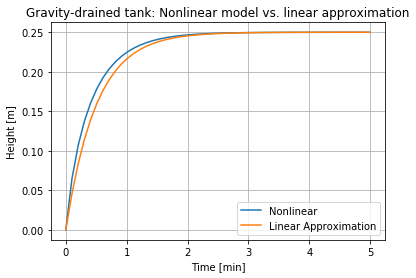

In [11]:
#Simulation of a Gravity-Drained Tank

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

# parameter values
qin = 1
A = 1
C = 2

# steady state
hbar = (qin/C)**2

# nonlinear simulation
def hdot(h,t):
    return (qin - C*np.sqrt(h))/A

t = np.linspace(0,5)
h = odeint(hdot,[0],t)

# linear approximation
a = -C**2/2/A/qin
b = 1/A

def xdot(x,t):
    return a*x + b*u

u = 0
x = odeint(xdot,[-hbar],t)

# visualization
plt.plot(t,h)
plt.plot(t,x+hbar)
plt.legend(['Nonlinear','Linear Approximation'],loc='lower right')
plt.xlabel('Time [min]')
plt.ylabel('Height [m]')
plt.title('Gravity-drained tank: Nonlinear model vs. linear approximation')
plt.grid()

### Exercises

**1.** Suppose you have a tank with an cross-sectional area of 1 square meter, a steady inlet flow $\bar{q}_{in}=10$ liters/min, and observe a liquid height of 0.5 meters. What is the constant $C$? What is the characteristic time constant for the tank?

**2.** You have an elementary reaction 

$$2{\cal A}\longrightarrow Products$$

carried out under isothermal conditions in a stirred tank of volume $V$. The reaction rate is given by the expression 

$$R_{A}=k_{A}C_{A}^{2}$$

and the inlet concentration to the tank is $C_{A,in}$ at flowrate $q$. Construct a linear approximation for the dynamics of this process in the neighborhood of a steady state.

# Manometer Models and Dynamics

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338).

### Summary

This notebook demonstrates the modeling and interactive simulation of a u-tube manometer. This device demonstrates a variety of behaviors exhibited by a linear second order system. An interesting aspect of the problem is the opportunity for passive design of dynamics for a measurement device.

### Contents

* [Model 1. Steady State Response to a Pressure Differential](#model1)
* [Model 2. Dynamic Response with Negligible Viscosity](#model2)
* [Model 3. Dynamic Response with Viscous Dissipation](#model3)
* [Model 4. Second Order System in Standard Form](#model4)
* [Model 5. Dynamic Response to Sinusoidal Input](#model5)
* [Model 6. State Space Representation](#model6)

### Learning Goals

* Develop linear differential equations models for mechanical systems from momentum/force balances. 
* Describe role of position and velocity as state variables in a dynamic model.
* Describe undamped, underdamped, overdamped, and critically damped responses.
* Represent a second order system in standard form with natural frequency and damping factor.
* Describe second order response to sinusoidal input, and resonance.
* Construct a state space representation of a second order linear differential equation.

### Initializations

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import linalg as la
from ipywidgets import interact,interactive
from control.matlab import *

# scales for all subsequent plots
tmax = 20
ymin = -0.02
ymax = +0.02
axis = [0.0,tmax,ymin,ymax]
t = np.linspace(0.0,tmax,1000)

# physical properties
g = 9.8          # m/s
rho = 1000.0     # density of water kg/m^3
nu = 1.0e-6      # kinematic viscosity of water m/s^2

# system dimensions
L = 7            # meters
d = 0.08         # meters

<a id="model1"></a>
## Model 1. Steady State Response to a Pressure Differential

For this first model we will that the ends of the u-tube are exposed to a pressure differential $\Delta P$.  How does the level in the tubes change?

The u-tube manometer of cross-sectional area $A$, filled with a liquid of density $\rho$, the total length of the liquid column $L$. When the ends are open and exposed to the same environmental pressure $P$ the liquid levels in the two the legs of the device will reach the same level. We'll measure the levels in the tubes as a deviation $y$ from this equilibrium position.

At steady state the difference in the levels of the tubes will be $h$. The static pressure difference 

$$\Delta P = \rho g h$$

or 

$$y = \frac{\Delta P}{\rho g}$$

This is simple statics. Notice that neither the cross-sectional area or the length of the liquid column matter.  This is the rationale behind the common water level.

<a href="https://commons.wikimedia.org/wiki/File:Schlauchwaage_Schematik.svg#/media/File:Schlauchwaage_Schematik.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/0/08/Schlauchwaage_Schematik.svg" alt="Schlauchwaage Schematik.svg" width="250"></a><br>By <a href="https://de.wikipedia.org/wiki/User:Bd" class="extiw" title="de:User:Bd">Bd</a> at the <a href="https://de.wikipedia.org/wiki/" class="extiw" title="de:">German language Wikipedia</a>, <a href="http://creativecommons.org/licenses/by-sa/3.0/" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=46342405">Link</a>


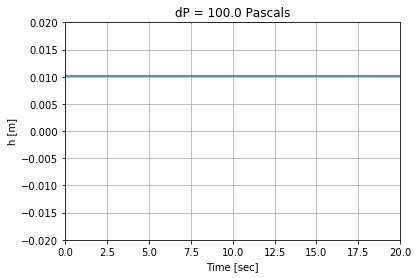

In [2]:
def model1(deltaP = 100.0):
    h = deltaP/(rho*g)
    plt.axis(axis)
    plt.plot(plt.xlim(),[h,h])
    plt.grid()
    plt.xlabel('Time [sec]')
    plt.ylabel('h [m]')
    plt.title('dP = {0:5.1f} Pascals'.format(deltaP))

interact(model1,deltaP=(-200,200,20.0));

<a id="model2"></a>
## Model 2. Dynamic Response with Negligible Viscosity

The second model for the manometer includes the dynamics associated with moving a mass $m$ of the liquid column held within the manometer. For this model we will chose a different measure of displacem


The net force on the liquid column is due to the applied pressure differential, $A\Delta P$, and the gravitational force due to the difference in liquid levels between the two arms of the manometer, $2 A \rho g$. $A$ is the cross-sectional area. From Newton's law

$$m \frac{d^2y}{dt^2} = A \Delta P - 2 A \rho g y$$

The mass of liquid is $m = \rho L A$ where $L$ is the total length of the liquid column.  After canceling a common factor $A$, the result is an inhomogeneous linear second order differential equation

$$ \frac{d^2y}{dt^2} + \frac{2 g}{L} y = \frac{1}{\rho L} \Delta P$$

At steady state this model reduces to the static case outlined in model 1 above. The dynamic case corresponds to an undamped harmonic oscillator with an angular frequency

$$\omega = \sqrt{\frac{2 g}{L}}$$

For numerical solution using the scipy libraries, it is necessary to convert the second order differential equation to a system of first order differential equations. 

$$\begin{align*}
\frac{dy}{dt} & = v \\
\frac{dv}{dt} & = -\frac{2g}{L} y + \frac{1}{\rho L} \Delta P 
\end{align*}$$

    natural frequency = 1.7 rad/sec
period of oscillation = 3.8 seconds


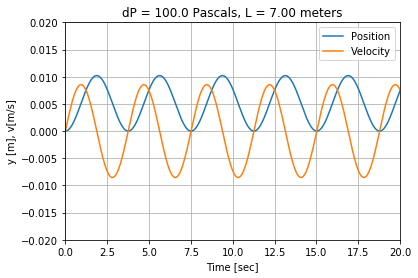

In [3]:
def model2(deltaP=100, L = 7.0):

    def deriv(X,t):
        x,v = X
        xdot = v
        vdot = -(2*g/L)*x + deltaP/rho/L
        return [xdot,vdot]

    IC = [0,0]
    
    w = np.sqrt(2*g/L)
    print("    natural frequency = {0:0.1f} rad/sec".format(w))
    print("period of oscillation = {0:0.1f} seconds".format(2*np.pi/w))
    
    sol = odeint(deriv,IC,t)
    plt.axis(axis)
    plt.plot(t,sol)
    plt.grid()
    plt.xlabel('Time [sec]')
    plt.ylabel('y [m], v[m/s]')
    plt.title('dP = {0:5.1f} Pascals, L = {1:4.2f} meters'.format(deltaP,L))
    plt.legend(['Position','Velocity'])
    
interact(model2, deltaP = (-200,200,1), L = (0.2,10,0.1));

<a id="model3"></a>
## Model 3. Dynamic Response with Viscous Dissipation

This third model for manometer incorporates the energy loss due to viscous dissipation in fluid motion. The pressure drop due to the laminar flow of incompressible Newtonian fluid in a long pipe with circular cross-section is given by the Hagen-Poiseuille equation

$$\Delta P_{drag} = \frac{32 \mu L v}{d^2}$$

where $\mu$ is the dynamic viscosity and $d$ is pipe diameter. Doing a balance of forces acting on the fluid column

$$\rho AL\frac{d^2y}{dt^2} + \frac{32\mu L A}{d^2}v + 2 A \rho g y = A \Delta P$$

Denoting $\nu = \frac{\mu}{\rho}$ as the kinematic viscosity, substituting for velocity $\frac{dy}{dt} = v$ leaves

$$\frac{d^2y}{dt^2} + \frac{32 \nu }{d^2}\frac{dy}{dt} + \frac{2g}{L} y = \frac{1}{\rho L} \Delta P$$

This can be recast as a pair of first-order linear differential equations

$$\begin{align*}
\frac{dy}{dt} & = v \\
\frac{dv}{dt} & = -\frac{2g}{L} y - \frac{32 \nu }{d^2}v + \frac{1}{\rho L} \Delta P 
\end{align*}$$

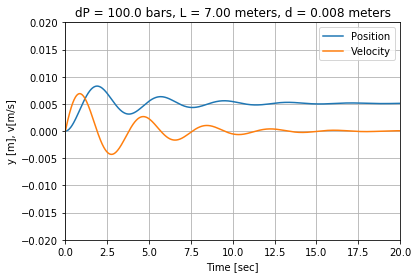

In [4]:
def model3(dP = 100.0, L = 7.0, d = 0.008):

    def deriv(X,t):
        y,v = X
        ydot = v
        vdot = -(2*g/L)*y - (32*nu/d**2)*v + dP/rho/L
        return [ydot,vdot]

    IC = [0,0]
    sol = odeint(deriv,IC,t)
    plt.axis(axis)
    plt.plot(t,sol)
    plt.grid()
    plt.xlabel('Time [sec]')
    plt.ylabel('y [m], v[m/s]')
    plt.title('dP = {0:5.1f} bars, L = {1:4.2f} meters, d = {2:5.3f} meters'.format(dP,L,d))
    plt.legend(['Position','Velocity'])

w  = interactive(model3, dP=(-200,200,20), L = (0.2,30,0.1), d=(0.001,0.020,0.001));
w.children[2].readout_format = '.3f'
w

<a id="model4"></a>
## Model 4. Second Order System in Standard Form

Standard form of a damped second order system is

$$\tau^2\frac{d^2y}{dt^2} + 2\zeta\tau\frac{dy}{dt} + y = K u(t)$$

Examples include buildings, car suspensions, other structures. Starting with the model equation 

$$\frac{d^2y}{dt^2} + \frac{32 \nu }{d^2}\frac{dy}{dt} + \frac{2g}{L} y = \frac{1}{\rho L} \Delta P$$

The first step is to normalize the zeroth order term in $y$ and compare to the second-order model in standard form

$$\underbrace{\frac{L}{2g}}_{\tau^2}\frac{d^2y}{dt^2} + \underbrace{\frac{16 \nu L}{g d^2}}_{2\zeta\tau}\frac{dy}{dt} + y = \underbrace{\frac{1}{2\rho g}}_K \underbrace{\Delta P}_{u(t)}$$

Solving for the coefficients in standard form

$$\begin{align*}
K & = \frac{1}{2\rho g}\\
\tau & = \sqrt{\frac{L}{2g}} \\
\zeta & = \frac{8\nu}{d^2}\sqrt{\frac{2L}{g}}
\end{align*}$$


#### Undamped ($\zeta = 0$)

#### Underdamped ($\zeta < 1$)

#### Critically damped ($\zeta = 1$)

$$d_\text{critical damping} = \left(\frac{128 \nu^2 L}{g}\right)^\frac{1}{4}$$

#### Overdamped ($\zeta > 1$)

In [5]:
K = 1/2/rho/g
tau = np.sqrt(L/2/g)
zeta = (8*nu/d**2)*np.sqrt(2*L/g)
print(K,tau,zeta)


dcritical = (128*nu*nu*L/g)**0.25
print(dcritical)

5.10204081632653e-05 0.597614304667 0.00149403576167
0.0030922207027757817


<a id="model5"></a>
## Model 5. Dynamic Response to Sinusoidal Input

$$\frac{d^2y}{dt^2} + \frac{32 \nu }{d^2}\frac{dy}{dt} + \frac{2g}{L} y = \frac{1}{\rho L} \Delta P$$

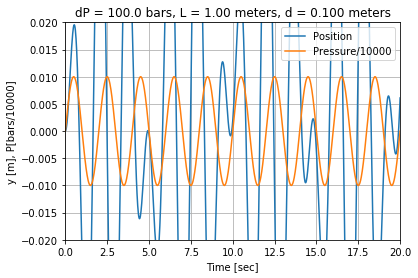

In [6]:
def model4(dP=100.0, L=1.0, d=0.10, freq=0.5):

    def deriv(X,t):
        x,v = X
        xdot = v
        vdot = -(2*g/L)*x - (32*nu/d**2)*v + dP*np.sin(2.0*np.pi*freq*t)/rho/L
        return [xdot,vdot]

    IC = [0,0]
    sol = odeint(deriv,IC,t)
    plt.axis(axis)
    plt.plot(t,sol[:,1])
    plt.plot(t,dP*np.sin(2.0*np.pi*freq*t)/10000)
    plt.grid()
    plt.xlabel('Time [sec]')
    plt.ylabel('y [m], P[bars/10000]')
    plt.title('dP = {0:5.1f} bars, L = {1:4.2f} meters, d = {2:5.3f} meters'.format(dP,L,d))
    plt.legend(['Position','Pressure/10000'])

interact(model4, dP=(-200,200,20), L = (0.2,5,0.1), d=(0.01,0.20,0.002), freq=(0,4,0.01));

<a id="model6"></a>
## Model 6. State Space Representation

State space models are widely used in textbooks, software, and the research literature to represent linear systems. It's a generic model that represents a system with inputs and outputs. Here's how to recast out manometer model is time-varying pressure as a state model where the liquid level is the measured output.

Start with the model written as a differential equation

$$\frac{d^2y}{dt^2} + \frac{32\nu}{d^2}\frac{dy}{dt} + \frac{2g}{L} y = \frac{1}{\rho L} \Delta P$$

Assemble the dependent variables in a vector, and rewrite using matrix/vector operations.

$$\begin{align*}
\frac{d}{dt}
\left[\begin{array}{c}y \\ v\end{array}\right]
& =
\left[\begin{array}{cc}0 & 1 \\ - \frac{2g}{L} & -\frac{32\nu}{d^2} \end{array}\right]
\left[\begin{array}{c}y \\ v\end{array}\right]
+
\left[\begin{array}{c}0 \\ \frac{1}{\rho L}\end{array}\right]
\left[\Delta P\right] \\
\left[y\right]
& =
\left[\begin{array}{c} 1 & 0\end{array}\right]
\left[\begin{array}{c}y \\ v\end{array}\right]
+
\left[0\right]
\left[\Delta P\right]
\end{align*}
$$

Use standard symbols to label the vectors and matrices.

$$\begin{align*}
\frac{d}{dt}
\underbrace{\left[\begin{array}{c}y \\ v\end{array}\right]}_{x}
& =
\underbrace{\left[\begin{array}{cc}0 & 1 \\ - \frac{2g}{L} & -\frac{32\nu}{d^2} \end{array}\right]}_{A}
\underbrace{\left[\begin{array}{c}y \\ v\end{array}\right]}_{x}
+
\underbrace{\left[\begin{array}{c}0 \\ \frac{1}{\rho L}\end{array}\right]}_{B}
\underbrace{\left[\Delta P\right]}_{u} \\
\underbrace{\left[y\right]}_{y} 
& =
\underbrace{\left[\begin{array}{c} 1 & 0\end{array}\right]}_{C}
\underbrace{\left[\begin{array}{c}y \\ v\end{array}\right]}_{x}
+
\underbrace{\left[0\right]}_{D}
\underbrace{\left[\Delta P\right]}_{u}
\end{align*}
$$

The result is a model of a linear system in a standard state space representation. 

$$\begin{align*}
\frac{dx}{dt} & = Ax + Bu \\
y & = Cx + Du
\end{align*}$$



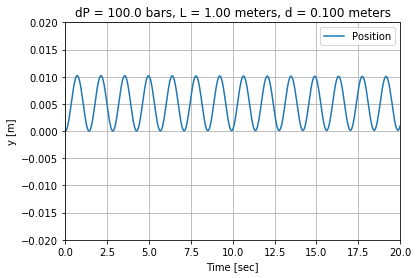

In [7]:
def model6(dP=100, L=1.0, d=0.10):

    A = [[0,1],[-2*g/L, -32*nu/(d**2)]]
    B = [[0],[1/rho/L]]
    C = [[1,0]]
    D = [[0]]
    
    sys = ss(A,B,C,D)
    y,tout = step(sys,t);

    plt.axis(axis)
    plt.plot(t,dP*y)
    plt.grid()
    plt.xlabel('Time [sec]')
    plt.ylabel('y [m]')
    plt.title('dP = {0:5.1f} bars, L = {1:4.2f} meters, d = {2:5.3f} meters'.format(dP,L,d))
    plt.legend(['Position'])
    
interact(model6, dP=(-200,200,1), L = (0.2,5,0.1), d=(0.01,0.20,0.002));

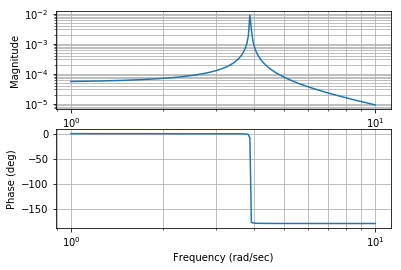

In [11]:
w = np.logspace(0,1,200)

def model6(L=1.0, d=0.10):

    A = [[0,1],[-2*g/L, -32*nu/(d**2)]]
    B = [[0],[1/rho/L]]
    C = [[1,0]]
    D = [[0]]

    mano = ss(A,B,C,D)
    bode(mano,w);
    
interact(model6, L = (0.2,5,0.1), d=(0.01,0.20,0.002));

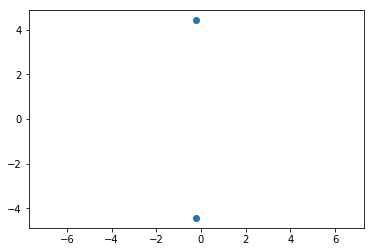

In [9]:
w = np.logspace(0,1,200)

def model6(L=1.0, d=0.10):

    A = [[0,1],[-2*g/L, -128*nu/(np.pi*d**4)]]
    B = [[0],[1/rho/L]]
    C = [[1,0]]
    D = [[0]]

    e_vals,e_vecs = la.eig(A)
    
    plt.axis([-5,5,-5,5])
    plt.axis('equal')
    plt.plot(e_vals.real,e_vals.imag,'o')
    
    
    
interact(model6, L = (0.2,5,0.1), d=(0.01,0.20,0.002));

# One Compartment Pharmacokinetics

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338).

### Summary

Pharmacokinetics is a branch of pharmacology that studies the fate of chemical species in living organisms. The diverse range of applications includes the administration of drugs and anesthesia in humans. This notebook introduces a one compartment model for pharmacokinetics, and shows how it can be used to determine strategies for the intravenous administration of an antibiotic.

The notebook demonstrates the simulation and analysis of systems modeled by a single first-order linear differential equation.

## Antibiotics

Let's consider the administration of an antibiotic to a patient. Concentration $C$ refers to the concentration of the antibiotic in blood plasma with units [mg/liter]. 

**Minimum Inhibitory Concentration (MIC)** The minimum concentration of the antibiotic that prevents growth of a particular bacterium.

**Minimum Bactricidal Concentration (MBC)** The lowest concentration of the antibiotic that kills a particular bacterium.

Extended exposure to an antibiotic at levels below MBC leads to [antibiotic resistance](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4378521/).

## Model Description

A simple pharmacokinetic model has the same form as a model for the dilution of a chemical species in a constant volume stirred-tank mixer.  For a stirred-tank reactor with constant volume $V$, volumetric outlet flowrate $Q$, and inlet mass flow $u(t)$,

$$V \frac{dC}{dt} = u(t) - Q C(t)$$

where $C$ is concentration in units of mass per unit volume. In this pharacokinetics application, $V$ refers to blood plasma volume, and $Q$ to the clearance rate.

## Problem Statement 1

The minimum inhibitory concentration (MIC) of a particular organism to a particular antibiotic is 5 mg/liter, the minimum bactricidal concentration (MBC) is 8 mg/liter. Assume the plasma volume $V$ is 4 liters with a clearance rate $Q$ of 0.5 liters/hour. 

An initial intravenous antibiotic dose of 64 mg results in an initial plasma concentration $C_{initial}$ of 64mg/4 liters = 16 mg/liter.  How long will the concentration stay above MBC?  Above MIC?

## Solution Strategy 1: Simulation from a Known Initial Condition

For this first simulation we compute the response of the one compartment model due starting with an initial condition $C_{initial}$, and assuming input $u(t) = 0$.  

### Step 1. Initialization

Generally the first steps in any Jupyter notebook are to 

1. Initialize the plotting system.
2. Import the `numpy` library for basic mathematical functions.
3. Import the `matplotlib.pyplot` library for plotting.

In addition, for this application we also import `odeint` function for solving differential equations from the `scipy.integrate` library.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### Step 2. Enter Parameter Values

In [2]:
V = 4          # liters
Q = 0.5        # liters/hour
MIC = 5        # mg/liter
MBC = 8        # mg/liter

Cinitial = 16  # mg/liter

### Step 3. A Function the RHS of the Differential equation

$$\frac{dC}{dt} = \frac{1}{V}u(t) - \frac{Q}{V}C$$

where $u(t) = 0$.

In [3]:
def u(t):
    return 0

def deriv(C,t):
    return u(t)/V - (Q/V)*C

### Step 4. Solution and Visualization

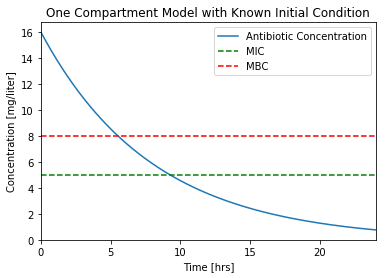

In [4]:
t = np.linspace(0,24,1000)
C = odeint(deriv, Cinitial, t)

def plotConcentration(t,C):
    plt.plot(t,C)
    plt.xlim(0,max(t))
    plt.plot(plt.xlim(),[MIC,MIC],'g--',plt.xlim(),[MBC,MBC],'r--')
    plt.legend(['Antibiotic Concentration','MIC','MBC'])
    plt.xlabel('Time [hrs]')
    plt.ylabel('Concentration [mg/liter]')
    plt.title('One Compartment Model with Known Initial Condition');
    
plotConcentration(t,C)
plt.savefig('../images/Pharmaockinetics1.png')

### Step 5. Analysis of the Results

Let's compare our results to a typical experimental result. 

| | |
| :-: | :-: |
|![](../images/Pharmaockinetics1.png)|![](../images/nihms-475924-f0001.jpg)|

We see that that the assumption of a fixed initial condition is questionable. Can we fix this?

[Levison, Matthew E., and Julie H. Levison. “Pharmacokinetics and Pharmacodynamics of Antibacterial Agents.” Infectious disease clinics of North America 23.4 (2009): 791–vii. PMC. Web. 8 May 2017.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3675903/)

## Solution Strategy 2: Time-Dependent Input

For the next simulation we will assume the dosing takes place over a short period of time $\delta t$. To obtain a total dose $U_{dose}$ in a time period $\delta t$, the mass flow rate rate must be

$$u(t) = 
\begin{cases}
U/ \delta t \qquad \mbox{for } 0 \leq t \leq \delta t \\
0 \qquad \mbox{for } t \geq \delta t
\end{cases}
$$

Before doing a simulation, we will write a Python function for $u(t)$. 

In [5]:
# parameter values
dt = 1.5         # length hours
Udose = 64       # mg

# function defintion
def u(t):
    if t <= dt:
        return Udose/dt
    else:
        return 0

This code cell demonstrates the use of a list comprehension to apply a function to each value in a list.

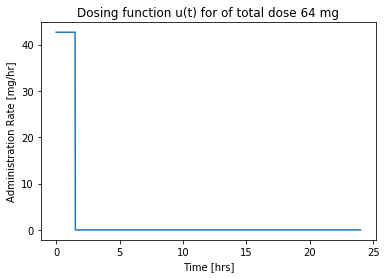

In [6]:
# visualization
t = np.linspace(0,24,1000)    # create a list of time steps
y = [u(tau) for tau in t]         # list comprehension
plt.plot(t,y)
plt.xlabel('Time [hrs]')
plt.ylabel('Administration Rate [mg/hr]')
plt.title('Dosing function u(t) for of total dose {0} mg'.format(Udose))

Simulation

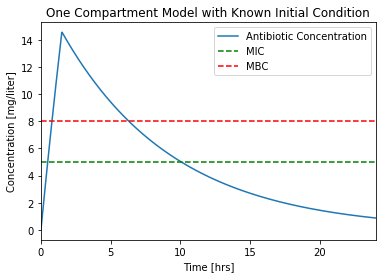

In [7]:
Cinitial = 0
t = np.linspace(0,24,1000)
C = odeint(deriv, Cinitial, t)

plotConcentration(t,C)
plt.savefig('../images/Pharmaockinetics2.png')

### Analysis of the Results

Let's compare our results to a typical experimental result. 

| | |
| :-: | :-: |
|![](../images/Pharmaockinetics2.png)|![](../images/nihms-475924-f0001.jpg)|

While it isn't perfect, this is a closer facsimile of actual physiological response.

[Levison, Matthew E., and Julie H. Levison. “Pharmacokinetics and Pharmacodynamics of Antibacterial Agents.” Infectious disease clinics of North America 23.4 (2009): 791–vii. PMC. Web. 8 May 2017.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3675903/)

## Problem Statement 2

The minimum inhibitory concentration (MIC) of a particular organism to a particular antibiotic is 5 mg/liter, the minimum bactricidal concentration (MBC) is 8 mg/liter. Assume the plasma volume $V$ is 4 liters with a clearance rate $Q$ of 0.5 liters/hour. 

Design an antibiotic therapy to keep the plasma concentration above the MIC level for a period of 96 hours. 

## Solution Strategy 3: Periodic Dosing

Finally, we'll consider the case of repetitive dosing where a new dose is administered every $t_{dose}$ hours. The trick to this calculation is the Python `%` operator which returns the remainder following division. This is a very useful tool for creating complex repetitive functions.

In [8]:
# parameter values
td = 2           # length of administration for a single dose
tdose = 8        # time between doses
Udose = 42       # mg

# function defintion
def u(t):
    if t % tdose <= dt:
        return Udose/td
    else:
        return 0

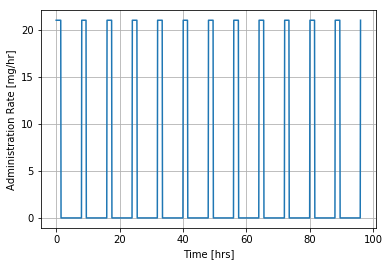

In [9]:
# visualization
t = np.linspace(0,96,1000)    # create a list of time steps
y = [u(t) for t in t]         # list comprehension

plt.plot(t,y)
plt.xlabel('Time [hrs]')
plt.ylabel('Administration Rate [mg/hr]')
plt.grid()

The dosing function $u(t)$ is now applied to the simulation of drug concentration in the blood plasma. A fourth argument is added to `odeint(deriv, Cinitial, t, tcrit=t)` indicating that special care must be used for every time step. This is needed in order to get a high fidelity simulation that accounts for the rapidly varying values of $u(t)$.

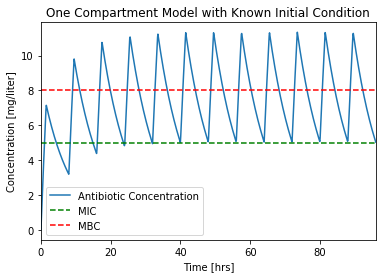

In [10]:
Cinitial = 0
t = np.linspace(0,96,1000)
C = odeint(deriv, Cinitial, t, tcrit=t)
plotConcentration(t,C)

# Exercise 1

The purpose of the dosing regime is to maintain the plasma concentration above the MIC level for at least 96 hours. Assuming that each dose is 64 mg, modify the simulation and find a value of $t_{dose}$ that results satisfies the MIC objective for a 96 hour period.  Show a plot concentration versus time, and include Python code to compute the total amount of antibiotic administered for the whole treatment.

# Exercise 2

Consider a continous antibiotic injection at a constant rate designed to maintain the plasma concentration at minimum bactricidal level. Your solution should proceed in three steps:

1. First, by hand, set up and solve the steady state equation to find the desired constant dosage rate. 
2. Modify the Python function for $u(t)$ to simulate the desired flowrate.
3. Verify your result by repeating the above simulation using your function for $u(t)$. 

# Process Control - Outline

## 1. Basic Concepts

1. Process Control
   1. Disturbance Variables (DV)
   2. Manipulated Variables (MV)
   3. Controlled Variables (CV)
   4. Process Variables (PV)
   5. Setpoint (SP or SV)
   
2. Modes of Control
   1. Feedforward Control
      * Compenstation for setpoint and measured disturbances
      * Depends on a model able to predict response to DV and MV
   2. Feedback Control
      * Improved speed of response
      * Suppress unmeasured disturbances
      * Insensitive to model error
            
3. Simple Control Algorithms (without internal state)
   1. Relay control
      * Simple, effective
      * Requires minimum of process knowledge
      * Sustained oscillation
      * Requires hysteresis to suppress measurement noise
      * Large, sustained control action
   2. Proportional control
      * Results in a steady-state offset from the setpoint
      * Requires specification of a control gain $K_p$
      
4. Control Implementation in Python
   1. Basic control loop (OsCAR)
      * Observe
      * Compute
      * Actuate
      * Record
   2. Functions to Implement
      * Relay control
      * Proportional control


## 2. Process Dynamics

1. Modeling for process control provides two key benefits:
   1. Improved control design through simulation
   2. Incorporating models into the control strategy.

2. Two main approaches to modeling for process control:
   1. Empirical (or 'black-box') models that reproduce essential dynamical responses.
   2. First Principles models
      * material and energy balances
      * detailed understanding of physico-chemical phenomena.

3. Using empirical models for process control.
   1. Concepts
      * Inputs/Outputs
      * Deviation Variables
      * Step Response
      * Linear vs Nonlinear Response
      * Gains
      * Time constants
   2. Typical Models
      * First Order ($K$, $\tau$)
      * First Order with Deadtime  ($K$, $\tau$, $\theta$)
      * Second Order - Underdamped ($K$, $\tau_1$, $\tau_2$)
      * Second Order - Critically Damped ($K$, $\tau$)
      * Second Order - Overdamped ($K$, $\tau$, $\zeta$)
      * Integrating Processes
   3. Fitting empirical models
      * Simulation and comparison
      * Regression
      
4. First Principles Models 
   1. Developing models
   2. Solving typical models with odeint

## TCLab Experiments

1. Introduction to the TCLab Laboratory
   1. Install tclab
   2. Install any needed serial drivers
   3. Verify operation
      * LED operation
   4. Review basic capabilities
      * TCLab open and close
      * clock function
      * Historian and Plotter
   5. Implementing a Thermostat
   
2. Feedback Control
   1. Relay control
   2. Relay control with hysteresis
   3. Proportional control
   4. Devise your own control
   
3. Empirical Process Models
   1. Single input testing at 40% and 60% power
   2. Model fitting
      * First order
      * First order with dead time
      * Second order
      
4. PID Control
   1. Single loop control
   2. Dual loop control
   3. Setpoint tracking
   4. Disturbance rejection
   
5. Estimating Unmeasured Process Variables
   1. State Space model
   2. Observers

6. Single Variable Model Predictive Control

7. Multivariable MPC

8. Economic Control

# Introduction to Python

### A Tutorial by Jacob Gerace


## Variables

In [2]:
#A variable stores a piece of data and gives it a name
answer = 42

#answer contained an integer because we gave it an integer!

is_it_thursday = True
is_it_wednesday = False

#these both are 'booleans' or true/false values

pi_approx = 3.1415

#This will be a floating point number, or a number containing digits after the decimal point

my_name = "Jacob"
#This is a string datatype, the name coming from a string of characters

#Data doesn't have to be a singular unit

#p.s., we can print all of these with a print command. For Example:
print(answer)
print(pi_approx)

42
3.1415


### More Complicated Data Types


In [3]:

#What if we want to store many integers? We need a list!
prices = [10, 20, 30, 40, 50]

#This is a way to define a list in place. We can also make an empty list and add to it.
colors = []

colors.append("Green")
colors.append("Blue")
colors.append("Red")

print(colors)

#We can also add unlike data to a list
prices.append("Sixty")

#As an exercise, look up lists in python and find out how to add in the middle of a list!

print(prices)
#We can access a specific element of a list too:

print(colors[0])
print(colors[2])

#Notice here how the first element of the list is index 0, not 1! 
#Languages like MATLAB are 1 indexed, be careful!

['Green', 'Blue', 'Red']
[10, 20, 30, 40, 50, 'Sixty']
Green
Red


### Using Variables

In [4]:
float1 = 5.75
float2 = 2.25
#Addition, subtraction, multiplication, division are as you expect

print(float1 + float2)
print(float1 - float2)
print(float1 * float2)
print(float1 / float2)

#Here's an interesting one that showed up in the first homework in 2017. Modulus: 
print(5 % 2)

8.0
3.5
12.9375
2.5555555555555554
1


### Importing in Python: Math and plotting

1.749199854809259
9.487735836358526
32.0
32.0


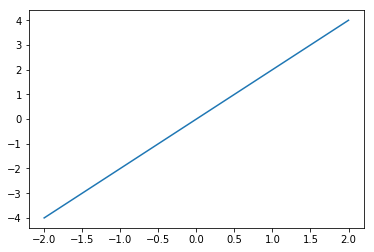

In [7]:
#Just about every standard math function on a calculator has a python equivalent pre made.
#however, they are from the 'math' package in python. Let's add that package!
import math
print(math.log(float1))
print(math.exp(float2))
print(math.pow(2,5))
# There is a quicker way to write exponents if you want:
print(2.0**5.0)

#We can plot easily in Python like in matlab, just import the relevant package!
%matplotlib inline
import matplotlib.pyplot as plt

x_vals = [-2, -1, 0, 1, 2]
y_vals = [-4, -2, 0, 2, 4]
plt.plot(x_vals, y_vals)

### Loops in Python

In [6]:
#Repeat code until a conditional statement ends the loop

#Let's try printing a list
fib = [1, 1, 2, 3, 5, 8]

#While loops are the basic type
i = 0
while(i < len(fib)):
    print(fib[i])
    i = i + 1
    
#In matlab, to do the same thing you would have the conditional as: counter < (length(fib) + 1)
#This is because matlab starts indexing at 1, and python starts at 0.
    
#The above type of loop is so common that the 'for' loop is the way to write it faster.

print("Let's try that again")
#This is most similar to for loops in matlab
for i in range(0, len(fib)) :
    print(fib[i])

print("One more time:")
#Or you can do so even neater
for e in fib:
    print(e)

1
1
2
3
5
8
Let's try that again
1
1
2
3
5
8
One more time:
1
1
2
3
5
8


### Additional Resources
* If you still feel VERY lost: [Code Academy](https://www.codecademy.com/learn/python)

* If you want a good reference site: [Official Python Reference](https://docs.python.org/2/reference/)

* If you want to learn python robustly: [Learn Python the Hard Way](https://learnpythonthehardway.org/book/)

* Feel free to contact me at: **jgerace (at) nd (dot) edu**


# Python Tutorial #2

### A Tutorial by Jacob Gerace


### Conditionals in Python

In [24]:
#Sometimes you want to execute code only in certain circumstances. 

#Change answer and see what code is executed:
answer = 42

if answer == 42:
    print('This is the answer to the ultimate question')
elif answer < 42:
    print('This is less than the answer to the ultimate question')
else:
    print('This is more than the answer to the ultimate question')
print('This print statement is run no matter what because it is not indented!')

#An if statement is an example of a structure that creates a new block. The block includes all of the code that is 
#indented. The indentation (tab character) is imperative. Don't forget it!

#This is normally just good coding style in other languages, but in python it isn't optional

#We can check multiple things at once using boolean operations
snowy = True
day = "Monday"

#How long does it take me to get to class in the morning?

if (snowy == False) and (day != "Monday"):
    #and is boolean and. True only if both are true. False otherwise
    time = 7
elif (snowy == True) and (day == "Monday"):
    time = 11
elif (rainy == True) or (day == "Monday"):
    time = 9
    
print("It takes me %d minutes" %(time))
    
#You can structure these statements more neatly if you "nest" if statements (put an if statement inside an if statement)
#But this is just for edification.

This is the answer to the ultimate question
This print statement is run no matter what because it is not indented!
It takes me 11 minutes


### Functions in Python

In [15]:
#We can separate off code into functions, that can take input and can give output. They serve as black boxes from the 
#perspective of the rest of our code

#use the def keyword, and indent because this creates a new block
def print_me( string ):
    print(string)
   
   #End with the "return" keyword
    return

#Your functions can return data if you so choose
def step(x):
    if (x < 0):
        return -1
    elif (x > 0):
        return 1

#call functions by repeating their name, and putting your variable in the parenthesis. 
#Your variable need not be named the same thing, but it should be the right type!

print(step(-1))
print(step(1))

#what happens for x = 0?
print(step(0))

#Python automatically adds in a "return none" statement if you are missing one. 
#If you see "none" make sure your program can work with that!


#Fix the return none issue
def step_v2(x):
    if (x < 0):
        return -1
    elif (x >= 0):
        return 1
    
print(step_v2(0))

-1
1
None
1


### Numpy - "The Fundamental Package for Scientific Computing with Python"

[1 2 3]
1
[10 10 10]
[-8 -6 -4]
[ 9 16 21]
[ 0.11111111  0.25        0.42857143]
[[14 14 14]
 [32 32 32]
 [50 50 50]]
-9.51619735393e-16


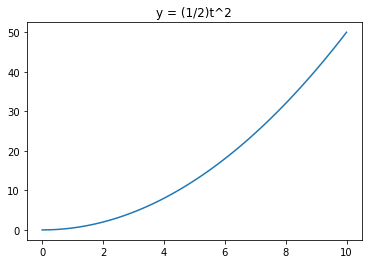

In [16]:
import numpy as np
#Here, we grab all of the functions and tools from the numpy package and store them in a local variable called np.
#You can call that variable whatever you like, but 'np' is standard.

#numpy has arrays, which function similarly to python lists. 
a = np.array([1,2,3])
b = np.array([9,8,7])
#Be careful with syntax. The parentheses and brackets are both required!
print(a)

#Access elements from them just like you would a regular list
print(a[0])

#Element-wise operations are a breeze!
c = a + b
d = a - b
e = a * b
f = a / b

print(c)
print(d)
print(e)
print(f)
#This is different from MATLAB where you add a dot to get element wise operators.

#What about multi-dimensional arrays? Matrices!

#You just nest lists within lists! 
A = np.array( [[1,2,3], [4,5,6], [7,8,9]] )
B = np.array( [[1,1,1], [2,2,2], [3,3,3]] )

#Then matrix multlication
C = np.matmul(A,B)
 
print(C)

#Or determinants:
print(np.linalg.det(A))


#Now, let's use numpy for something essential for you: Numeric Integration

#Define the function you want to integrate....
#dy/dt = t:
def deriv(y,t):
    return t
#Note this doesn't use y in the return. That is okay, but we need to include it just to satisfy the function we will use.

#Set your initial or boundary condition
IC = 0

#Give the number of points to evaluate the integration
start_time = 0
end_time = 10
num_times = 101
times = np.linspace(start_time, end_time, num_times)

from scipy.integrate import odeint
integrated_func = odeint(deriv,IC,times)

#Can we plot the result? You betcha. Just import a new package
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact

plt.plot(times, integrated_func)
plt.title("y = (1/2)t^2")
#Very similar to MATLAB!

### Additional Resources
* If you still feel VERY lost: [Code Academy](https://www.codecademy.com/learn/learn-python)

* If you want a good reference site: [Official Python Reference](https://docs.python.org/3/reference/)

* If you want to learn python robustly: [Learn Python the Hard Way](https://learnpythonthehardway.org/book/)

* Feel free to contact me at: **jgerace (at) nd (dot) edu**


# Python Tutorial 3 - Numeric Integration Revisited

### Code Academy Sidenote

* https://www.codecademy.com/learn/learn-python

### Markdown/Latex Sidenote

Jupyter-notebooks are very convenient because they include these markdown blocks to include discussion of the material.

Programs like Microsoft Word are examples of a "What you see is what you get" editor. In Markdown, you use characters and symbols to format your text, and then actually compile them.

For instance, I've been making liberal use of the header feature using the '#' pound/hashtag symbol. **Double click on this cell to see how I'm creating the text below.**

# First Header
## Second Header
### Tertiary Header
#### Etc

* Bullet Point
* Bullet Point 2
* Etc.

**Bolded Text**

_Italicized Text_

Those are a couple examples of some basic formatting. You can see more examples throughout this tutorial. The sidenote above has an example of a link, while there are examples of a chart, and a photo below. Take a look and see if you can reproduce it on your own!

For further reference: [Github's Markdown Guide](https://guides.github.com/features/mastering-markdown/)

## Latex Side Note

A big included feature in Jupyter-notebook markdown blocks is that you have the ability to include LaTeX formatted text as well. 

LaTeX (pronounced "La-tech") is similar to a markdown language in and of itself (it is not What-You-See-Is-What-You-Get). It is considerably more feature-full than markdown, but also has a bigger learning curve. I recommend that you use it just for math, as Markdown can't provide Math formatting.

* Start latex formatting with '\$\$' and end it with another '\$\$'
$$ math goes here $$

* All alphabetic characters are included in a LateX math statement is intended to be a variable, and is italicized. Basic math is very intuitive due to this.

$$ y = mx + b $$

* As soon as you get to fractions, you have to learn some LaTeX commands. Here we'll use the '\frac{}{}' command

$$ \frac{3}{5} $$

* I prefer creating equations in LaTeX to word in large part due to symbols. Most greek letters can be added with the '\letter' command. For instance '\lambda'

$$ \lambda \leq \pi + \Pi $$

* Most common functions are included as operators in LaTeX:

$$ \log_b(a) = \frac{\log(a)}{\log(a)} $$

Just that should be enough to cover most of the math you'll need in this course. Don't feel like you _have_ to use LaTeX. It is also acceptable to do your work out (neatly) on paper and include a photo.

# Hare and Lynx Example

### Adapted from [Dr. Kantor's Notes](https://github.com/jckantor/CBE30338/blob/master/notebooks/HareLynx/Hare%20and%20Lynx%20Population%20Dynamics.ipynb) 

### Introduction
We'd like to model the number of Hares and Lynx in a certain population of animals. 
![](http://boredomtherapy.com/wp-content/uploads/2015/12/14-canadian-lynx-paws-cute.jpg)
![](http://www.cbc.ca/kidscbc2/content/contests/cute_snowshoe1.jpg)

As cute as that Lynx is, it will prey on the Hare to the exclusion of all other animals if possible. This means the population levels of the Lynx and Hare are intrinsically related, see the pelt trading data for the Hudson's Bay Company:

![](MainLynx.jpg)



### Modeling

We can start with the basic equation of: change = in - out

$$
\frac{dH}{dt} = (Hare Birth Rate) - (Hare Death Rate) \\
\frac{dL}{dt} = (Lynx Birth Rate) - (Lynx Death Rate)
$$


#### Relevant Parameters

| Parameter | Symbol | Value |
| - | :----: | :---: |
| Lynx/Hare Predation Rate | $a$ | 3.2 |
| Lynx/Hare Conversion | $b$ | 0.6 |
| Lynx/Hare Michaelis Constant| $c$ | 50 |
| Lynx Death Rate | $d$ | 0.56 |
| Hare Carrying Capacity| $k$ | 125 |
| Hare Reproduction Rate | $r$ | 1.6 |

#### Model Equations
These parameters can be used to form a model:

$$
\frac{dH}{dt} = rH(1 - \frac{H}{k}) - \frac{aHL}{c + H}  \\
\frac{dL}{dt} = a \frac{bHL}{c + H} - d*L
$$

The focus of this tutorial is not on the development of these model equations, but do review the equations and try to make sense of them. It can help you in debugging steps later should you have an error.

### Programming and Plotting

#### Step 1: Initialization

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

#### Step 2: Default Parameter Values

In [6]:
a = 3.2
b = 0.6
c = 50
d = 0.56
k = 125
r = 1.6

#### Step 3: Define the differential equations

In [7]:
def deriv(X,t):
    H,L = X
    dH =  r*H*(1-H/k) - a*H*L/(c+H)
    dL = b*a*H*L/(c+H) - d*L
    return [dH,dL]

#### Step 4: Integrate Differential Equations

In [8]:
# perform simulation
t = np.linspace(0,70,500)       # time grid
IC = [20,20]                    # initial conditions for H and L
sol = odeint(deriv,IC,t)        # compute solution
H,L = sol.transpose()           # unpack solution 

#### Step 5: Plot 

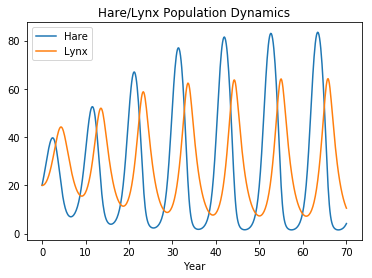

In [9]:
plt.plot(t,H,t,L)
plt.title('Hare/Lynx Population Dynamics')
plt.xlabel('Year')
plt.legend(['Hare','Lynx'])

If you have more than one thing to plot, we can make use of the subplot feature

Text(0.5,0,'Hare')

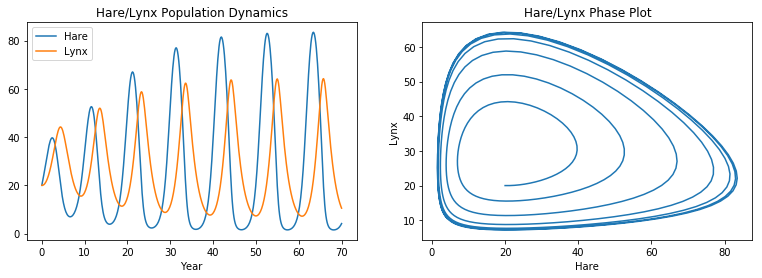

In [10]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.plot(t,H,t,L)
plt.title('Hare/Lynx Population Dynamics')
plt.xlabel('Year')
plt.legend(['Hare','Lynx'])

plt.subplot(1,2,2)
plt.plot(H,L)
plt.title('Hare/Lynx Phase Plot')
plt.ylabel('Lynx')
plt.xlabel('Hare')

# Second Order Linear Systems

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338).

### Summary

This notebook provides a review of the dynamics of second order linear systems, including step response characteristics and damping factor.


## Standard form

The standard form for a second order linear system is given by

$$\tau^2\frac{d^2y}{dt^2} + 2\zeta\tau\frac{dy}{dt} + y = K u(t)$$

where the symbols are defined in the following table.


| Quantity | Symbol$\ $ |
| :------ | :----: |
| Input    | $u(t)$ |
| Response | $y(t)$ |
| Steady State Gain | $K$ |
| Time Constant | $\tau$ |
| Damping Factor | $\zeta$ |
| Natural Frequency | $\omega_n = \frac{1}{\tau}$ |

The standard form assumes that a zero input (i.e, $u(t) = 0$) results in a zero response ($y(t) = 0$). In practice, the nominal or quiescent value of $y$ or $u$ may different from zero. In that case we would write

$$\tau^2\frac{d^2y}{dt^2} + 2\zeta\tau\frac{dy}{dt} + y - y_{ref} = K\left(u(t) - u_{ref}\right)$$

where $u_{ref}$ and $y_{ref}$ represent constant reference values.


## Step Response

The step response of a system corresponds to a system that is initially at steady with $u = u_{ref}$ with a steady response $y = y_{ref}$.  At time $t=0$ the input is incremented by a constant value U, i.e. $u = u_{ref} + U$ for $t \geq 0$.  The subsequent response $y(t) - y_{ref}$ is the **step response**.

Second order linear systems have rather elegant analytica solutions expressed using exponential and trignometric functions. There are three distinct cases that depend on the value of the damping factor $\zeta$.

### Overdamped ($\zeta > 1$)

In the case of a large damping factor $\zeta > 1$, the step response is given by 

$$y(t) = y_{ref} + KU\left(1 - \frac{\tau_1e^{-t/\tau_1} - \tau_2e^{-t/\tau_2}}{\tau_1 - \tau_2}\right)$$

where $\tau_1$ and $\tau_2$ are found by factor the polynomial

$$\tau^2s^2 + 2\zeta\tau s + 1 = (\tau_1s + 1)(\tau_2s + 1)$$

which for $\zeta \geq 1$ are given by

$$\begin{align*}
\tau_1 & = \frac{\tau}{\zeta - \sqrt{\zeta^2 -1}} \\
\tau_2 & = \frac{\tau}{\zeta + \sqrt{\zeta^2 -1}}
\end{align*}$$

### Critically Damped ($\zeta = 1$)

$$y(t) = y_{ref} + KU\left(1 - \left(1 + \frac{t}{\tau}\right)e^{-t/\tau}\right)$$

### Underdamped ($0 \leq \zeta < 1$)

$$y(t) = y_{ref} + KU\left[1 - e^{-\zeta t/\tau}\left(\cos\left(\omega t\right) + \frac{\zeta}{\sqrt{1-\zeta^2}}\,\sin\left(\omega t\right) \right)\right]$$

where

$$\omega = \frac{\sqrt{1-\zeta^2}}{\tau}$$




## Interactive Simulation

$$\begin{align*}
\frac{dy}{dt} & = v \\
\frac{dv}{dt} & = -\frac{1}{\tau^2}(y-y_{ref}) - \frac{2\zeta}{\tau}v + K\left(u(t)-u_{ref}\right)
\end{align*}$$

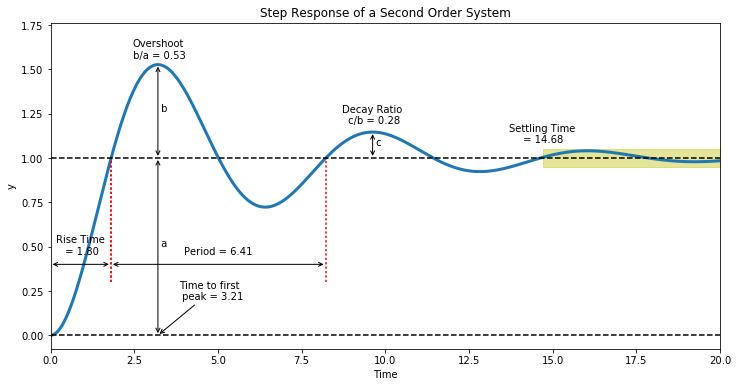

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from ipywidgets import interact

def simulation(yref=0, U=1, K=1, tau=1, zeta=0.2):

    def deriv(X,t):
        y,v = X
        ydot = v
        vdot = -(y-yref)/tau/tau - 2*zeta*v/tau + K*U/tau/tau
        return[ydot,vdot]

    # simulation  
    t = np.linspace(0,20*tau,1000)
    y = odeint(deriv, [yref,0], t)[:,0]
    
    # plot steady state line and bounds
    plt.figure(figsize=(12,6))

    
    # plot solution
    plt.plot(t,y,lw=3)
    plt.title('Step Response of a Second Order System')
    plt.xlabel('Time')
    plt.ylabel('y')
    
    # plot limits
    plt.ylim(plt.ylim()[0],1.1*plt.ylim()[1])
    plt.xlim(t[0],t[-1])
    dy = np.diff(plt.ylim())
    
    # arrow props
    ap1 = dict(arrowstyle="->")
    ap2 = dict(arrowstyle="<->")

    if zeta < 1:
        #overshoot
        os = np.exp(-np.pi*zeta/np.sqrt(1-zeta**2))
        
        # time to first peak
        tp = np.pi*tau/np.sqrt(1-zeta**2)
        yp = (1+os)*K*U + yref
          
        plt.text(tp,yp+0.02*dy,"Overshoot\n b/a = {0:0.2f}".format(os), ha='center')
        plt.annotate('',xy=(tp,K*U+yref),xytext=(tp,yp),arrowprops=ap2)
        plt.text(tp,(K*U+yref+yp)/2,' b')
        plt.annotate('',xy=(tp,yref),xytext=(tp,K*U+yref),arrowprops=ap2)
        plt.text(tp,K*U/2+yref,' a')
        plt.annotate("Time to first\n peak = {0:.2f}".format(tp),
                    xy=(tp,yref), xytext=(1.2*tp,0.2*K*U+yref),arrowprops=ap1)

        # rise time
        tr = t[np.where(np.diff(np.sign(y-yref-K*U))*np.sign(K*U)>0)[0][0]]
        if tr < plt.xlim()[1]:
            plt.plot([tr,tr],[0.3*K*U+yref,K*U+yref],'r:')
            plt.annotate('',xy=(plt.xlim()[0],0.4*K*U+yref),xytext=(tr,0.4*K*U+yref),
                         arrowprops=ap2)
            plt.text(plt.xlim()[0]+tr/2,0.42*K*U+yref+0.02*dy,
                    'Rise Time\n = {0:.2f}'.format(tr),ha='center')
        
        # period
        P = 2*np.pi*tau/np.sqrt(1-zeta**2)
        if tr + P < plt.xlim()[1]:
            plt.plot([tr,tr],[0.3*K*U+yref,K*U+yref],'r:')
            plt.plot([tr+P,tr+P],[0.3*K*U+yref,K*U+yref],'r:')
            plt.annotate('',xy=(tr,0.4*K*U+yref),xytext=(tr+P,0.4*K*U+yref),arrowprops=ap2)
            plt.text(tr+P/2,0.42*K*U+yref+0.02*dy,'Period = {0:.2f}'.format(P), ha='center')
        
        # second peak
        if tp + P < plt.xlim()[1]:
            plt.annotate('',xy=(tp+P,K*U+yref),xytext=(tp+P,K*U*(1+os**3)+yref),
                        arrowprops=ap2)
            plt.text(tp+P,K*U*(1+os**3/2)+yref,' c')
            plt.text(tp+P,K*U*(1+os**3)+yref+0.02*dy,
                    'Decay Ratio\n c/b = {0:.2f}'.format(os**2),va='bottom',ha='center')
        
        # settling time
        ts = -np.log(0.05)*np.sqrt(1-zeta**2)*tau/zeta
        if ts < plt.xlim()[1]:
            plt.fill_between(t[t>ts],0.95*K*U+yref,1.05*K*U+yref,alpha=0.4,color='y')
            plt.text(ts,1.05*K*U+yref+0.02*dy,
                     'Settling Time\n = {0:.2f}'.format(ts),ha='center')

            
    plt.plot(plt.xlim(),[yref,yref],'k--')
    plt.plot(plt.xlim(),[K*U+yref,K*U+yref],'k--')
    
interact(simulation, yref = (-10,10,0.1), U=(0.01,5,0.01), 
         K = (-5,5,0.01), zeta=(0.01,3,0.01), tau = (0.1,5.0,0.01));

## Performance Indicators for Underdamped Systems 

For an underdamped second order system, the desired performance metrics are given by the following by formulas in the following table.

| Quantity           | Symbol | Expression/Value                                       |
| :----------------: | :----: | :----------------------------------------------------: |
| Rise Time          | $t_r$  | Time to first SS crossing                              |
| Time to first peak | $t_p$  | $\frac{\pi\tau}{\sqrt{1-\zeta^2}}$                     |
| Overshoot          | OS     | $\exp\left(-\frac{\pi\zeta}{\sqrt{1-\zeta^2}}\right)$  |
| Decay Ratio        | DR     | $\exp\left(-\frac{2\pi\zeta}{\sqrt{1-\zeta^2}}\right)$ |
| Period             |        | $\frac{2\pi\tau}{\sqrt{1-\zeta^2}}$                    |
| Setting Time       | $t_s$  | Time to +/- 5% of SS                                   |

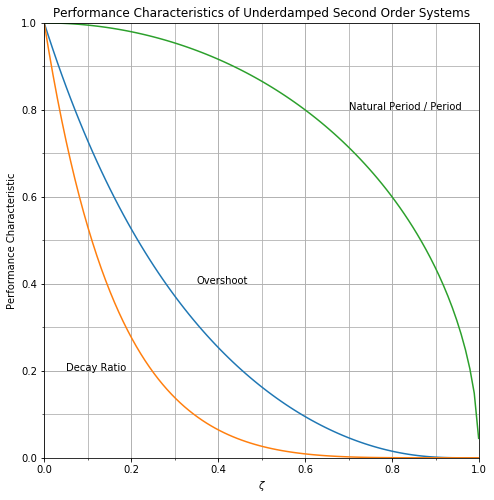

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

zeta = np.linspace(0,0.999,100)
os = np.exp(-np.pi*zeta/np.sqrt(1-zeta**2))
dr = np.exp(-2*np.pi*zeta/np.sqrt(1-zeta**2))
pd = np.sqrt(1-zeta**2)

plt.figure(figsize=(8,8))
plt.plot(zeta,os)
plt.plot(zeta,dr)
plt.plot(zeta,pd)
plt.axis('square')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Performance Characteristics of Underdamped Second Order Systems')
plt.xlabel('$\zeta$')
plt.ylabel('Performance Characteristic')
plt.text(0.35,0.4,'Overshoot')
plt.text(0.05,.2,'Decay Ratio')
plt.text(0.7,0.8,'Natural Period / Period')
plt.gca().set_xticks(np.arange(0,1,0.1),minor=True)
plt.gca().set_yticks(np.arange(0,1,0.1),minor=True)
plt.grid(b=True,which='major')
plt.grid(b=True,which='minor')

# CBE30338 Model Library

In [1]:
%matplotlib inline

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint,ode

class GravityTank():
    
    def __init__(self, A=1, Cv=1, h = 0):
        self.A = A
        self.Cv = Cv
        self.Qin = 0
        self._h = h
        self.IC = self._h
        
    def deriv(self,h,t):
        h = max(0,h)
        self._h = h
        return (self.Qin/self.A - self.Cv*np.sqrt(h)/self.A)
    
    @property
    def Qin(self):
        return self._Qin
    
    @Qin.setter
    def Qin(self,Qin):
        self._Qin = Qin
        
    @property
    def Qout(self):
        return self.Cv*np.sqrt(self._h)
        
        

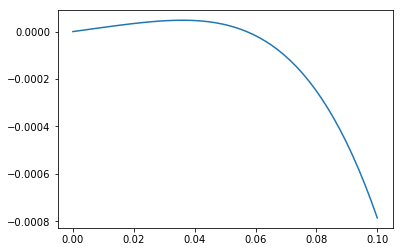

In [186]:
tank1 = GravityTank(2,1)
tank2 = GravityTank(1.5,2)

t = np.linspace(0,.1,50)
tank1.Qin = 3

def deriv(X,t):
    h1,h2 = X
    tank2.Qin = tank1.Qout
    dh1 = tank1.deriv(h1,t)
    dh2 = tank2.deriv(h2,t)
    #print("{0:9.6f}  {1:9.6f}  {2:9.6f}  {3:9.6f}  {4:9.6f}  {5:9.6f}   {6:9.6f}   {7:9.6f}  {8:9.6f}".format(h1,h2,tank1.Qin,tank1.Qout,tank2.Qin,tank2.Qout,dh1,dh2,t))
    return [dh1,dh2]


sol = odeint(deriv,[0,0],t)
h1,h2 = sol.T
plt.plot(t,h2)

/Users/jeff/anaconda/lib/python3.5/site-packages/scipy/integrate/_ode.py:869: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  'Unexpected istate=%s' % istate))


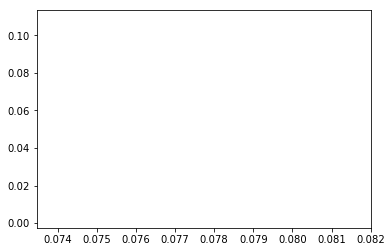

In [165]:
tank1 = GravityTank(2,1)
tank2 = GravityTank(1.5,1)
tank3 = GravityTank(0.8,0.9)

tank1.Qin = 3

def deriv(t,X):
    h1,h2,h3 = X
    tank2.Qin = tank1.Qout
    tank3.Qin = tank2.Qout
    dh1 = tank1.deriv(h1,t)
    dh2 = tank2.deriv(h2,t)
    dh3 = tank3.deriv(h3,t)
    return [dh1,dh2,dh3]


de = ode(deriv)
de.set_initial_value(IC,0)

ts = []
ys = []
t_end = 10
t_step = .2

while de.successful() and de.t < t_end:
    de.integrate(de.t + t_step)
    ts.append(de.t)
    ys.append(de.y)

plt.plot(ts,ys)

[0, 0, 0]
[1.5, 0.0, 0.0]


/Users/jeff/anaconda/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


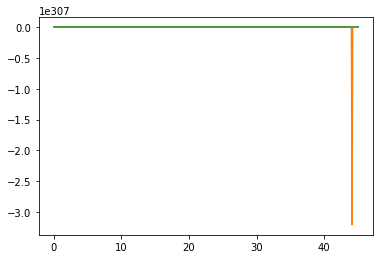

In [107]:
IC = [tank1.IC] + [tank2.IC] + [tank3.IC]
print(IC)
print(deriv(IC,0))
t = np.linspace(0,45,500)
sol = odeint(deriv,IC,t)
plt.plot(t,sol)

In [53]:
tank3.Qin

0.0

# Zero-Order Hold and Interpolation

Implementation of control systems generally requires an interface between the sampled data computations of process control and the continuous time dynamics of the real world. A zero-order hold is the most common model for the reconstruction of a continuous time signal from sampled data. 

## Interpolation Function

In [1]:
import numpy as np

def interp0(x, xp, yp):
    """Zeroth order hold interpolation w/ same
    (base)   signature  as numpy.interp."""

    def func(x0):
        if x0 <= xp[0]:
            return yp[0]
        if x0 >= xp[-1]:
            return yp[-1]
        k = 0
        while x0 > xp[k]:
            k += 1
        return yp[k-1]
    
    if isinstance(x,float):
        return func(x)
    elif isinstance(x, list):
        return [func(x) for x in x]
    elif isinstance(x, np.ndarray):
        return np.asarray([func(x) for x in x])
    else:
        raise TypeError('argument must be float, list, or ndarray')

## Demonstration

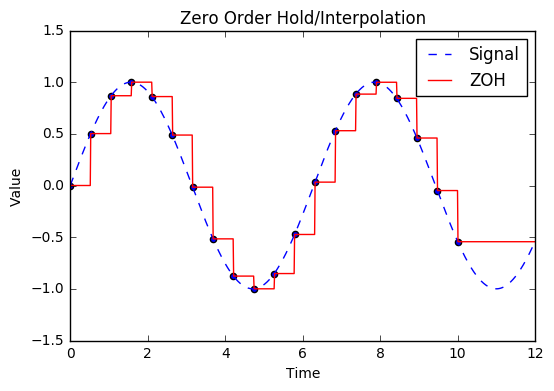

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# choose a function
f = np.sin

# sampled signal
xp = np.linspace(0,10,20)
yp = f(xp)

# interpolation grid with 'true' function
x = np.linspace(0,12,1000)
plt.plot(x,f(x),'--')

# plot
plt.hold(True)
plt.scatter(xp,yp)
plt.plot(x,interp0(x,xp,yp),'r')
plt.xlim([x.min(),x.max()])
plt.title('Zero Order Hold/Interpolation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Signal','ZOH'])